In [1]:
import theano
theano.config.floatX = "float32"
import theano.tensor as T
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

Couldn't import dot_parser, loading of dot files will not be possible.


# problem statement

In [2]:
arr_len = 25
n_rules = 15

rule_lengths = np.random.normal(3,2,size=n_rules).astype(int)
rule_lengths[rule_lengths<1] = 1

rule_starts = np.random.randint(0,arr_len-1,size=n_rules)

rules = map(lambda x0,l: np.arange(x0,min(x0+l, arr_len)) , rule_starts, rule_lengths)
rules = np.array(rules)

rule_probas = np.repeat(0.5,n_rules)

In [3]:
from itertools import product
class Event:
    def __init__(self,arr):
        self.arr = arr
    def respond(self,action_code):
        return self.arr[tuple(action_code)]

def generate_event():
    rule_triggered = rule_probas > np.random.random(size = n_rules)
    rule_triggered = rule_triggered.astype(bool)
    
    arr = np.zeros(arr_len).astype(bool)
    if np.any(rule_triggered):
        arr[np.concatenate(rules[rule_triggered])] = True
    return Event(arr.reshape(1,-1,5))

def get_action_codes(event):
    codes = [np.arange(i) for i in event.arr.shape]
    return list(product(*codes)) + [-1] #-1 is "next event" action



[array([21, 22, 23]) array([6, 7, 8, 9]) array([1, 2]) array([6, 7, 8])
 array([1]) array([0, 1, 2, 3]) array([7]) array([15, 16, 17, 18])
 array([2, 3]) array([ 9, 10, 11, 12, 13, 14]) array([0])
 array([ 8,  9, 10, 11, 12]) array([22, 23, 24]) array([19]) array([7])]


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


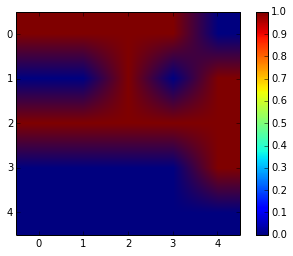

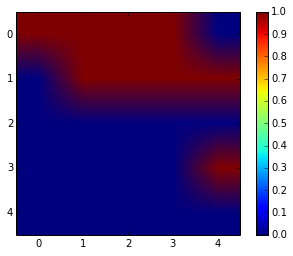

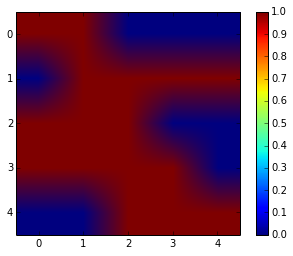

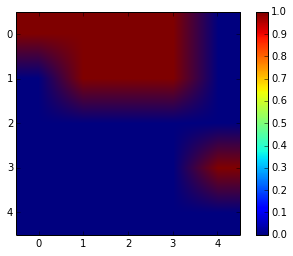

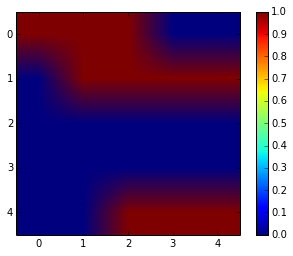

In [4]:
print rules
for i in range(5):
    plt.imshow(generate_event().arr.reshape(-1,5))
    plt.colorbar()
    plt.show()

# naive q-learning

In [5]:
class Session():
    def __init__(self,event):
        self.event = event
        self.attempted = np.zeros_like(event.arr).astype(bool)

        self.has_ended = False
    def act(self,action_code):
        
        if action_code == -1:
            self.has_ended = True
            return None,0
        
        
        resp = self.event.respond(action_code)
        is_first_time = not self.attempted[tuple(action_code)]
        
        reward = resp*2-1
        
        if reward >0 and not is_first_time:
            reward = -0.0001
        
        self.attempted[tuple(action_code)] =1
        
        return resp,reward
    
    def new_state(self,state,action_id,result):
        """assuming state is tuple, action id is int, result is bool"""
        state = list(state)
        state[action_id]= result

        return tuple(state)


In [292]:
from collections import defaultdict

actions = get_action_codes(generate_event())
action_ids = np.arange(len(actions))
action_to_id = {i:a for i,a in enumerate(actions)}.get


alpha= 0.1 #learning rate
gamma= 0.99 #delayed reward penalty

class Agent():
    def __init__(self):
        #Q[state_id][action_id]
        self.Q = defaultdict(lambda: np.zeros_like(action_ids,dtype=float) )
    
        self.reset_state()
    def reset_state(self):
        self.state = (-1,)*arr_len
        
    def step(self,session,greediness = 1.,randomness_rate = 0.,verbose=False):
        
        
        #decision making via softmax probas        
        action_Qvalues = self.Q[self.state]
        
        if np.random.random() < randomness_rate:
            action_probas = np.repeat(1./len(action_Qvalues) ,repeats = len(action_Qvalues))
        else:
            action_probas = np.exp(action_Qvalues*greediness)
            action_probas /= np.sum(action_probas)
                
        choice_id = np.random.choice(action_ids,p=action_probas)
        
        if verbose>=1:
            print "chosen action #%s : %s (p = %s)"%(choice_id, actions[choice_id], action_probas[choice_id])
        
        
        #state transition
        response,reward = session.act(actions[choice_id])
        
        #session ended
        if response is None:
            
            if verbose:
                print "session ended"
            self.reset_state()
            return reward
        
        if verbose>=1:
            print "got response %s, reward %s"%(response,reward)
        
    
        new_state = session.new_state(self.state,choice_id,response)
        
        #learning
        predicted_Qvalue = self.Q[self.state][choice_id]
        
        actual_Qvalue = reward + gamma* np.max(self.Q[new_state])
        
        dQ = (actual_Qvalue - predicted_Qvalue) *alpha
        
        if verbose >=2:
            print "actual Q = %s , predicted %s" %(actual_Qvalue,predicted_Qvalue)

        self.Q[self.state][choice_id] += dQ
        
        if verbose >=2:
            print "updated by %s, now %s"%(dQ, self.Q[self.state][choice_id])
        
        
        #updating state
        self.state = new_state
        
        return reward
    

In [14]:
a = Agent()
reward_ma = 0.
moving_average_rate = 0.0001

report_iter = [0]
rewards_history = [0]
session_length_history = [0]

itr = 0

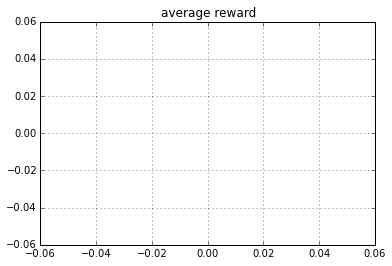

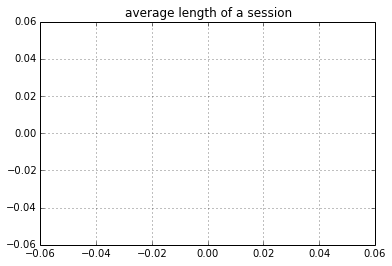

10000 iters ( 9999 / 1000000000 ) |sessions passed: 397 |reward: -0.0237527743611 |epsilon: 0.297
20000 iters ( 19999 / 1000000000 ) |sessions passed: 351 |reward: -0.0509523588776 |epsilon: 0.295757359313
30000 iters ( 29999 / 1000000000 ) |sessions passed: 357 |reward: -0.0326063182344 |epsilon: 0.294803847577
40000 iters ( 39999 / 1000000000 ) |sessions passed: 355 |reward: -0.0456739571606 |epsilon: 0.294
50000 iters ( 49999 / 1000000000 ) |sessions passed: 360 |reward: -0.0399716887522 |epsilon: 0.293291796068
60000 iters ( 59999 / 1000000000 ) |sessions passed: 365 |reward: -0.0262075382027 |epsilon: 0.292651530772
70000 iters ( 69999 / 1000000000 ) |sessions passed: 368 |reward: -0.0191181953339 |epsilon: 0.292062746067
80000 iters ( 79999 / 1000000000 ) |sessions passed: 366 |reward: -0.0162803456787 |epsilon: 0.291514718626
90000 iters ( 89999 / 1000000000 ) |sessions passed: 355 |reward: -0.0342024311725 |epsilon: 0.291
100000 iters ( 99999 / 1000000000 ) |sessions passed: 37

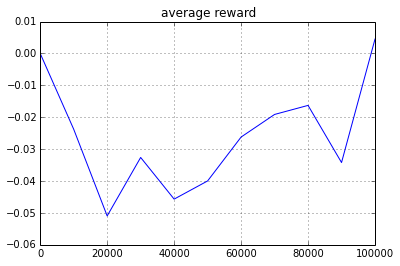

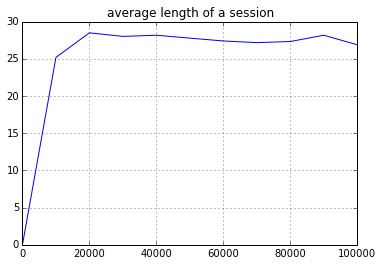

110000 iters ( 109999 / 1000000000 ) |sessions passed: 354 |reward: -0.0211084670995 |epsilon: 0.290050125629
120000 iters ( 119999 / 1000000000 ) |sessions passed: 340 |reward: -0.0167653177371 |epsilon: 0.289607695155
130000 iters ( 129999 / 1000000000 ) |sessions passed: 365 |reward: -0.0183670932003 |epsilon: 0.289183346174
140000 iters ( 139999 / 1000000000 ) |sessions passed: 330 |reward: -0.0153107669713 |epsilon: 0.28877502784
150000 iters ( 149999 / 1000000000 ) |sessions passed: 346 |reward: -0.0172614450036 |epsilon: 0.288381049961
160000 iters ( 159999 / 1000000000 ) |sessions passed: 357 |reward: -0.019485096378 |epsilon: 0.288
170000 iters ( 169999 / 1000000000 ) |sessions passed: 336 |reward: -0.0305985504714 |epsilon: 0.287630683123
180000 iters ( 179999 / 1000000000 ) |sessions passed: 340 |reward: -0.0498022783952 |epsilon: 0.287272077939
190000 iters ( 189999 / 1000000000 ) |sessions passed: 320 |reward: -0.0262474596612 |epsilon: 0.286923303169
200000 iters ( 199999

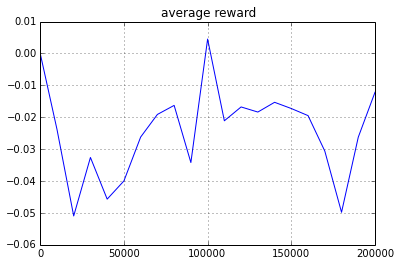

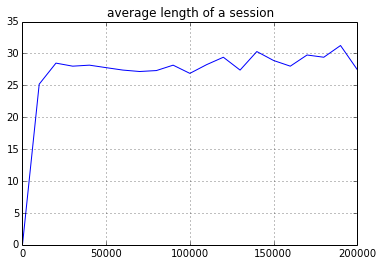

210000 iters ( 209999 / 1000000000 ) |sessions passed: 372 |reward: -0.011246333352 |epsilon: 0.286252272915
220000 iters ( 219999 / 1000000000 ) |sessions passed: 348 |reward: -0.00772214526727 |epsilon: 0.285928752721
230000 iters ( 229999 / 1000000000 ) |sessions passed: 331 |reward: -0.0371872276217 |epsilon: 0.28561250543
240000 iters ( 239999 / 1000000000 ) |sessions passed: 353 |reward: -0.0463347198843 |epsilon: 0.285303061543
250000 iters ( 249999 / 1000000000 ) |sessions passed: 366 |reward: -0.027383426845 |epsilon: 0.285
260000 iters ( 259999 / 1000000000 ) |sessions passed: 333 |reward: 0.00606288117585 |epsilon: 0.284702941459
270000 iters ( 269999 / 1000000000 ) |sessions passed: 344 |reward: 0.0105178737286 |epsilon: 0.284411542732
280000 iters ( 279999 / 1000000000 ) |sessions passed: 322 |reward: 0.00185827723202 |epsilon: 0.284125492134
290000 iters ( 289999 / 1000000000 ) |sessions passed: 344 |reward: -0.0135390156688 |epsilon: 0.283844505579
300000 iters ( 299999 

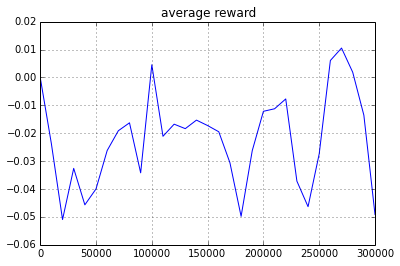

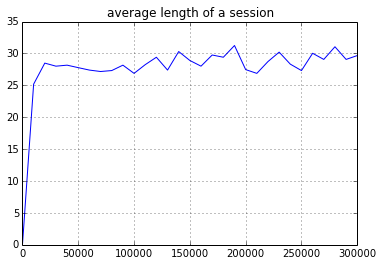

310000 iters ( 309999 / 1000000000 ) |sessions passed: 329 |reward: -0.0196169187121 |epsilon: 0.283296706912
320000 iters ( 319999 / 1000000000 ) |sessions passed: 369 |reward: 0.0199851135754 |epsilon: 0.283029437252
330000 iters ( 329999 / 1000000000 ) |sessions passed: 359 |reward: -0.0160713269978 |epsilon: 0.28276631206
340000 iters ( 339999 / 1000000000 ) |sessions passed: 376 |reward: -0.00206945164257 |epsilon: 0.282507144315
350000 iters ( 349999 / 1000000000 ) |sessions passed: 353 |reward: 0.000501246690539 |epsilon: 0.282251760651
360000 iters ( 359999 / 1000000000 ) |sessions passed: 345 |reward: 0.0031446161673 |epsilon: 0.282
370000 iters ( 369999 / 1000000000 ) |sessions passed: 320 |reward: -0.0267829622378 |epsilon: 0.281751712409
380000 iters ( 379999 / 1000000000 ) |sessions passed: 340 |reward: -0.0276483115235 |epsilon: 0.281506757991
390000 iters ( 389999 / 1000000000 ) |sessions passed: 342 |reward: -0.0248177227341 |epsilon: 0.281265006005
400000 iters ( 39999

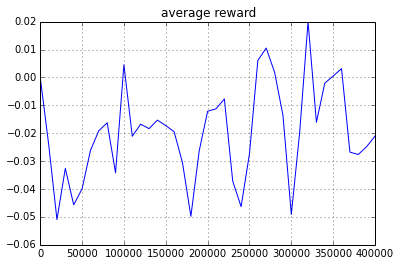

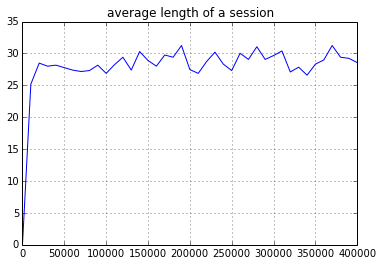

410000 iters ( 409999 / 1000000000 ) |sessions passed: 371 |reward: -0.0206519673358 |epsilon: 0.280790627288
420000 iters ( 419999 / 1000000000 ) |sessions passed: 350 |reward: -0.0170427634527 |epsilon: 0.280557777905
430000 iters ( 429999 / 1000000000 ) |sessions passed: 353 |reward: -0.0189739881223 |epsilon: 0.280327684427
440000 iters ( 439999 / 1000000000 ) |sessions passed: 351 |reward: -0.00918755319303 |epsilon: 0.280100251258
450000 iters ( 449999 / 1000000000 ) |sessions passed: 351 |reward: 0.00828790175649 |epsilon: 0.279875388203
460000 iters ( 459999 / 1000000000 ) |sessions passed: 321 |reward: -0.00931981173924 |epsilon: 0.279653010051
470000 iters ( 469999 / 1000000000 ) |sessions passed: 342 |reward: -0.0341816466653 |epsilon: 0.279433036199
480000 iters ( 479999 / 1000000000 ) |sessions passed: 329 |reward: -0.0327200141123 |epsilon: 0.279215390309
490000 iters ( 489999 / 1000000000 ) |sessions passed: 354 |reward: -0.0149212249643 |epsilon: 0.279
500000 iters ( 49

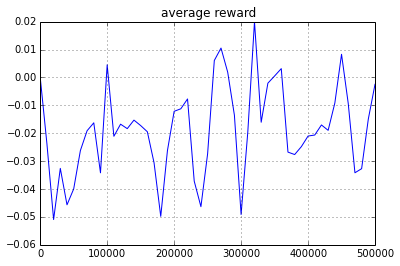

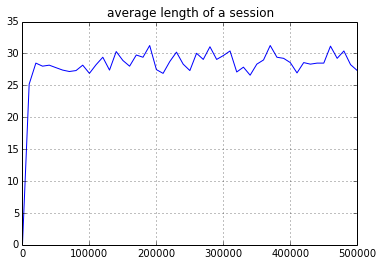

510000 iters ( 509999 / 1000000000 ) |sessions passed: 343 |reward: -0.0125580793791 |epsilon: 0.278575714714
520000 iters ( 519999 / 1000000000 ) |sessions passed: 348 |reward: -0.020513101504 |epsilon: 0.278366692347
530000 iters ( 529999 / 1000000000 ) |sessions passed: 348 |reward: -0.00381963673011 |epsilon: 0.278159670332
540000 iters ( 539999 / 1000000000 ) |sessions passed: 343 |reward: -0.0181400576684 |epsilon: 0.277954592315
550000 iters ( 549999 / 1000000000 ) |sessions passed: 339 |reward: -0.0115020547098 |epsilon: 0.277751404539
560000 iters ( 559999 / 1000000000 ) |sessions passed: 325 |reward: -0.0205780738383 |epsilon: 0.277550055679
570000 iters ( 569999 / 1000000000 ) |sessions passed: 353 |reward: -0.00704345421513 |epsilon: 0.277350496694
580000 iters ( 579999 / 1000000000 ) |sessions passed: 329 |reward: 0.00528108177032 |epsilon: 0.277152680682
590000 iters ( 589999 / 1000000000 ) |sessions passed: 334 |reward: -0.0219474411811 |epsilon: 0.276956562756
600000 it

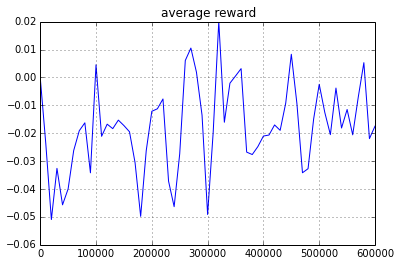

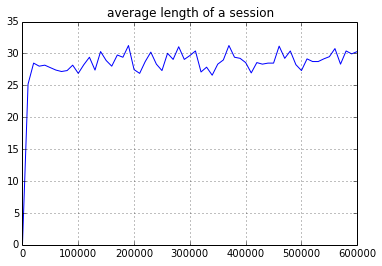

610000 iters ( 609999 / 1000000000 ) |sessions passed: 351 |reward: -0.000881278034762 |epsilon: 0.276569250972
620000 iters ( 619999 / 1000000000 ) |sessions passed: 348 |reward: 0.000483899851371 |epsilon: 0.276377976378
630000 iters ( 629999 / 1000000000 ) |sessions passed: 344 |reward: 0.00478776800366 |epsilon: 0.2761882382
640000 iters ( 639999 / 1000000000 ) |sessions passed: 324 |reward: 0.00139939180389 |epsilon: 0.276
650000 iters ( 649999 / 1000000000 ) |sessions passed: 316 |reward: -0.0131779341597 |epsilon: 0.275813226755
660000 iters ( 659999 / 1000000000 ) |sessions passed: 359 |reward: -0.0101003020827 |epsilon: 0.275627884786
670000 iters ( 669999 / 1000000000 ) |sessions passed: 322 |reward: -0.00781726666719 |epsilon: 0.275443941684
680000 iters ( 679999 / 1000000000 ) |sessions passed: 357 |reward: -0.00031434309204 |epsilon: 0.275261366246
690000 iters ( 689999 / 1000000000 ) |sessions passed: 316 |reward: 0.00796425135871 |epsilon: 0.275080128411
700000 iters ( 6

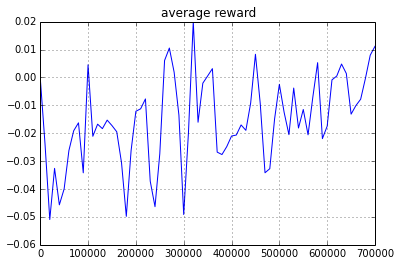

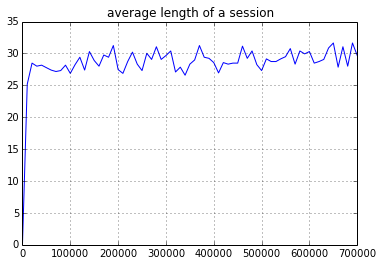

710000 iters ( 709999 / 1000000000 ) |sessions passed: 349 |reward: -0.00978723468223 |epsilon: 0.27472155068
720000 iters ( 719999 / 1000000000 ) |sessions passed: 321 |reward: -0.0032990007964 |epsilon: 0.274544155877
730000 iters ( 729999 / 1000000000 ) |sessions passed: 333 |reward: 0.0251735231711 |epsilon: 0.274367988764
740000 iters ( 739999 / 1000000000 ) |sessions passed: 335 |reward: 0.0210269073784 |epsilon: 0.274193024199
750000 iters ( 749999 / 1000000000 ) |sessions passed: 361 |reward: -0.00469244081183 |epsilon: 0.274019237886
760000 iters ( 759999 / 1000000000 ) |sessions passed: 382 |reward: 0.0154236788792 |epsilon: 0.273846606339
770000 iters ( 769999 / 1000000000 ) |sessions passed: 343 |reward: 0.0167185633775 |epsilon: 0.273675106838
780000 iters ( 779999 / 1000000000 ) |sessions passed: 313 |reward: -0.00624135754953 |epsilon: 0.273504717401
790000 iters ( 789999 / 1000000000 ) |sessions passed: 325 |reward: -0.0165978536548 |epsilon: 0.273335416748
800000 iters

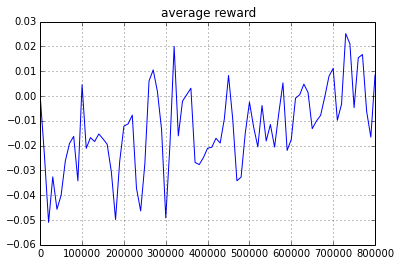

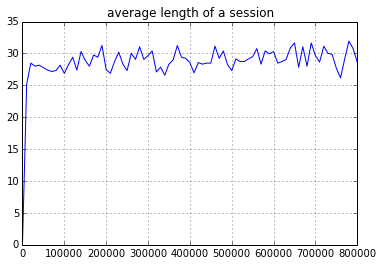

810000 iters ( 809999 / 1000000000 ) |sessions passed: 311 |reward: -0.0102964505367 |epsilon: 0.273
820000 iters ( 819999 / 1000000000 ) |sessions passed: 354 |reward: 0.00564827913907 |epsilon: 0.272833844586
830000 iters ( 829999 / 1000000000 ) |sessions passed: 341 |reward: -0.00612153126982 |epsilon: 0.272668699263
840000 iters ( 839999 / 1000000000 ) |sessions passed: 334 |reward: -0.00264350998144 |epsilon: 0.27250454583
850000 iters ( 849999 / 1000000000 ) |sessions passed: 353 |reward: 0.00301560335203 |epsilon: 0.272341366628
860000 iters ( 859999 / 1000000000 ) |sessions passed: 348 |reward: 0.0044167801325 |epsilon: 0.272179144514
870000 iters ( 869999 / 1000000000 ) |sessions passed: 334 |reward: 0.00775943494891 |epsilon: 0.272017862841
880000 iters ( 879999 / 1000000000 ) |sessions passed: 370 |reward: 0.00789617821842 |epsilon: 0.271857505441
890000 iters ( 889999 / 1000000000 ) |sessions passed: 314 |reward: -0.00715934987785 |epsilon: 0.271698056604
900000 iters ( 899

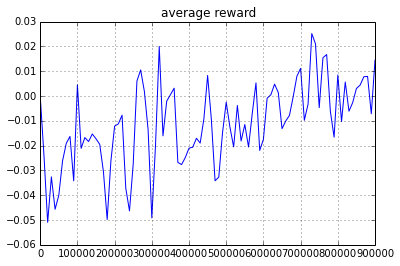

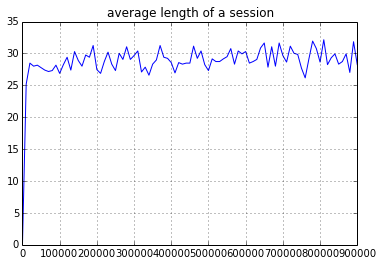

910000 iters ( 909999 / 1000000000 ) |sessions passed: 355 |reward: 0.0219806811417 |epsilon: 0.271381823957
920000 iters ( 919999 / 1000000000 ) |sessions passed: 328 |reward: 0.00814814362885 |epsilon: 0.27122501086
930000 iters ( 929999 / 1000000000 ) |sessions passed: 342 |reward: 0.0225805043806 |epsilon: 0.271069047717
940000 iters ( 939999 / 1000000000 ) |sessions passed: 343 |reward: 0.00971460942236 |epsilon: 0.270913920856
950000 iters ( 949999 / 1000000000 ) |sessions passed: 308 |reward: -0.00910095759272 |epsilon: 0.270759616966
960000 iters ( 959999 / 1000000000 ) |sessions passed: 343 |reward: -0.0148939828056 |epsilon: 0.270606123087
970000 iters ( 969999 / 1000000000 ) |sessions passed: 344 |reward: -0.000744474110209 |epsilon: 0.270453426595
980000 iters ( 979999 / 1000000000 ) |sessions passed: 337 |reward: 0.0136579096412 |epsilon: 0.27030151519
990000 iters ( 989999 / 1000000000 ) |sessions passed: 346 |reward: 0.0167432487611 |epsilon: 0.270150376887
1000000 iters

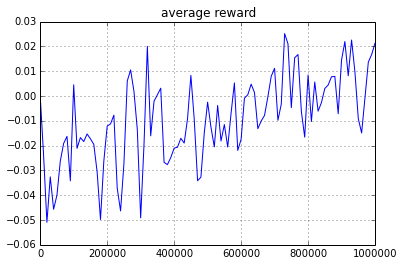

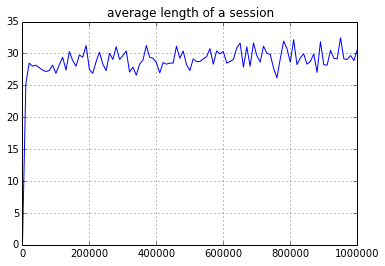

1010000 iters ( 1009999 / 1000000000 ) |sessions passed: 385 |reward: 0.0202381223307 |epsilon: 0.269850373137
1020000 iters ( 1019999 / 1000000000 ) |sessions passed: 311 |reward: 0.0218758691809 |epsilon: 0.269701485185
1030000 iters ( 1029999 / 1000000000 ) |sessions passed: 321 |reward: 0.00354679003359 |epsilon: 0.269553325305
1040000 iters ( 1039999 / 1000000000 ) |sessions passed: 330 |reward: -0.010080625849 |epsilon: 0.269405882918
1050000 iters ( 1049999 / 1000000000 ) |sessions passed: 332 |reward: -0.00213760814469 |epsilon: 0.269259147702
1060000 iters ( 1059999 / 1000000000 ) |sessions passed: 337 |reward: 0.00190866058518 |epsilon: 0.269113109577
1070000 iters ( 1069999 / 1000000000 ) |sessions passed: 332 |reward: -0.0105671156458 |epsilon: 0.268967758702
1080000 iters ( 1079999 / 1000000000 ) |sessions passed: 334 |reward: 0.00282943591878 |epsilon: 0.268823085464
1090000 iters ( 1089999 / 1000000000 ) |sessions passed: 315 |reward: -0.00395214029709 |epsilon: 0.268679

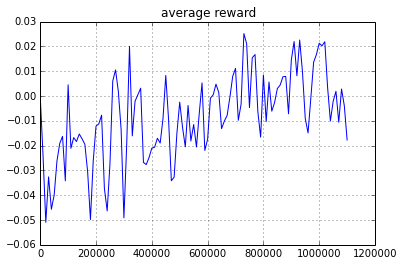

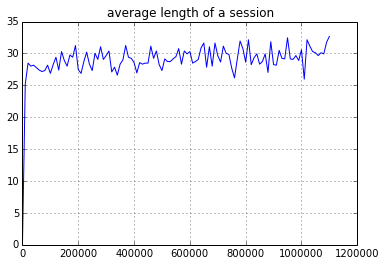

1110000 iters ( 1109999 / 1000000000 ) |sessions passed: 344 |reward: -0.036218896312 |epsilon: 0.268393038741
1120000 iters ( 1119999 / 1000000000 ) |sessions passed: 349 |reward: -0.00176884798784 |epsilon: 0.268250984267
1130000 iters ( 1129999 / 1000000000 ) |sessions passed: 321 |reward: -0.00305539042106 |epsilon: 0.268109562562
1140000 iters ( 1139999 / 1000000000 ) |sessions passed: 317 |reward: 0.0101486088957 |epsilon: 0.267968765244
1150000 iters ( 1149999 / 1000000000 ) |sessions passed: 335 |reward: -0.00451290885095 |epsilon: 0.267828584116
1160000 iters ( 1159999 / 1000000000 ) |sessions passed: 317 |reward: -0.00842149511224 |epsilon: 0.267689011157
1170000 iters ( 1169999 / 1000000000 ) |sessions passed: 337 |reward: -0.00315358328042 |epsilon: 0.267550038521
1180000 iters ( 1179999 / 1000000000 ) |sessions passed: 324 |reward: 0.00689213461152 |epsilon: 0.267411658526
1190000 iters ( 1189999 / 1000000000 ) |sessions passed: 339 |reward: 0.0185438214529 |epsilon: 0.267

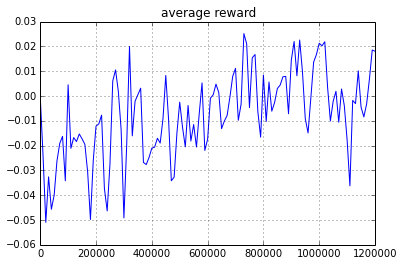

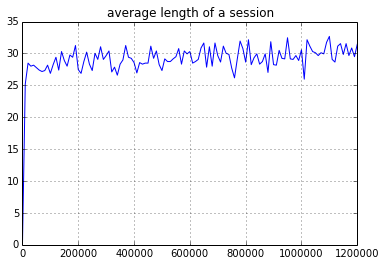

1210000 iters ( 1209999 / 1000000000 ) |sessions passed: 327 |reward: 0.0135486153128 |epsilon: 0.267
1220000 iters ( 1219999 / 1000000000 ) |sessions passed: 312 |reward: -0.01278216254 |epsilon: 0.266863916948
1230000 iters ( 1229999 / 1000000000 ) |sessions passed: 331 |reward: 0.0125146094605 |epsilon: 0.266728390481
1240000 iters ( 1239999 / 1000000000 ) |sessions passed: 333 |reward: -0.00457985228794 |epsilon: 0.266593413823
1250000 iters ( 1249999 / 1000000000 ) |sessions passed: 322 |reward: 0.0131322917408 |epsilon: 0.266458980338
1260000 iters ( 1259999 / 1000000000 ) |sessions passed: 315 |reward: 0.0136651954888 |epsilon: 0.266325083519
1270000 iters ( 1269999 / 1000000000 ) |sessions passed: 338 |reward: 0.0156716317545 |epsilon: 0.266191716991
1280000 iters ( 1279999 / 1000000000 ) |sessions passed: 335 |reward: 0.0245757195309 |epsilon: 0.266058874503
1290000 iters ( 1289999 / 1000000000 ) |sessions passed: 338 |reward: 0.0257418950027 |epsilon: 0.265926549925
1300000 i

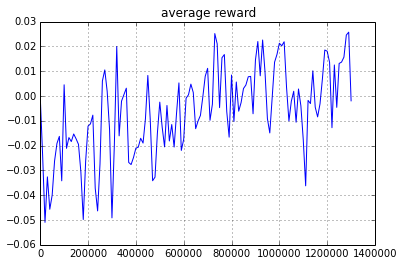

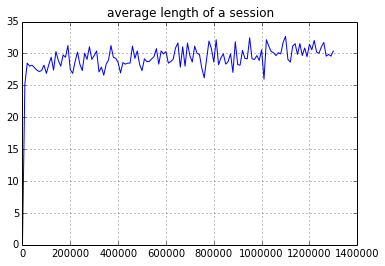

1310000 iters ( 1309999 / 1000000000 ) |sessions passed: 345 |reward: 0.00934804012531 |epsilon: 0.265663430573
1320000 iters ( 1319999 / 1000000000 ) |sessions passed: 308 |reward: 0.00743117913364 |epsilon: 0.265532624121
1330000 iters ( 1329999 / 1000000000 ) |sessions passed: 319 |reward: 0.0132226139804 |epsilon: 0.265402312216
1340000 iters ( 1339999 / 1000000000 ) |sessions passed: 307 |reward: -0.00914235299738 |epsilon: 0.265272489292
1350000 iters ( 1349999 / 1000000000 ) |sessions passed: 336 |reward: 0.00142330880968 |epsilon: 0.265143149884
1360000 iters ( 1359999 / 1000000000 ) |sessions passed: 323 |reward: 0.00590869306372 |epsilon: 0.265014288631
1370000 iters ( 1369999 / 1000000000 ) |sessions passed: 319 |reward: 0.00516214576564 |epsilon: 0.264885900268
1380000 iters ( 1379999 / 1000000000 ) |sessions passed: 335 |reward: -0.00783110364361 |epsilon: 0.264757979627
1390000 iters ( 1389999 / 1000000000 ) |sessions passed: 349 |reward: 0.00605141954207 |epsilon: 0.2646

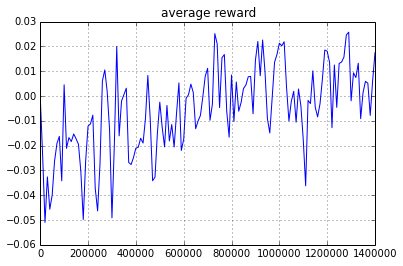

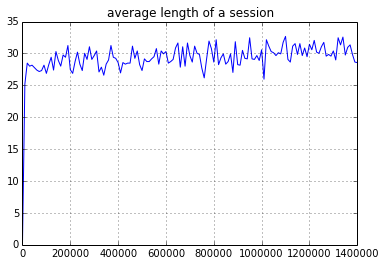

1410000 iters ( 1409999 / 1000000000 ) |sessions passed: 341 |reward: -0.0136220350098 |epsilon: 0.264376973739
1420000 iters ( 1419999 / 1000000000 ) |sessions passed: 335 |reward: -0.00546544812343 |epsilon: 0.264250874137
1430000 iters ( 1429999 / 1000000000 ) |sessions passed: 338 |reward: 0.0107963080621 |epsilon: 0.264125217771
1440000 iters ( 1439999 / 1000000000 ) |sessions passed: 322 |reward: 0.00247640315356 |epsilon: 0.264
1450000 iters ( 1449999 / 1000000000 ) |sessions passed: 320 |reward: 0.00957751093641 |epsilon: 0.263875216264
1460000 iters ( 1459999 / 1000000000 ) |sessions passed: 329 |reward: 0.0100162802487 |epsilon: 0.263750862079
1470000 iters ( 1469999 / 1000000000 ) |sessions passed: 309 |reward: 0.00882401143086 |epsilon: 0.263626933041
1480000 iters ( 1479999 / 1000000000 ) |sessions passed: 321 |reward: -0.00692780689739 |epsilon: 0.263503424818
1490000 iters ( 1489999 / 1000000000 ) |sessions passed: 346 |reward: 0.000245482728549 |epsilon: 0.263380333153


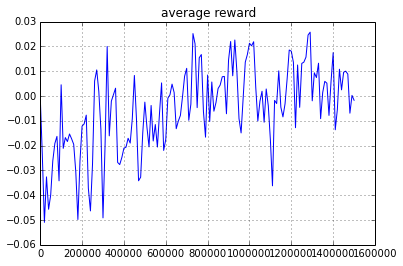

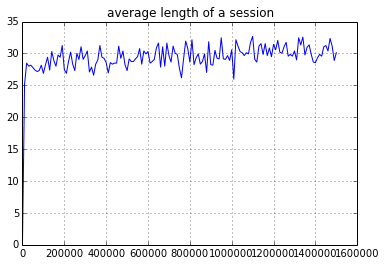

1510000 iters ( 1509999 / 1000000000 ) |sessions passed: 317 |reward: 0.00635173836773 |epsilon: 0.263135382818
1520000 iters ( 1519999 / 1000000000 ) |sessions passed: 338 |reward: -0.0121671158568 |epsilon: 0.263013515982
1530000 iters ( 1529999 / 1000000000 ) |sessions passed: 334 |reward: 0.00922347339514 |epsilon: 0.262892049369
1540000 iters ( 1539999 / 1000000000 ) |sessions passed: 337 |reward: 0.0139576334631 |epsilon: 0.262770979062
1550000 iters ( 1549999 / 1000000000 ) |sessions passed: 325 |reward: 0.0186198602398 |epsilon: 0.262650301206
1560000 iters ( 1559999 / 1000000000 ) |sessions passed: 363 |reward: 0.0187874213399 |epsilon: 0.26253001201
1570000 iters ( 1569999 / 1000000000 ) |sessions passed: 322 |reward: -0.00610229031956 |epsilon: 0.262410107742
1580000 iters ( 1579999 / 1000000000 ) |sessions passed: 309 |reward: 0.00774602760085 |epsilon: 0.26229058473
1590000 iters ( 1589999 / 1000000000 ) |sessions passed: 326 |reward: 0.0222501588161 |epsilon: 0.2621714393

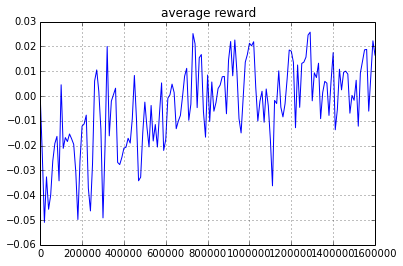

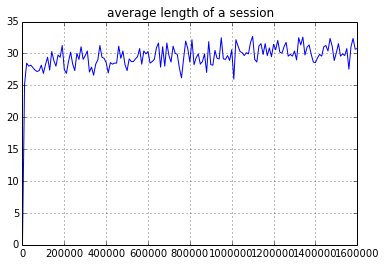

1610000 iters ( 1609999 / 1000000000 ) |sessions passed: 330 |reward: 0.0231149938832 |epsilon: 0.261934267379
1620000 iters ( 1619999 / 1000000000 ) |sessions passed: 314 |reward: 0.0019845133519 |epsilon: 0.261816233816
1630000 iters ( 1629999 / 1000000000 ) |sessions passed: 325 |reward: 0.00661255021722 |epsilon: 0.261698563996
1640000 iters ( 1639999 / 1000000000 ) |sessions passed: 351 |reward: 0.0286852475806 |epsilon: 0.261581254575
1650000 iters ( 1649999 / 1000000000 ) |sessions passed: 349 |reward: 0.00395673372798 |epsilon: 0.261464302264
1660000 iters ( 1659999 / 1000000000 ) |sessions passed: 337 |reward: 0.0139257789466 |epsilon: 0.26134770382
1670000 iters ( 1669999 / 1000000000 ) |sessions passed: 339 |reward: -0.0077719617246 |epsilon: 0.26123145605
1680000 iters ( 1679999 / 1000000000 ) |sessions passed: 345 |reward: -0.000704478373657 |epsilon: 0.26111555581
1690000 iters ( 1689999 / 1000000000 ) |sessions passed: 336 |reward: 0.0103305388513 |epsilon: 0.261
1700000

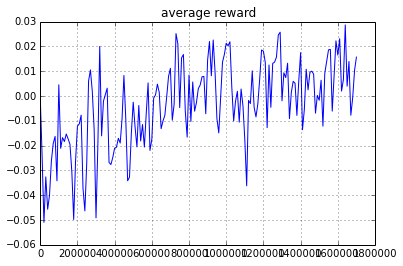

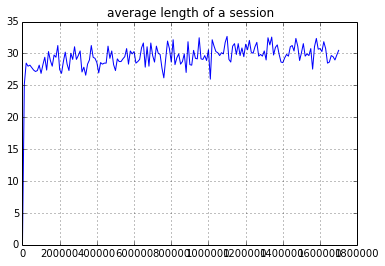

1710000 iters ( 1709999 / 1000000000 ) |sessions passed: 329 |reward: -0.00270380041146 |epsilon: 0.260769909508
1720000 iters ( 1719999 / 1000000000 ) |sessions passed: 304 |reward: 0.0072168124234 |epsilon: 0.260655368854
1730000 iters ( 1729999 / 1000000000 ) |sessions passed: 320 |reward: 0.00120470594118 |epsilon: 0.260541160686
1740000 iters ( 1739999 / 1000000000 ) |sessions passed: 333 |reward: 0.00114425726505 |epsilon: 0.260427282125
1750000 iters ( 1749999 / 1000000000 ) |sessions passed: 337 |reward: 0.000642840180303 |epsilon: 0.260313730334
1760000 iters ( 1759999 / 1000000000 ) |sessions passed: 311 |reward: -0.010224816047 |epsilon: 0.260200502516
1770000 iters ( 1769999 / 1000000000 ) |sessions passed: 328 |reward: 0.00574803551858 |epsilon: 0.260087595913
1780000 iters ( 1779999 / 1000000000 ) |sessions passed: 331 |reward: -0.0117429461549 |epsilon: 0.259975007808
1790000 iters ( 1789999 / 1000000000 ) |sessions passed: 331 |reward: 0.00647569849568 |epsilon: 0.25986

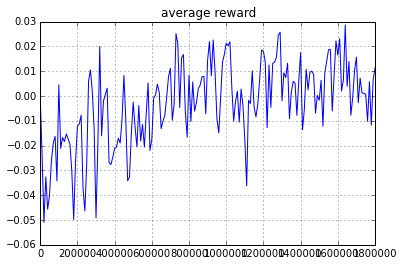

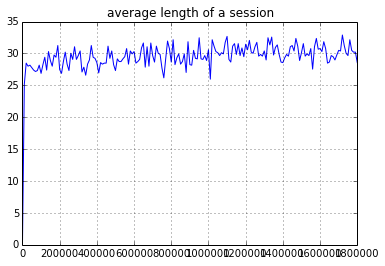

1810000 iters ( 1809999 / 1000000000 ) |sessions passed: 302 |reward: -0.00523210507609 |epsilon: 0.259639127859
1820000 iters ( 1819999 / 1000000000 ) |sessions passed: 332 |reward: 0.00290864542493 |epsilon: 0.25952778731
1830000 iters ( 1829999 / 1000000000 ) |sessions passed: 332 |reward: 0.0116322519907 |epsilon: 0.259416752225
1840000 iters ( 1839999 / 1000000000 ) |sessions passed: 346 |reward: 0.0240614370007 |epsilon: 0.259306020101
1850000 iters ( 1849999 / 1000000000 ) |sessions passed: 315 |reward: 0.026429449706 |epsilon: 0.259195588474
1860000 iters ( 1859999 / 1000000000 ) |sessions passed: 354 |reward: 0.0107242630177 |epsilon: 0.259085454909
1870000 iters ( 1869999 / 1000000000 ) |sessions passed: 339 |reward: 0.0357501225017 |epsilon: 0.258975617006
1880000 iters ( 1879999 / 1000000000 ) |sessions passed: 327 |reward: 0.0453000370974 |epsilon: 0.258866072398
1890000 iters ( 1889999 / 1000000000 ) |sessions passed: 305 |reward: 0.0216181154712 |epsilon: 0.258756818745


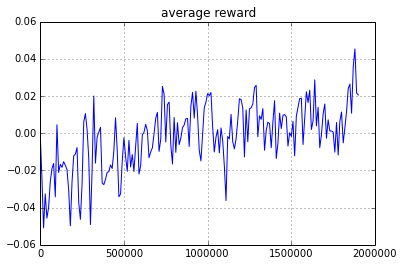

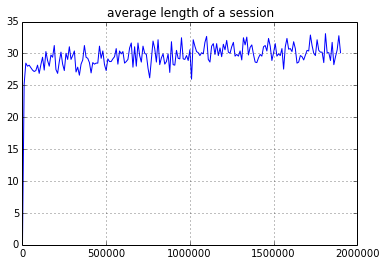

1910000 iters ( 1909999 / 1000000000 ) |sessions passed: 312 |reward: 0.00794511998554 |epsilon: 0.258539175117
1920000 iters ( 1919999 / 1000000000 ) |sessions passed: 311 |reward: 0.000635754893719 |epsilon: 0.258430780618
1930000 iters ( 1929999 / 1000000000 ) |sessions passed: 341 |reward: 0.00187682232433 |epsilon: 0.258322668032
1940000 iters ( 1939999 / 1000000000 ) |sessions passed: 339 |reward: 0.0152736567556 |epsilon: 0.258214835168
1950000 iters ( 1949999 / 1000000000 ) |sessions passed: 328 |reward: 0.00733532498309 |epsilon: 0.258107279869
1960000 iters ( 1959999 / 1000000000 ) |sessions passed: 293 |reward: -0.00669425539699 |epsilon: 0.258
1970000 iters ( 1969999 / 1000000000 ) |sessions passed: 309 |reward: 0.00594779250944 |epsilon: 0.257892993457
1980000 iters ( 1979999 / 1000000000 ) |sessions passed: 359 |reward: 0.0219467638688 |epsilon: 0.257786258162
1990000 iters ( 1989999 / 1000000000 ) |sessions passed: 320 |reward: 0.00654429950609 |epsilon: 0.257679792061
2

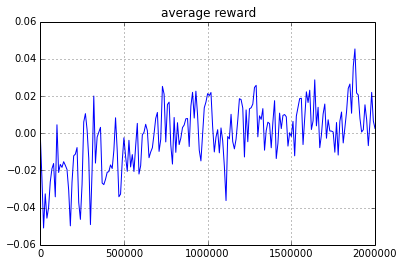

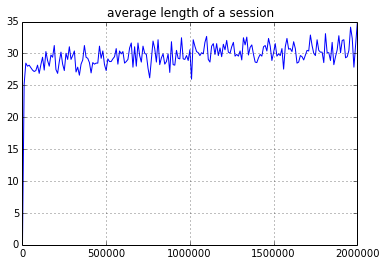

2010000 iters ( 2009999 / 1000000000 ) |sessions passed: 324 |reward: 0.016233414221 |epsilon: 0.257467659364
2020000 iters ( 2019999 / 1000000000 ) |sessions passed: 340 |reward: 0.00989775006531 |epsilon: 0.257361988789
2030000 iters ( 2029999 / 1000000000 ) |sessions passed: 314 |reward: 0.0297494186544 |epsilon: 0.257256579454
2040000 iters ( 2039999 / 1000000000 ) |sessions passed: 325 |reward: 0.0278791841006 |epsilon: 0.257151429429
2050000 iters ( 2049999 / 1000000000 ) |sessions passed: 319 |reward: 0.0130863165707 |epsilon: 0.25704653681
2060000 iters ( 2059999 / 1000000000 ) |sessions passed: 343 |reward: 0.018938816779 |epsilon: 0.256941899717
2070000 iters ( 2069999 / 1000000000 ) |sessions passed: 314 |reward: 0.0100228983546 |epsilon: 0.25683751629
2080000 iters ( 2079999 / 1000000000 ) |sessions passed: 305 |reward: 0.00346438588421 |epsilon: 0.256733384694
2090000 iters ( 2089999 / 1000000000 ) |sessions passed: 346 |reward: 0.0123153715478 |epsilon: 0.256629503116
210

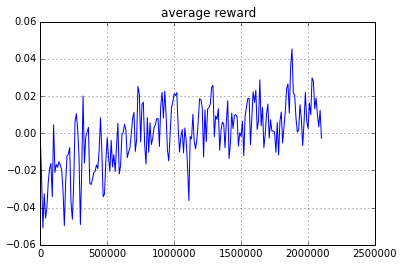

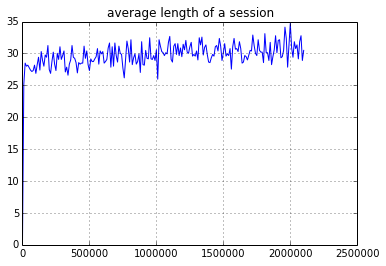

2110000 iters ( 2109999 / 1000000000 ) |sessions passed: 352 |reward: 0.0135642252014 |epsilon: 0.256422482861
2120000 iters ( 2119999 / 1000000000 ) |sessions passed: 311 |reward: 0.00659209347141 |epsilon: 0.256319340664
2130000 iters ( 2129999 / 1000000000 ) |sessions passed: 309 |reward: 0.0190956523554 |epsilon: 0.256216441442
2140000 iters ( 2139999 / 1000000000 ) |sessions passed: 308 |reward: 0.0184260981713 |epsilon: 0.256113783485
2150000 iters ( 2149999 / 1000000000 ) |sessions passed: 343 |reward: 0.0224195761112 |epsilon: 0.256011365104
2160000 iters ( 2159999 / 1000000000 ) |sessions passed: 334 |reward: 0.0240109997436 |epsilon: 0.25590918463
2170000 iters ( 2169999 / 1000000000 ) |sessions passed: 334 |reward: 0.0250082859966 |epsilon: 0.255807240412
2180000 iters ( 2179999 / 1000000000 ) |sessions passed: 335 |reward: 0.0213033416183 |epsilon: 0.255705530819
2190000 iters ( 2189999 / 1000000000 ) |sessions passed: 298 |reward: 0.0119639911428 |epsilon: 0.255604054239
2

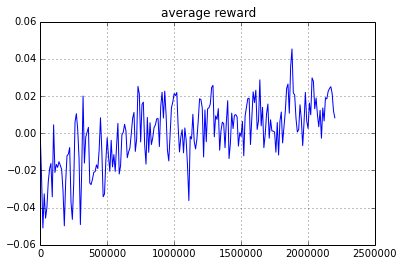

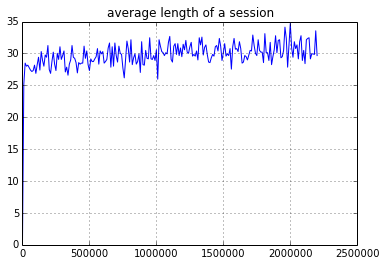

2210000 iters ( 2209999 / 1000000000 ) |sessions passed: 329 |reward: 0.0114478270946 |epsilon: 0.255401793758
2220000 iters ( 2219999 / 1000000000 ) |sessions passed: 303 |reward: 0.0122983382095 |epsilon: 0.255301006723
2230000 iters ( 2229999 / 1000000000 ) |sessions passed: 305 |reward: 0.0102855814633 |epsilon: 0.255200446431
2240000 iters ( 2239999 / 1000000000 ) |sessions passed: 309 |reward: 0.0106376704327 |epsilon: 0.255100111359
2250000 iters ( 2249999 / 1000000000 ) |sessions passed: 325 |reward: 0.0209834671333 |epsilon: 0.255
2260000 iters ( 2259999 / 1000000000 ) |sessions passed: 303 |reward: 0.0178434998954 |epsilon: 0.254900110865
2270000 iters ( 2269999 / 1000000000 ) |sessions passed: 319 |reward: 0.0338381356067 |epsilon: 0.25480044248
2280000 iters ( 2279999 / 1000000000 ) |sessions passed: 327 |reward: 0.0221263507515 |epsilon: 0.254700993388
2290000 iters ( 2289999 / 1000000000 ) |sessions passed: 322 |reward: 0.0295337082043 |epsilon: 0.254601762149
2300000 ite

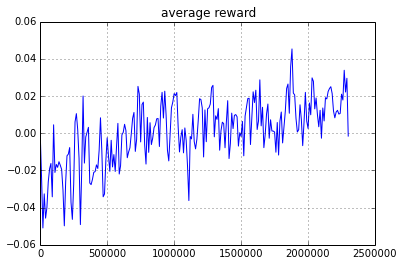

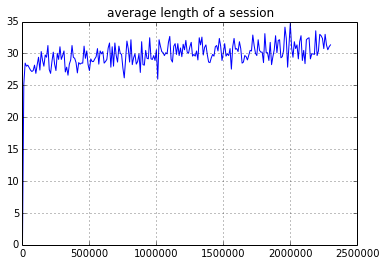

2310000 iters ( 2309999 / 1000000000 ) |sessions passed: 326 |reward: 0.0053275843997 |epsilon: 0.254403947539
2320000 iters ( 2319999 / 1000000000 ) |sessions passed: 350 |reward: 0.0161317307275 |epsilon: 0.254305361365
2330000 iters ( 2329999 / 1000000000 ) |sessions passed: 331 |reward: 0.00752554137745 |epsilon: 0.254206987433
2340000 iters ( 2339999 / 1000000000 ) |sessions passed: 330 |reward: -0.000221881952315 |epsilon: 0.254108824378
2350000 iters ( 2349999 / 1000000000 ) |sessions passed: 337 |reward: -0.0140807285804 |epsilon: 0.25401087085
2360000 iters ( 2359999 / 1000000000 ) |sessions passed: 323 |reward: -0.010249911034 |epsilon: 0.253913125513
2370000 iters ( 2369999 / 1000000000 ) |sessions passed: 321 |reward: -0.00459445801864 |epsilon: 0.253815587045
2380000 iters ( 2379999 / 1000000000 ) |sessions passed: 327 |reward: -0.00640713176717 |epsilon: 0.253718254138
2390000 iters ( 2389999 / 1000000000 ) |sessions passed: 338 |reward: 0.0188827283251 |epsilon: 0.253621

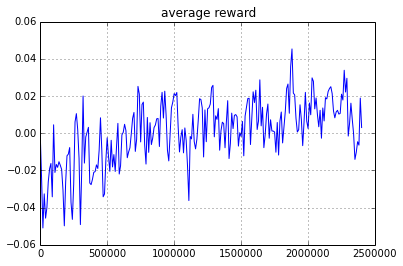

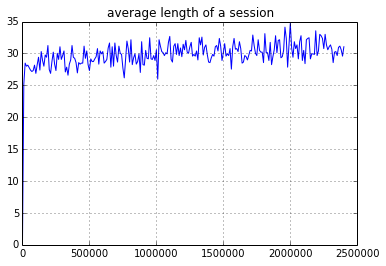

2410000 iters ( 2409999 / 1000000000 ) |sessions passed: 314 |reward: 0.00334922134816 |epsilon: 0.253427475911
2420000 iters ( 2419999 / 1000000000 ) |sessions passed: 347 |reward: 0.0128576955795 |epsilon: 0.253330952442
2430000 iters ( 2429999 / 1000000000 ) |sessions passed: 318 |reward: 0.0150616718804 |epsilon: 0.253234628196
2440000 iters ( 2439999 / 1000000000 ) |sessions passed: 312 |reward: 0.00706294450811 |epsilon: 0.253138501945
2450000 iters ( 2449999 / 1000000000 ) |sessions passed: 315 |reward: 0.000115672704958 |epsilon: 0.253042572473
2460000 iters ( 2459999 / 1000000000 ) |sessions passed: 345 |reward: 0.013353568935 |epsilon: 0.252946838576
2470000 iters ( 2469999 / 1000000000 ) |sessions passed: 336 |reward: 0.0256348529752 |epsilon: 0.252851299063
2480000 iters ( 2479999 / 1000000000 ) |sessions passed: 320 |reward: 0.0169264583349 |epsilon: 0.252755952756
2490000 iters ( 2489999 / 1000000000 ) |sessions passed: 320 |reward: 0.0213332152202 |epsilon: 0.25266079848

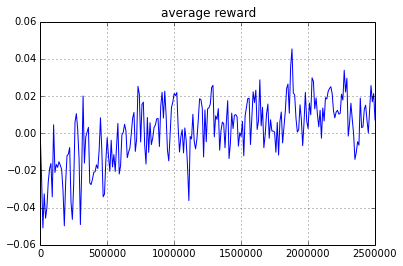

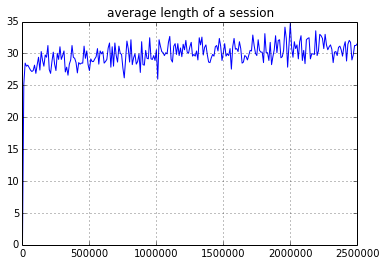

2510000 iters ( 2509999 / 1000000000 ) |sessions passed: 330 |reward: -0.00238703362344 |epsilon: 0.252471061447
2520000 iters ( 2519999 / 1000000000 ) |sessions passed: 341 |reward: 0.00417882142421 |epsilon: 0.252376476401
2530000 iters ( 2529999 / 1000000000 ) |sessions passed: 298 |reward: -0.0189492339295 |epsilon: 0.252282078838
2540000 iters ( 2539999 / 1000000000 ) |sessions passed: 304 |reward: -0.00757356487525 |epsilon: 0.252187867648
2550000 iters ( 2549999 / 1000000000 ) |sessions passed: 311 |reward: 0.00783366546921 |epsilon: 0.252093841732
2560000 iters ( 2559999 / 1000000000 ) |sessions passed: 335 |reward: 0.0201101700541 |epsilon: 0.252
2570000 iters ( 2569999 / 1000000000 ) |sessions passed: 347 |reward: 0.0225577081629 |epsilon: 0.251906341374
2580000 iters ( 2579999 / 1000000000 ) |sessions passed: 314 |reward: 0.0130863176498 |epsilon: 0.251812864787
2590000 iters ( 2589999 / 1000000000 ) |sessions passed: 329 |reward: 0.0190463385065 |epsilon: 0.251719569182
260

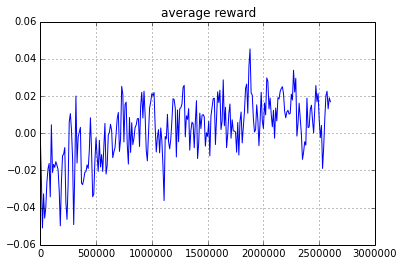

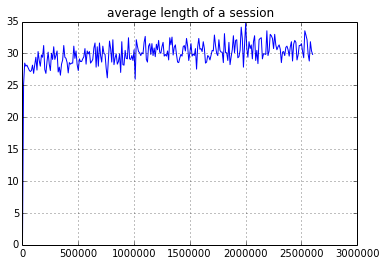

2610000 iters ( 2609999 / 1000000000 ) |sessions passed: 326 |reward: 0.0103426667357 |epsilon: 0.251533516736
2620000 iters ( 2619999 / 1000000000 ) |sessions passed: 318 |reward: 0.0123782923329 |epsilon: 0.251440757831
2630000 iters ( 2629999 / 1000000000 ) |sessions passed: 331 |reward: -0.00152833549677 |epsilon: 0.251348175779
2640000 iters ( 2639999 / 1000000000 ) |sessions passed: 343 |reward: 0.0143748475183 |epsilon: 0.251255769572
2650000 iters ( 2649999 / 1000000000 ) |sessions passed: 324 |reward: 0.0195023235192 |epsilon: 0.251163538212
2660000 iters ( 2659999 / 1000000000 ) |sessions passed: 337 |reward: 0.0086036272618 |epsilon: 0.251071480709
2670000 iters ( 2669999 / 1000000000 ) |sessions passed: 331 |reward: 0.00800338018397 |epsilon: 0.250979596085
2680000 iters ( 2679999 / 1000000000 ) |sessions passed: 322 |reward: 0.0120259319457 |epsilon: 0.250887883369
2690000 iters ( 2689999 / 1000000000 ) |sessions passed: 309 |reward: 0.0212489157408 |epsilon: 0.25079634159

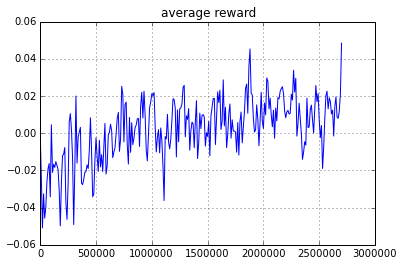

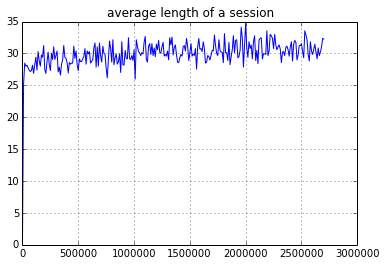

2710000 iters ( 2709999 / 1000000000 ) |sessions passed: 336 |reward: 0.0376907695462 |epsilon: 0.250613767101
2720000 iters ( 2719999 / 1000000000 ) |sessions passed: 333 |reward: 0.0299724915902 |epsilon: 0.250522732493
2730000 iters ( 2729999 / 1000000000 ) |sessions passed: 339 |reward: 0.0429273821012 |epsilon: 0.250431865074
2740000 iters ( 2739999 / 1000000000 ) |sessions passed: 344 |reward: 0.045087338002 |epsilon: 0.250341163928
2750000 iters ( 2749999 / 1000000000 ) |sessions passed: 333 |reward: 0.0432073472804 |epsilon: 0.250250628145
2760000 iters ( 2759999 / 1000000000 ) |sessions passed: 316 |reward: 0.0338835094971 |epsilon: 0.250160256822
2770000 iters ( 2769999 / 1000000000 ) |sessions passed: 329 |reward: 0.043177360551 |epsilon: 0.250070049069
2780000 iters ( 2779999 / 1000000000 ) |sessions passed: 338 |reward: 0.0465070703656 |epsilon: 0.249980003998
2790000 iters ( 2789999 / 1000000000 ) |sessions passed: 326 |reward: 0.0216648436385 |epsilon: 0.249890120735
280

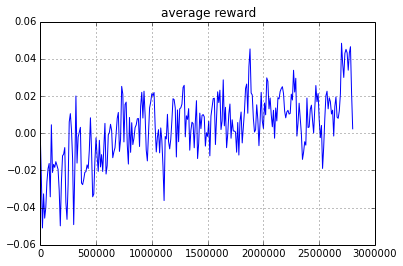

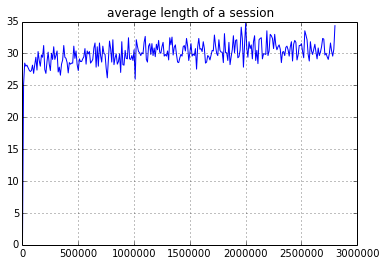

2810000 iters ( 2809999 / 1000000000 ) |sessions passed: 348 |reward: 0.024096717372 |epsilon: 0.249710836157
2820000 iters ( 2819999 / 1000000000 ) |sessions passed: 310 |reward: 0.00993658811181 |epsilon: 0.249621433129
2830000 iters ( 2829999 / 1000000000 ) |sessions passed: 296 |reward: 0.00326763185818 |epsilon: 0.249532188476
2840000 iters ( 2839999 / 1000000000 ) |sessions passed: 311 |reward: 0.00598832804516 |epsilon: 0.249443101361
2850000 iters ( 2849999 / 1000000000 ) |sessions passed: 308 |reward: 0.0111812035252 |epsilon: 0.249354170952
2860000 iters ( 2859999 / 1000000000 ) |sessions passed: 310 |reward: 0.0170070381929 |epsilon: 0.249265396424
2870000 iters ( 2869999 / 1000000000 ) |sessions passed: 334 |reward: 0.0343125650262 |epsilon: 0.249176776962
2880000 iters ( 2879999 / 1000000000 ) |sessions passed: 327 |reward: 0.0241319439825 |epsilon: 0.249088311755
2890000 iters ( 2889999 / 1000000000 ) |sessions passed: 327 |reward: 0.0339003172485 |epsilon: 0.249
2900000 

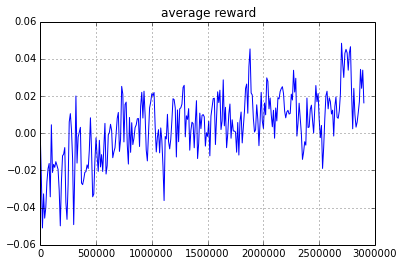

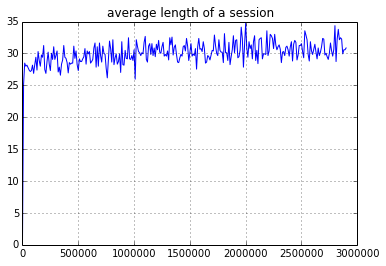

2910000 iters ( 2909999 / 1000000000 ) |sessions passed: 329 |reward: 0.0179217892673 |epsilon: 0.248823833672
2920000 iters ( 2919999 / 1000000000 ) |sessions passed: 348 |reward: 0.0317591725664 |epsilon: 0.248735977528
2930000 iters ( 2929999 / 1000000000 ) |sessions passed: 312 |reward: 0.0153182414003 |epsilon: 0.248648271694
2940000 iters ( 2939999 / 1000000000 ) |sessions passed: 368 |reward: 0.0179372673008 |epsilon: 0.248560715402
2950000 iters ( 2949999 / 1000000000 ) |sessions passed: 332 |reward: 0.023189778258 |epsilon: 0.248473307888
2960000 iters ( 2959999 / 1000000000 ) |sessions passed: 343 |reward: 0.0475352445743 |epsilon: 0.248386048398
2970000 iters ( 2969999 / 1000000000 ) |sessions passed: 342 |reward: 0.0525557537014 |epsilon: 0.248298936181
2980000 iters ( 2979999 / 1000000000 ) |sessions passed: 335 |reward: 0.0384865662615 |epsilon: 0.248211970495
2990000 iters ( 2989999 / 1000000000 ) |sessions passed: 328 |reward: 0.035518774029 |epsilon: 0.248125150603
300

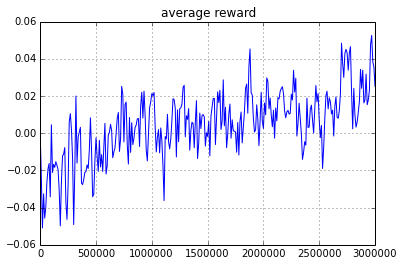

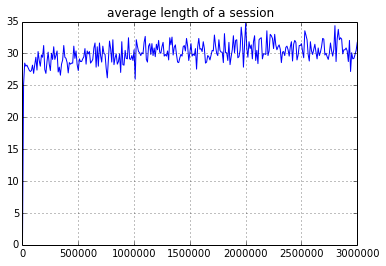

3010000 iters ( 3009999 / 1000000000 ) |sessions passed: 333 |reward: 0.031046466007 |epsilon: 0.247951945281
3020000 iters ( 3019999 / 1000000000 ) |sessions passed: 314 |reward: -0.0130076145114 |epsilon: 0.247865558409
3030000 iters ( 3029999 / 1000000000 ) |sessions passed: 310 |reward: 0.0197450850522 |epsilon: 0.247779314443
3040000 iters ( 3039999 / 1000000000 ) |sessions passed: 333 |reward: 0.0265877354916 |epsilon: 0.247693212678
3050000 iters ( 3049999 / 1000000000 ) |sessions passed: 333 |reward: 0.00784994170955 |epsilon: 0.24760725241
3060000 iters ( 3059999 / 1000000000 ) |sessions passed: 345 |reward: 0.0163496194636 |epsilon: 0.247521432946
3070000 iters ( 3069999 / 1000000000 ) |sessions passed: 324 |reward: 0.0006312768474 |epsilon: 0.247435753596
3080000 iters ( 3079999 / 1000000000 ) |sessions passed: 304 |reward: 0.00859270869456 |epsilon: 0.247350213676
3090000 iters ( 3089999 / 1000000000 ) |sessions passed: 339 |reward: 0.0254438496439 |epsilon: 0.247264812506


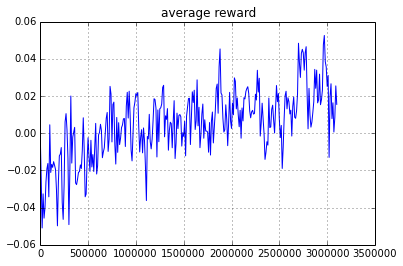

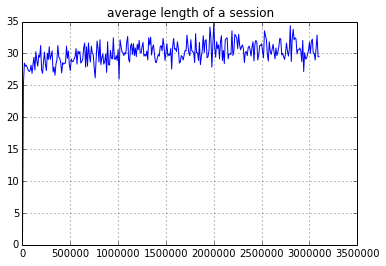

3110000 iters ( 3109999 / 1000000000 ) |sessions passed: 314 |reward: 0.0006008173652 |epsilon: 0.247094423734
3120000 iters ( 3119999 / 1000000000 ) |sessions passed: 311 |reward: 0.00603930068663 |epsilon: 0.247009434802
3130000 iters ( 3129999 / 1000000000 ) |sessions passed: 332 |reward: 0.0294908486282 |epsilon: 0.246924581961
3140000 iters ( 3139999 / 1000000000 ) |sessions passed: 321 |reward: 0.0237398733185 |epsilon: 0.24683986456
3150000 iters ( 3149999 / 1000000000 ) |sessions passed: 295 |reward: -0.0031762729312 |epsilon: 0.246755281952
3160000 iters ( 3159999 / 1000000000 ) |sessions passed: 315 |reward: 0.0045518646449 |epsilon: 0.246670833496
3170000 iters ( 3169999 / 1000000000 ) |sessions passed: 323 |reward: 0.0112381360612 |epsilon: 0.246586518556
3180000 iters ( 3179999 / 1000000000 ) |sessions passed: 325 |reward: -0.0142118508053 |epsilon: 0.2465023365
3190000 iters ( 3189999 / 1000000000 ) |sessions passed: 333 |reward: 0.0235651889936 |epsilon: 0.246418286702
3

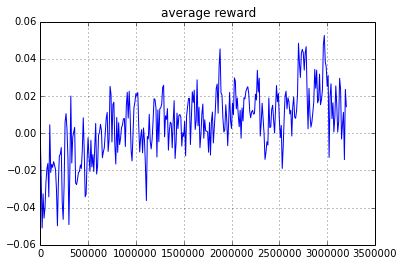

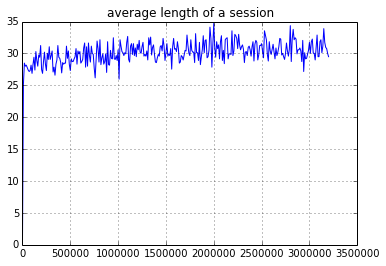

3210000 iters ( 3209999 / 1000000000 ) |sessions passed: 325 |reward: 0.00215741923513 |epsilon: 0.246250581398
3220000 iters ( 3219999 / 1000000000 ) |sessions passed: 352 |reward: 0.0284261602547 |epsilon: 0.246166924665
3230000 iters ( 3229999 / 1000000000 ) |sessions passed: 338 |reward: 0.0236453870608 |epsilon: 0.246083397733
3240000 iters ( 3239999 / 1000000000 ) |sessions passed: 353 |reward: 0.0382489962546 |epsilon: 0.246
3250000 iters ( 3249999 / 1000000000 ) |sessions passed: 302 |reward: 0.0137676035423 |epsilon: 0.245916730868
3260000 iters ( 3259999 / 1000000000 ) |sessions passed: 347 |reward: 0.044249308049 |epsilon: 0.245833589744
3270000 iters ( 3269999 / 1000000000 ) |sessions passed: 333 |reward: 0.0169136089667 |epsilon: 0.24575057604
3280000 iters ( 3279999 / 1000000000 ) |sessions passed: 332 |reward: 0.00709727824607 |epsilon: 0.245667689171
3290000 iters ( 3289999 / 1000000000 ) |sessions passed: 322 |reward: 0.000106803723257 |epsilon: 0.245584928558
3300000 

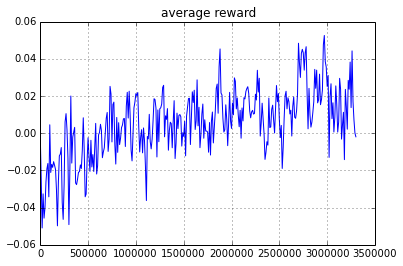

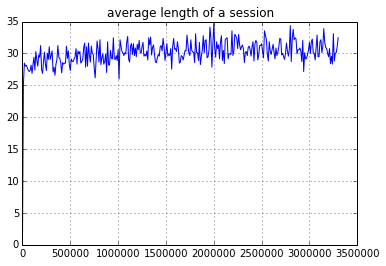

3310000 iters ( 3309999 / 1000000000 ) |sessions passed: 311 |reward: 0.00825444188335 |epsilon: 0.245419783804
3320000 iters ( 3319999 / 1000000000 ) |sessions passed: 306 |reward: 0.020402170229 |epsilon: 0.245337398525
3330000 iters ( 3329999 / 1000000000 ) |sessions passed: 344 |reward: 0.0155654079231 |epsilon: 0.245255137227
3340000 iters ( 3339999 / 1000000000 ) |sessions passed: 343 |reward: 0.0221076888229 |epsilon: 0.245172999353
3350000 iters ( 3349999 / 1000000000 ) |sessions passed: 302 |reward: 0.0158037884542 |epsilon: 0.245090984347
3360000 iters ( 3359999 / 1000000000 ) |sessions passed: 306 |reward: 0.023246213799 |epsilon: 0.245009091661
3370000 iters ( 3369999 / 1000000000 ) |sessions passed: 313 |reward: 0.014992493662 |epsilon: 0.244927320748
3380000 iters ( 3379999 / 1000000000 ) |sessions passed: 322 |reward: 0.0202095479968 |epsilon: 0.244845671067
3390000 iters ( 3389999 / 1000000000 ) |sessions passed: 341 |reward: 0.0349176190353 |epsilon: 0.244764142081
340

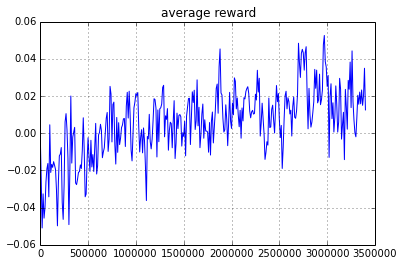

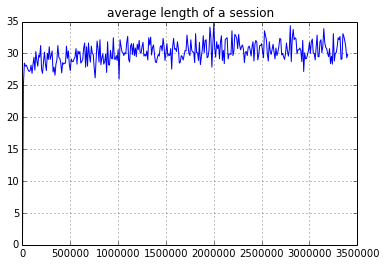

3410000 iters ( 3409999 / 1000000000 ) |sessions passed: 351 |reward: 0.0310428570332 |epsilon: 0.244601444062
3420000 iters ( 3419999 / 1000000000 ) |sessions passed: 319 |reward: 0.0250795316554 |epsilon: 0.244520273973
3430000 iters ( 3429999 / 1000000000 ) |sessions passed: 298 |reward: 0.0213783366356 |epsilon: 0.244439222468
3440000 iters ( 3439999 / 1000000000 ) |sessions passed: 320 |reward: 0.0361200205869 |epsilon: 0.244358289027
3450000 iters ( 3449999 / 1000000000 ) |sessions passed: 313 |reward: 0.0198659245716 |epsilon: 0.244277473137
3460000 iters ( 3459999 / 1000000000 ) |sessions passed: 319 |reward: 0.0317109825658 |epsilon: 0.244196774287
3470000 iters ( 3469999 / 1000000000 ) |sessions passed: 340 |reward: 0.0385086456729 |epsilon: 0.244116191969
3480000 iters ( 3479999 / 1000000000 ) |sessions passed: 322 |reward: 0.0340183258082 |epsilon: 0.244035725681
3490000 iters ( 3489999 / 1000000000 ) |sessions passed: 298 |reward: 0.0340724943175 |epsilon: 0.243955374923
3

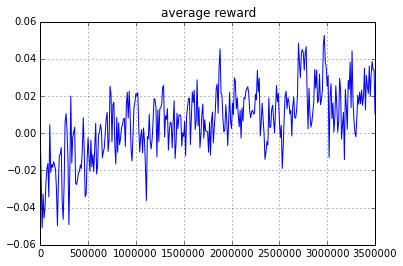

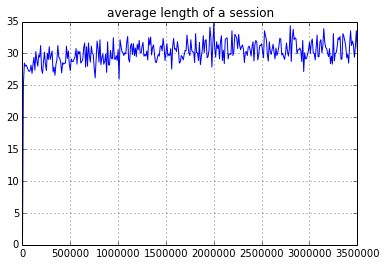

3510000 iters ( 3509999 / 1000000000 ) |sessions passed: 323 |reward: 0.0180654510799 |epsilon: 0.243795018014
3520000 iters ( 3519999 / 1000000000 ) |sessions passed: 334 |reward: 0.00589188188162 |epsilon: 0.243715010882
3530000 iters ( 3529999 / 1000000000 ) |sessions passed: 336 |reward: 0.0225721453427 |epsilon: 0.243635117316
3540000 iters ( 3539999 / 1000000000 ) |sessions passed: 311 |reward: 0.0136097489262 |epsilon: 0.243555336833
3550000 iters ( 3549999 / 1000000000 ) |sessions passed: 334 |reward: 0.029943904788 |epsilon: 0.243475668956
3560000 iters ( 3559999 / 1000000000 ) |sessions passed: 318 |reward: 0.0436433934993 |epsilon: 0.243396113208
3570000 iters ( 3569999 / 1000000000 ) |sessions passed: 331 |reward: 0.0477229405595 |epsilon: 0.243316669117
3580000 iters ( 3579999 / 1000000000 ) |sessions passed: 311 |reward: 0.0458803157871 |epsilon: 0.243237336215
3590000 iters ( 3589999 / 1000000000 ) |sessions passed: 314 |reward: 0.0400418226245 |epsilon: 0.243158114036
3

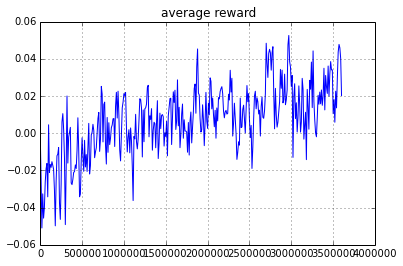

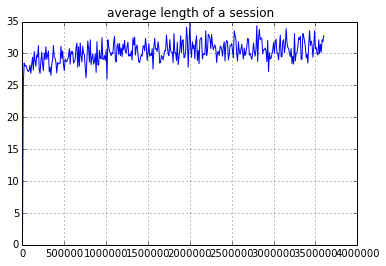

3610000 iters ( 3609999 / 1000000000 ) |sessions passed: 306 |reward: 0.00117165936862 |epsilon: 0.243
3620000 iters ( 3619999 / 1000000000 ) |sessions passed: 305 |reward: 0.00945393758755 |epsilon: 0.242921107229
3630000 iters ( 3629999 / 1000000000 ) |sessions passed: 310 |reward: 0.0168243506164 |epsilon: 0.24284232335
3640000 iters ( 3639999 / 1000000000 ) |sessions passed: 352 |reward: 0.0218924635282 |epsilon: 0.242763647915
3650000 iters ( 3649999 / 1000000000 ) |sessions passed: 307 |reward: -0.0012422019228 |epsilon: 0.242685080476
3660000 iters ( 3659999 / 1000000000 ) |sessions passed: 310 |reward: 0.00799092937016 |epsilon: 0.242606620591
3670000 iters ( 3669999 / 1000000000 ) |sessions passed: 341 |reward: 0.0488208604195 |epsilon: 0.242528267818
3680000 iters ( 3679999 / 1000000000 ) |sessions passed: 308 |reward: 0.0254834340787 |epsilon: 0.24245002172
3690000 iters ( 3689999 / 1000000000 ) |sessions passed: 348 |reward: 0.0206363410761 |epsilon: 0.242371881863
3700000 

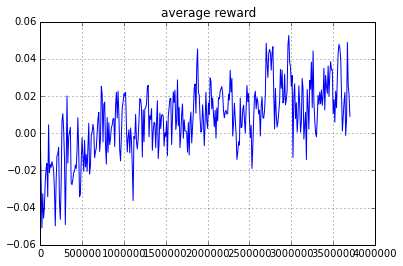

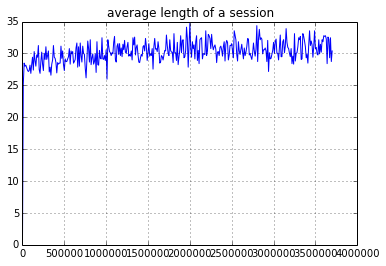

3710000 iters ( 3709999 / 1000000000 ) |sessions passed: 340 |reward: 0.0336343506006 |epsilon: 0.242215919147
3720000 iters ( 3719999 / 1000000000 ) |sessions passed: 320 |reward: 0.0113256199178 |epsilon: 0.242138095434
3730000 iters ( 3729999 / 1000000000 ) |sessions passed: 334 |reward: 0.0169867009748 |epsilon: 0.242060376253
3740000 iters ( 3739999 / 1000000000 ) |sessions passed: 343 |reward: 0.0272893379735 |epsilon: 0.241982761183
3750000 iters ( 3749999 / 1000000000 ) |sessions passed: 317 |reward: 0.0235733233599 |epsilon: 0.241905249807
3760000 iters ( 3759999 / 1000000000 ) |sessions passed: 327 |reward: 0.0182296882903 |epsilon: 0.241827841711
3770000 iters ( 3769999 / 1000000000 ) |sessions passed: 330 |reward: 0.0394238605716 |epsilon: 0.241750536483
3780000 iters ( 3779999 / 1000000000 ) |sessions passed: 313 |reward: 0.0156747369657 |epsilon: 0.241673333714
3790000 iters ( 3789999 / 1000000000 ) |sessions passed: 331 |reward: 0.0223463619367 |epsilon: 0.241596232998
3

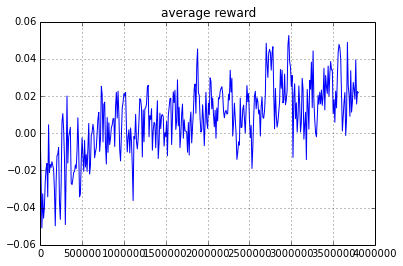

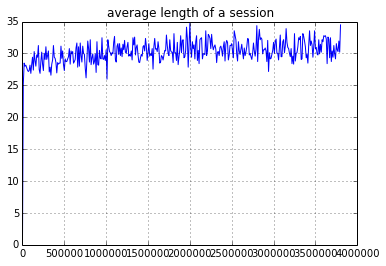

3810000 iters ( 3809999 / 1000000000 ) |sessions passed: 326 |reward: 0.0328218651204 |epsilon: 0.241442336112
3820000 iters ( 3819999 / 1000000000 ) |sessions passed: 324 |reward: 0.0166815839661 |epsilon: 0.241365539143
3830000 iters ( 3829999 / 1000000000 ) |sessions passed: 311 |reward: 0.00663575207761 |epsilon: 0.241288842628
3840000 iters ( 3839999 / 1000000000 ) |sessions passed: 311 |reward: 0.0215865854846 |epsilon: 0.241212246173
3850000 iters ( 3849999 / 1000000000 ) |sessions passed: 288 |reward: -0.0118234438917 |epsilon: 0.241135749389
3860000 iters ( 3859999 / 1000000000 ) |sessions passed: 319 |reward: -4.58844421252e-05 |epsilon: 0.241059351887
3870000 iters ( 3869999 / 1000000000 ) |sessions passed: 322 |reward: 0.0269608035582 |epsilon: 0.240983053281
3880000 iters ( 3879999 / 1000000000 ) |sessions passed: 321 |reward: 0.0270626020859 |epsilon: 0.240906853189
3890000 iters ( 3889999 / 1000000000 ) |sessions passed: 331 |reward: 0.0314473493116 |epsilon: 0.240830751

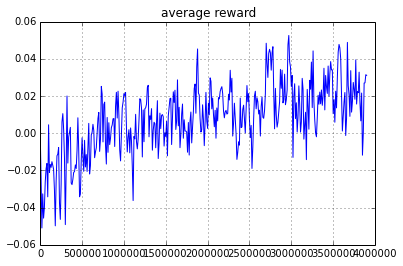

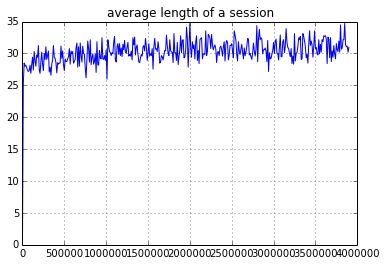

3910000 iters ( 3909999 / 1000000000 ) |sessions passed: 324 |reward: 0.0336099673651 |epsilon: 0.2406788402
3920000 iters ( 3919999 / 1000000000 ) |sessions passed: 308 |reward: 0.017226532535 |epsilon: 0.24060303038
3930000 iters ( 3929999 / 1000000000 ) |sessions passed: 313 |reward: 0.0229462061956 |epsilon: 0.240527317195
3940000 iters ( 3939999 / 1000000000 ) |sessions passed: 305 |reward: 0.0276117209293 |epsilon: 0.240451700276
3950000 iters ( 3949999 / 1000000000 ) |sessions passed: 302 |reward: 0.0138479238225 |epsilon: 0.240376179257
3960000 iters ( 3959999 / 1000000000 ) |sessions passed: 306 |reward: 0.0256900167894 |epsilon: 0.240300753774
3970000 iters ( 3969999 / 1000000000 ) |sessions passed: 301 |reward: 0.0164643357611 |epsilon: 0.240225423464
3980000 iters ( 3979999 / 1000000000 ) |sessions passed: 326 |reward: 0.0420591699559 |epsilon: 0.24015018797
3990000 iters ( 3989999 / 1000000000 ) |sessions passed: 330 |reward: 0.0331438613261 |epsilon: 0.240075046934
400000

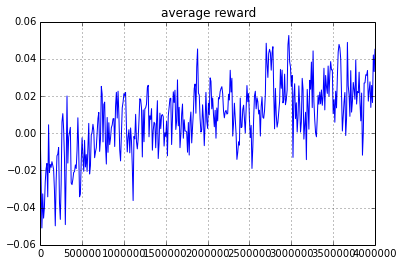

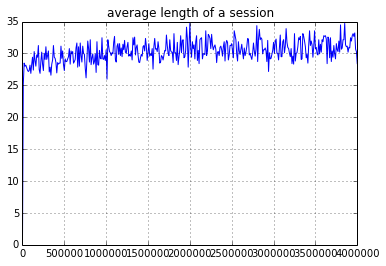

4010000 iters ( 4009999 / 1000000000 ) |sessions passed: 328 |reward: 0.0219281211872 |epsilon: 0.239925046816
4020000 iters ( 4019999 / 1000000000 ) |sessions passed: 323 |reward: 0.0282811159644 |epsilon: 0.239850187033
4030000 iters ( 4029999 / 1000000000 ) |sessions passed: 333 |reward: 0.0329481314458 |epsilon: 0.2397754203
4040000 iters ( 4039999 / 1000000000 ) |sessions passed: 318 |reward: 0.0221312954288 |epsilon: 0.239700746273
4050000 iters ( 4049999 / 1000000000 ) |sessions passed: 311 |reward: 0.0239080876601 |epsilon: 0.239626164608
4060000 iters ( 4059999 / 1000000000 ) |sessions passed: 304 |reward: 0.028533559366 |epsilon: 0.239551674961
4070000 iters ( 4069999 / 1000000000 ) |sessions passed: 341 |reward: 0.0383430546851 |epsilon: 0.239477276995
4080000 iters ( 4079999 / 1000000000 ) |sessions passed: 308 |reward: 0.0230637468165 |epsilon: 0.23940297037
4090000 iters ( 4089999 / 1000000000 ) |sessions passed: 332 |reward: 0.0310857798834 |epsilon: 0.239328754752
41000

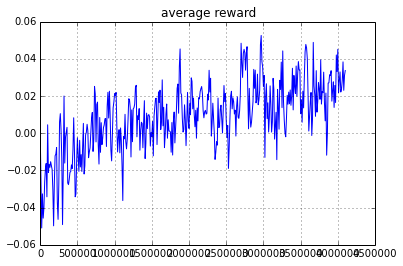

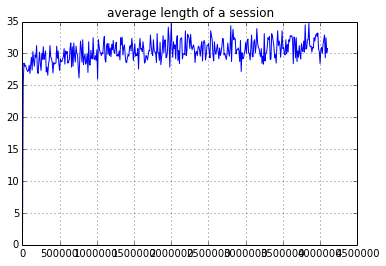

4110000 iters ( 4109999 / 1000000000 ) |sessions passed: 315 |reward: 0.0330403883577 |epsilon: 0.239180595202
4120000 iters ( 4119999 / 1000000000 ) |sessions passed: 323 |reward: 0.0293624236049 |epsilon: 0.239106650609
4130000 iters ( 4129999 / 1000000000 ) |sessions passed: 318 |reward: 0.00863093916808 |epsilon: 0.239032795701
4140000 iters ( 4139999 / 1000000000 ) |sessions passed: 328 |reward: 0.018200923498 |epsilon: 0.238959030152
4150000 iters ( 4149999 / 1000000000 ) |sessions passed: 317 |reward: 0.0320842295909 |epsilon: 0.238885353638
4160000 iters ( 4159999 / 1000000000 ) |sessions passed: 342 |reward: 0.043037000072 |epsilon: 0.238811765837
4170000 iters ( 4169999 / 1000000000 ) |sessions passed: 311 |reward: 0.0470076922065 |epsilon: 0.23873826643
4180000 iters ( 4179999 / 1000000000 ) |sessions passed: 313 |reward: 0.0468277296895 |epsilon: 0.238664855099
4190000 iters ( 4189999 / 1000000000 ) |sessions passed: 336 |reward: 0.0265087587646 |epsilon: 0.238591531529
420

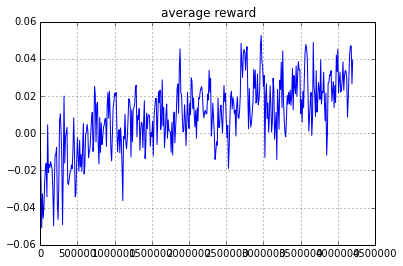

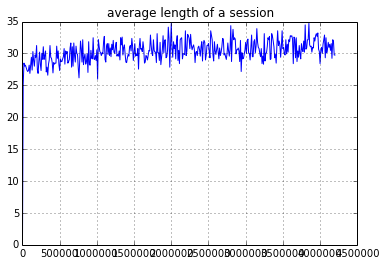

4210000 iters ( 4209999 / 1000000000 ) |sessions passed: 349 |reward: 0.0476666041697 |epsilon: 0.238445146414
4220000 iters ( 4219999 / 1000000000 ) |sessions passed: 303 |reward: 0.042928488593 |epsilon: 0.238372084247
4230000 iters ( 4229999 / 1000000000 ) |sessions passed: 319 |reward: 0.0324845911052 |epsilon: 0.238299108596
4240000 iters ( 4239999 / 1000000000 ) |sessions passed: 291 |reward: 0.0141959955251 |epsilon: 0.238226219154
4250000 iters ( 4249999 / 1000000000 ) |sessions passed: 324 |reward: 0.0336200967395 |epsilon: 0.238153415616
4260000 iters ( 4259999 / 1000000000 ) |sessions passed: 323 |reward: 0.0210223960658 |epsilon: 0.238080697678
4270000 iters ( 4269999 / 1000000000 ) |sessions passed: 302 |reward: 0.0130380323505 |epsilon: 0.238008065041
4280000 iters ( 4279999 / 1000000000 ) |sessions passed: 309 |reward: 0.00157435940783 |epsilon: 0.237935517403
4290000 iters ( 4289999 / 1000000000 ) |sessions passed: 319 |reward: 0.0281848144346 |epsilon: 0.237863054468
4

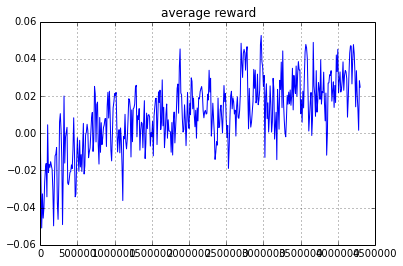

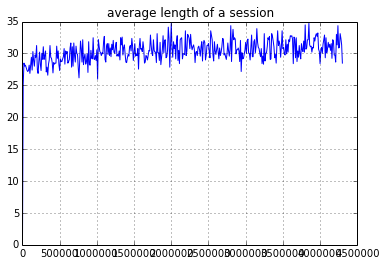

4310000 iters ( 4309999 / 1000000000 ) |sessions passed: 298 |reward: 0.0249144820041 |epsilon: 0.237718381524
4320000 iters ( 4319999 / 1000000000 ) |sessions passed: 337 |reward: 0.0386200968969 |epsilon: 0.237646170928
4330000 iters ( 4329999 / 1000000000 ) |sessions passed: 352 |reward: 0.0488875764304 |epsilon: 0.23757404386
4340000 iters ( 4339999 / 1000000000 ) |sessions passed: 332 |reward: 0.0269372726015 |epsilon: 0.237502000032
4350000 iters ( 4349999 / 1000000000 ) |sessions passed: 340 |reward: 0.0303160967629 |epsilon: 0.237430039156
4360000 iters ( 4359999 / 1000000000 ) |sessions passed: 315 |reward: 0.0115195133069 |epsilon: 0.237358160947
4370000 iters ( 4369999 / 1000000000 ) |sessions passed: 310 |reward: 0.00246012225184 |epsilon: 0.237286365119
4380000 iters ( 4379999 / 1000000000 ) |sessions passed: 302 |reward: 0.0259784814423 |epsilon: 0.237214651391
4390000 iters ( 4389999 / 1000000000 ) |sessions passed: 337 |reward: 0.0314047029205 |epsilon: 0.237143019481
4

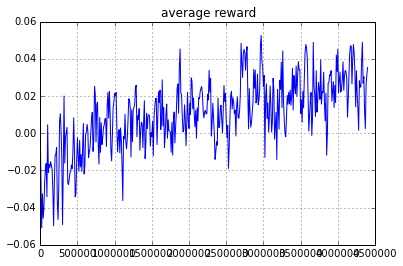

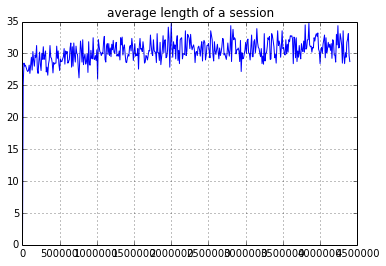

4410000 iters ( 4409999 / 1000000000 ) |sessions passed: 315 |reward: 0.0319221033486 |epsilon: 0.237
4420000 iters ( 4419999 / 1000000000 ) |sessions passed: 331 |reward: 0.0250722188474 |epsilon: 0.236928611875
4430000 iters ( 4429999 / 1000000000 ) |sessions passed: 325 |reward: 0.0144672993306 |epsilon: 0.23685730446
4440000 iters ( 4439999 / 1000000000 ) |sessions passed: 331 |reward: 0.0362532714802 |epsilon: 0.236786077483
4450000 iters ( 4449999 / 1000000000 ) |sessions passed: 308 |reward: 0.0333040965931 |epsilon: 0.236714930671
4460000 iters ( 4459999 / 1000000000 ) |sessions passed: 333 |reward: 0.0427919723427 |epsilon: 0.236643863754
4470000 iters ( 4469999 / 1000000000 ) |sessions passed: 340 |reward: 0.0678253938586 |epsilon: 0.236572876464
4480000 iters ( 4479999 / 1000000000 ) |sessions passed: 328 |reward: 0.0631544387001 |epsilon: 0.236501968534
4490000 iters ( 4489999 / 1000000000 ) |sessions passed: 321 |reward: 0.0533879732766 |epsilon: 0.236431139699
4500000 ite

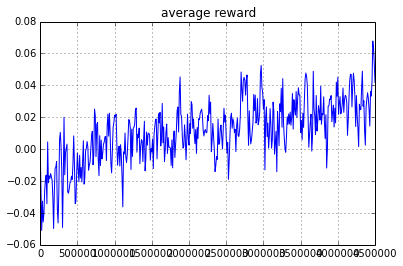

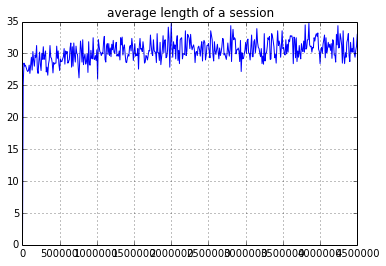

4510000 iters ( 4509999 / 1000000000 ) |sessions passed: 335 |reward: 0.0281731496622 |epsilon: 0.236289718255
4520000 iters ( 4519999 / 1000000000 ) |sessions passed: 322 |reward: 0.0190628131411 |epsilon: 0.236219125124
4530000 iters ( 4529999 / 1000000000 ) |sessions passed: 310 |reward: 0.0194176682874 |epsilon: 0.236148610039
4540000 iters ( 4539999 / 1000000000 ) |sessions passed: 335 |reward: 0.0384323130649 |epsilon: 0.236078172742
4550000 iters ( 4549999 / 1000000000 ) |sessions passed: 317 |reward: 0.0204625587555 |epsilon: 0.236007812977
4560000 iters ( 4559999 / 1000000000 ) |sessions passed: 336 |reward: 0.0156673697825 |epsilon: 0.235937530488
4570000 iters ( 4569999 / 1000000000 ) |sessions passed: 353 |reward: 0.0410820299478 |epsilon: 0.235867325021
4580000 iters ( 4579999 / 1000000000 ) |sessions passed: 306 |reward: 0.0248347867566 |epsilon: 0.235797196323
4590000 iters ( 4589999 / 1000000000 ) |sessions passed: 352 |reward: 0.0363339026978 |epsilon: 0.235727144143
4

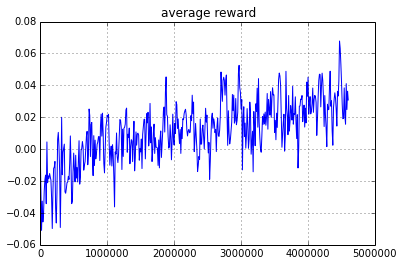

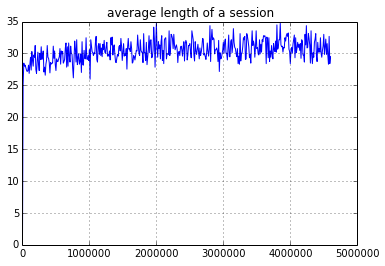

4610000 iters ( 4609999 / 1000000000 ) |sessions passed: 317 |reward: 0.0084726074801 |epsilon: 0.235587268339
4620000 iters ( 4619999 / 1000000000 ) |sessions passed: 307 |reward: 0.0156237226047 |epsilon: 0.235517444219
4630000 iters ( 4629999 / 1000000000 ) |sessions passed: 303 |reward: 0.0214173116413 |epsilon: 0.235447695626
4640000 iters ( 4639999 / 1000000000 ) |sessions passed: 329 |reward: 0.0318592304087 |epsilon: 0.235378022314
4650000 iters ( 4649999 / 1000000000 ) |sessions passed: 329 |reward: 0.0380184885933 |epsilon: 0.235308424041
4660000 iters ( 4659999 / 1000000000 ) |sessions passed: 322 |reward: 0.0296354883835 |epsilon: 0.235238900565
4670000 iters ( 4669999 / 1000000000 ) |sessions passed: 314 |reward: 0.039248962609 |epsilon: 0.235169451645
4680000 iters ( 4679999 / 1000000000 ) |sessions passed: 316 |reward: 0.0356395378587 |epsilon: 0.235100077042
4690000 iters ( 4689999 / 1000000000 ) |sessions passed: 313 |reward: 0.0239981345137 |epsilon: 0.235030776517
47

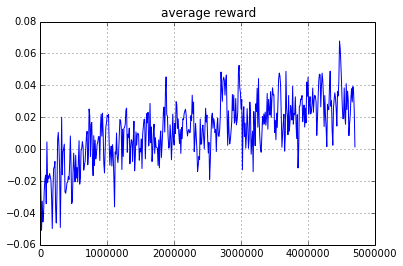

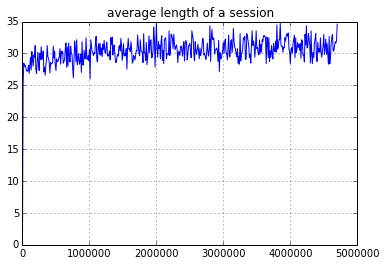

4710000 iters ( 4709999 / 1000000000 ) |sessions passed: 332 |reward: 0.0237447795008 |epsilon: 0.234892396757
4720000 iters ( 4719999 / 1000000000 ) |sessions passed: 307 |reward: 0.0114690734995 |epsilon: 0.234823317053
4730000 iters ( 4729999 / 1000000000 ) |sessions passed: 317 |reward: 0.031312433744 |epsilon: 0.234754310487
4740000 iters ( 4739999 / 1000000000 ) |sessions passed: 323 |reward: 0.025820219948 |epsilon: 0.234685376829
4750000 iters ( 4749999 / 1000000000 ) |sessions passed: 330 |reward: 0.010157084052 |epsilon: 0.234616515847
4760000 iters ( 4759999 / 1000000000 ) |sessions passed: 308 |reward: -0.00584223888965 |epsilon: 0.234547727312
4770000 iters ( 4769999 / 1000000000 ) |sessions passed: 334 |reward: 0.0174221973704 |epsilon: 0.234479010996
4780000 iters ( 4779999 / 1000000000 ) |sessions passed: 335 |reward: 0.0192191121699 |epsilon: 0.234410366673
4790000 iters ( 4789999 / 1000000000 ) |sessions passed: 329 |reward: 0.0212657091339 |epsilon: 0.234341794115
48

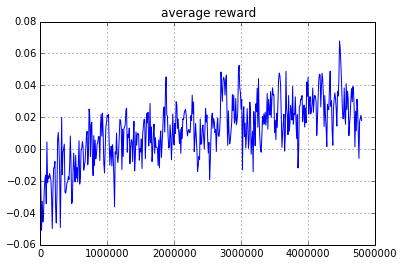

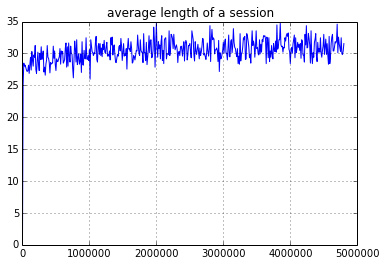

4810000 iters ( 4809999 / 1000000000 ) |sessions passed: 312 |reward: 0.035155631311 |epsilon: 0.234204863402
4820000 iters ( 4819999 / 1000000000 ) |sessions passed: 328 |reward: 0.027879983167 |epsilon: 0.2341365048
4830000 iters ( 4829999 / 1000000000 ) |sessions passed: 301 |reward: 0.0104537909967 |epsilon: 0.234068217072
4840000 iters ( 4839999 / 1000000000 ) |sessions passed: 301 |reward: -0.0178470934324 |epsilon: 0.234
4850000 iters ( 4849999 / 1000000000 ) |sessions passed: 315 |reward: 0.00591745546134 |epsilon: 0.233931853363
4860000 iters ( 4859999 / 1000000000 ) |sessions passed: 323 |reward: 0.0232387957549 |epsilon: 0.233863776945
4870000 iters ( 4869999 / 1000000000 ) |sessions passed: 320 |reward: 0.0157383361793 |epsilon: 0.233795770528
4880000 iters ( 4879999 / 1000000000 ) |sessions passed: 363 |reward: 0.0373834841705 |epsilon: 0.233727833897
4890000 iters ( 4889999 / 1000000000 ) |sessions passed: 288 |reward: 0.018238317637 |epsilon: 0.233659966838
4900000 iters

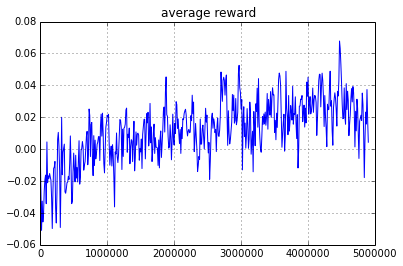

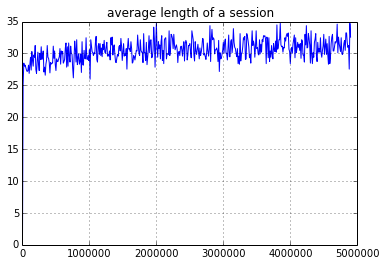

4910000 iters ( 4909999 / 1000000000 ) |sessions passed: 314 |reward: 0.00848603684101 |epsilon: 0.233524440582
4920000 iters ( 4919999 / 1000000000 ) |sessions passed: 315 |reward: 0.0213358229541 |epsilon: 0.233456780962
4930000 iters ( 4929999 / 1000000000 ) |sessions passed: 314 |reward: 0.027278724479 |epsilon: 0.233389190066
4940000 iters ( 4939999 / 1000000000 ) |sessions passed: 310 |reward: 0.00666904862749 |epsilon: 0.233321667687
4950000 iters ( 4949999 / 1000000000 ) |sessions passed: 333 |reward: 0.0265898206985 |epsilon: 0.233254213616
4960000 iters ( 4959999 / 1000000000 ) |sessions passed: 325 |reward: 0.0256606416929 |epsilon: 0.233186827646
4970000 iters ( 4969999 / 1000000000 ) |sessions passed: 313 |reward: 0.0322672345429 |epsilon: 0.233119509571
4980000 iters ( 4979999 / 1000000000 ) |sessions passed: 333 |reward: 0.029282004052 |epsilon: 0.233052259187
4990000 iters ( 4989999 / 1000000000 ) |sessions passed: 339 |reward: 0.0443224868873 |epsilon: 0.232985076289
5

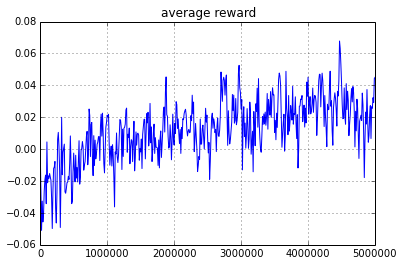

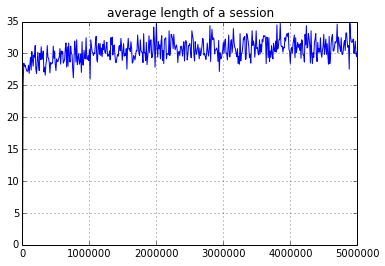

5010000 iters ( 5009999 / 1000000000 ) |sessions passed: 310 |reward: 0.0461445794211 |epsilon: 0.232850912143
5020000 iters ( 5019999 / 1000000000 ) |sessions passed: 305 |reward: 0.0242991028235 |epsilon: 0.232783930493
5030000 iters ( 5029999 / 1000000000 ) |sessions passed: 325 |reward: 0.0155362863048 |epsilon: 0.232717015524
5040000 iters ( 5039999 / 1000000000 ) |sessions passed: 296 |reward: 0.0305012692126 |epsilon: 0.232650167038
5050000 iters ( 5049999 / 1000000000 ) |sessions passed: 300 |reward: 0.0362037039463 |epsilon: 0.232583384837
5060000 iters ( 5059999 / 1000000000 ) |sessions passed: 328 |reward: 0.0505199165168 |epsilon: 0.232516668725
5070000 iters ( 5069999 / 1000000000 ) |sessions passed: 323 |reward: 0.0414867657965 |epsilon: 0.232450018505
5080000 iters ( 5079999 / 1000000000 ) |sessions passed: 320 |reward: 0.0217872466817 |epsilon: 0.232383433982
5090000 iters ( 5089999 / 1000000000 ) |sessions passed: 333 |reward: 0.0363763286961 |epsilon: 0.232316914964
5

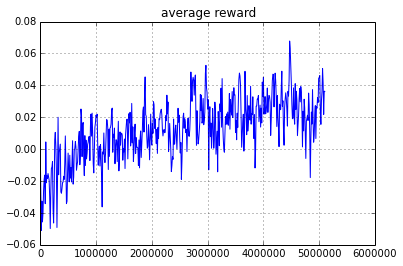

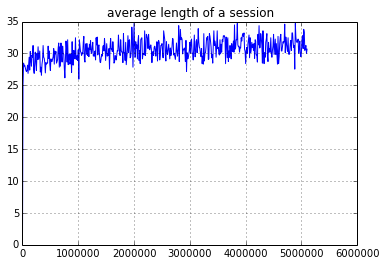

5110000 iters ( 5109999 / 1000000000 ) |sessions passed: 319 |reward: 0.0311849435609 |epsilon: 0.232184072667
5120000 iters ( 5119999 / 1000000000 ) |sessions passed: 302 |reward: 0.00912222004272 |epsilon: 0.232117749006
5130000 iters ( 5129999 / 1000000000 ) |sessions passed: 328 |reward: 0.0222190439722 |epsilon: 0.232051490083
5140000 iters ( 5139999 / 1000000000 ) |sessions passed: 317 |reward: 0.0284950500995 |epsilon: 0.231985295707
5150000 iters ( 5149999 / 1000000000 ) |sessions passed: 300 |reward: 0.0148448351969 |epsilon: 0.231919165693
5160000 iters ( 5159999 / 1000000000 ) |sessions passed: 313 |reward: 0.042637171013 |epsilon: 0.23185309985
5170000 iters ( 5169999 / 1000000000 ) |sessions passed: 305 |reward: 0.0265120925105 |epsilon: 0.231787097995
5180000 iters ( 5179999 / 1000000000 ) |sessions passed: 319 |reward: 0.034305974153 |epsilon: 0.23172115994
5190000 iters ( 5189999 / 1000000000 ) |sessions passed: 300 |reward: -0.000526388885153 |epsilon: 0.231655285501
5

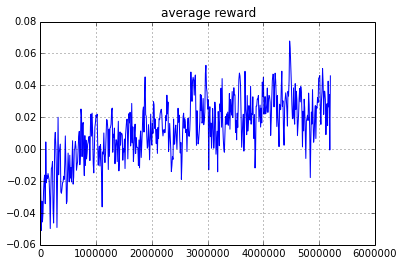

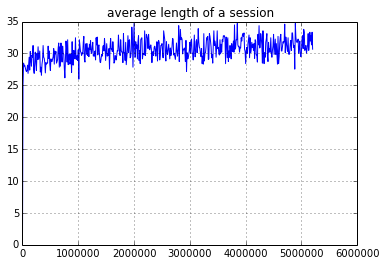

5210000 iters ( 5209999 / 1000000000 ) |sessions passed: 307 |reward: 0.0429005515313 |epsilon: 0.231523726737
5220000 iters ( 5219999 / 1000000000 ) |sessions passed: 304 |reward: 0.0150192328342 |epsilon: 0.231458042047
5230000 iters ( 5229999 / 1000000000 ) |sessions passed: 308 |reward: 0.0258216120029 |epsilon: 0.231392420244
5240000 iters ( 5239999 / 1000000000 ) |sessions passed: 339 |reward: 0.0418942227751 |epsilon: 0.231326861146
5250000 iters ( 5249999 / 1000000000 ) |sessions passed: 321 |reward: 0.028953917643 |epsilon: 0.231261364576
5260000 iters ( 5259999 / 1000000000 ) |sessions passed: 311 |reward: 0.0482487880359 |epsilon: 0.231195930353
5270000 iters ( 5269999 / 1000000000 ) |sessions passed: 324 |reward: 0.0470665231336 |epsilon: 0.231130558301
5280000 iters ( 5279999 / 1000000000 ) |sessions passed: 305 |reward: 0.0482832817883 |epsilon: 0.231065248242
5290000 iters ( 5289999 / 1000000000 ) |sessions passed: 307 |reward: 0.0566066650231 |epsilon: 0.231
5300000 ite

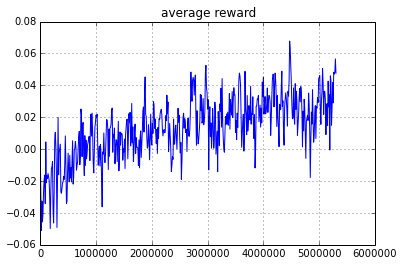

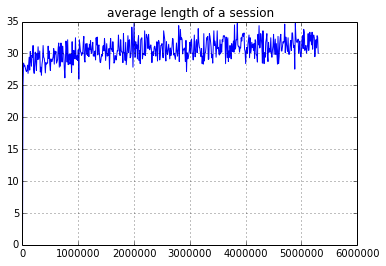

5310000 iters ( 5309999 / 1000000000 ) |sessions passed: 324 |reward: 0.01660804859 |epsilon: 0.230869688269
5320000 iters ( 5319999 / 1000000000 ) |sessions passed: 335 |reward: 0.0242348039241 |epsilon: 0.230804624432
5330000 iters ( 5329999 / 1000000000 ) |sessions passed: 310 |reward: 0.011910532005 |epsilon: 0.230739621716
5340000 iters ( 5339999 / 1000000000 ) |sessions passed: 298 |reward: 0.0325722801347 |epsilon: 0.23067467995
5350000 iters ( 5349999 / 1000000000 ) |sessions passed: 310 |reward: 0.0198162543519 |epsilon: 0.230609798963
5360000 iters ( 5359999 / 1000000000 ) |sessions passed: 307 |reward: 0.0350683999059 |epsilon: 0.230544978583
5370000 iters ( 5369999 / 1000000000 ) |sessions passed: 319 |reward: 0.0546746548196 |epsilon: 0.230480218642
5380000 iters ( 5379999 / 1000000000 ) |sessions passed: 320 |reward: 0.0428345335911 |epsilon: 0.230415518972
5390000 iters ( 5389999 / 1000000000 ) |sessions passed: 328 |reward: 0.0487533968622 |epsilon: 0.230350879403
54000

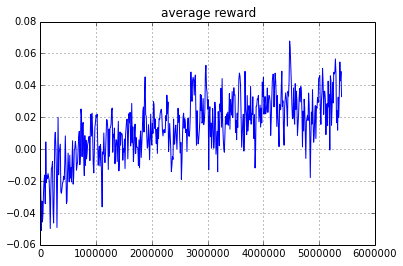

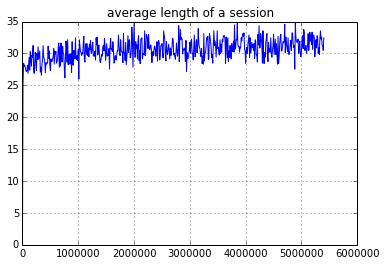

5410000 iters ( 5409999 / 1000000000 ) |sessions passed: 313 |reward: 0.0356770091629 |epsilon: 0.230221779902
5420000 iters ( 5419999 / 1000000000 ) |sessions passed: 334 |reward: 0.0295663444402 |epsilon: 0.230157319639
5430000 iters ( 5429999 / 1000000000 ) |sessions passed: 278 |reward: 0.00747035902886 |epsilon: 0.230092918814
5440000 iters ( 5439999 / 1000000000 ) |sessions passed: 287 |reward: -0.00174829688721 |epsilon: 0.230028577262
5450000 iters ( 5449999 / 1000000000 ) |sessions passed: 315 |reward: 0.0213945777405 |epsilon: 0.22996429482
5460000 iters ( 5459999 / 1000000000 ) |sessions passed: 307 |reward: 0.0088762693525 |epsilon: 0.229900071327
5470000 iters ( 5469999 / 1000000000 ) |sessions passed: 308 |reward: 0.0411599689361 |epsilon: 0.229835906619
5480000 iters ( 5479999 / 1000000000 ) |sessions passed: 311 |reward: 0.0338689897358 |epsilon: 0.229771800536
5490000 iters ( 5489999 / 1000000000 ) |sessions passed: 309 |reward: 0.0338214013849 |epsilon: 0.229707752917

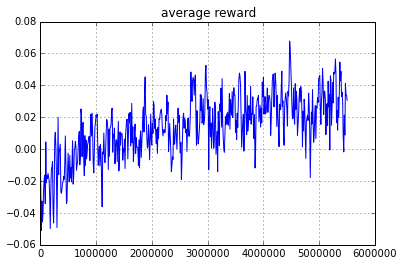

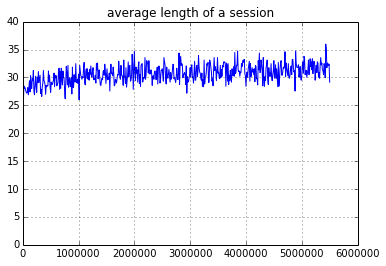

5510000 iters ( 5509999 / 1000000000 ) |sessions passed: 319 |reward: 0.0338942612739 |epsilon: 0.229579832434
5520000 iters ( 5519999 / 1000000000 ) |sessions passed: 337 |reward: 0.0336680632962 |epsilon: 0.229515959253
5530000 iters ( 5529999 / 1000000000 ) |sessions passed: 304 |reward: 0.0289492759875 |epsilon: 0.229452143902
5540000 iters ( 5539999 / 1000000000 ) |sessions passed: 321 |reward: 0.0205761575283 |epsilon: 0.229388386224
5550000 iters ( 5549999 / 1000000000 ) |sessions passed: 338 |reward: 0.0342121492509 |epsilon: 0.229324686064
5560000 iters ( 5559999 / 1000000000 ) |sessions passed: 307 |reward: 0.0307467682727 |epsilon: 0.229261043265
5570000 iters ( 5569999 / 1000000000 ) |sessions passed: 310 |reward: 0.00757213544554 |epsilon: 0.229197457673
5580000 iters ( 5579999 / 1000000000 ) |sessions passed: 324 |reward: 0.0160138411611 |epsilon: 0.229133929134
5590000 iters ( 5589999 / 1000000000 ) |sessions passed: 316 |reward: 0.0170017133489 |epsilon: 0.229070457495


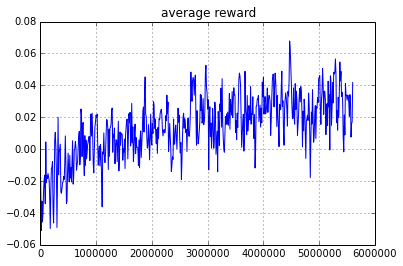

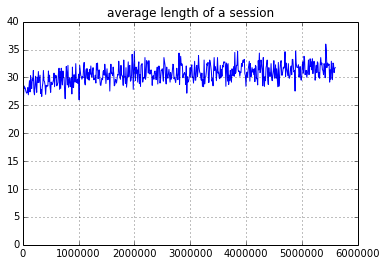

5610000 iters ( 5609999 / 1000000000 ) |sessions passed: 320 |reward: 0.031997395783 |epsilon: 0.228943684306
5620000 iters ( 5619999 / 1000000000 ) |sessions passed: 309 |reward: 0.0339976908389 |epsilon: 0.228880382453
5630000 iters ( 5629999 / 1000000000 ) |sessions passed: 284 |reward: 0.0263166324642 |epsilon: 0.228817136894
5640000 iters ( 5639999 / 1000000000 ) |sessions passed: 318 |reward: 0.0323868699985 |epsilon: 0.228753947478
5650000 iters ( 5649999 / 1000000000 ) |sessions passed: 302 |reward: -0.00159062285993 |epsilon: 0.228690814056
5660000 iters ( 5659999 / 1000000000 ) |sessions passed: 311 |reward: 0.00351401264137 |epsilon: 0.22862773648
5670000 iters ( 5669999 / 1000000000 ) |sessions passed: 296 |reward: 0.0320486532026 |epsilon: 0.228564714601
5680000 iters ( 5679999 / 1000000000 ) |sessions passed: 284 |reward: 0.0388794854928 |epsilon: 0.228501748273
5690000 iters ( 5689999 / 1000000000 ) |sessions passed: 319 |reward: 0.0499672740461 |epsilon: 0.228438837349


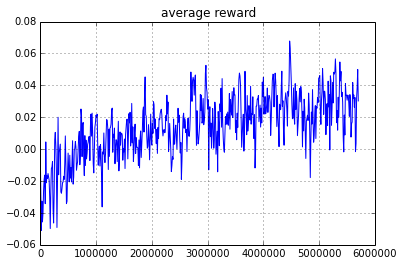

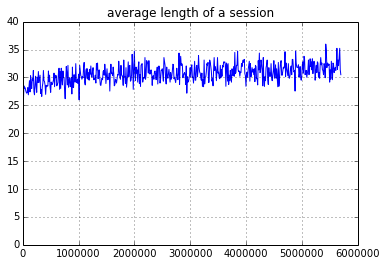

5710000 iters ( 5709999 / 1000000000 ) |sessions passed: 316 |reward: 0.0294786333006 |epsilon: 0.228313181128
5720000 iters ( 5719999 / 1000000000 ) |sessions passed: 335 |reward: 0.0210074825301 |epsilon: 0.228250435541
5730000 iters ( 5729999 / 1000000000 ) |sessions passed: 292 |reward: 0.0265943469341 |epsilon: 0.228187744778
5740000 iters ( 5739999 / 1000000000 ) |sessions passed: 302 |reward: 0.0121850893213 |epsilon: 0.228125108696
5750000 iters ( 5749999 / 1000000000 ) |sessions passed: 322 |reward: 0.0466285086407 |epsilon: 0.22806252715
5760000 iters ( 5759999 / 1000000000 ) |sessions passed: 317 |reward: 0.0386964910668 |epsilon: 0.228
5770000 iters ( 5769999 / 1000000000 ) |sessions passed: 309 |reward: 0.0431442036757 |epsilon: 0.227937527103
5780000 iters ( 5779999 / 1000000000 ) |sessions passed: 330 |reward: 0.0326531749274 |epsilon: 0.227875108319
5790000 iters ( 5789999 / 1000000000 ) |sessions passed: 301 |reward: 0.0142647435756 |epsilon: 0.227812743507
5800000 ite

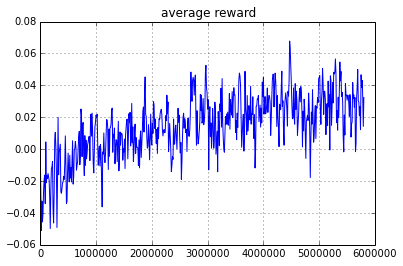

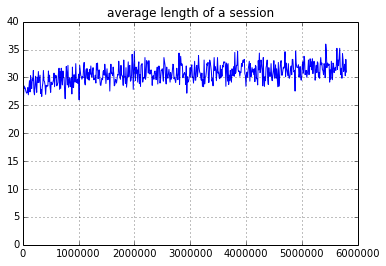

5810000 iters ( 5809999 / 1000000000 ) |sessions passed: 315 |reward: 0.0435820493631 |epsilon: 0.227688175241
5820000 iters ( 5819999 / 1000000000 ) |sessions passed: 315 |reward: 0.0618370947026 |epsilon: 0.227625971509
5830000 iters ( 5829999 / 1000000000 ) |sessions passed: 303 |reward: 0.0518910647427 |epsilon: 0.227563821194
5840000 iters ( 5839999 / 1000000000 ) |sessions passed: 293 |reward: 0.0288057339718 |epsilon: 0.227501724158
5850000 iters ( 5849999 / 1000000000 ) |sessions passed: 315 |reward: 0.040172352941 |epsilon: 0.227439680265
5860000 iters ( 5859999 / 1000000000 ) |sessions passed: 316 |reward: 0.0462859627894 |epsilon: 0.227377689379
5870000 iters ( 5869999 / 1000000000 ) |sessions passed: 329 |reward: 0.042483832679 |epsilon: 0.227315751362
5880000 iters ( 5879999 / 1000000000 ) |sessions passed: 314 |reward: 0.0474896278413 |epsilon: 0.227253866082
5890000 iters ( 5889999 / 1000000000 ) |sessions passed: 337 |reward: 0.0588872355397 |epsilon: 0.227192033403
590

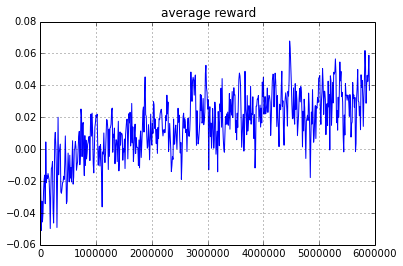

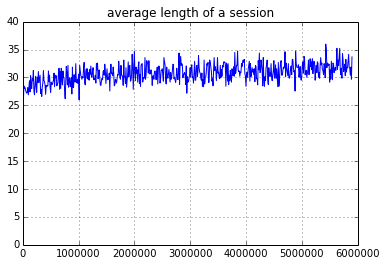

5910000 iters ( 5909999 / 1000000000 ) |sessions passed: 313 |reward: 0.0220691058781 |epsilon: 0.227068525313
5920000 iters ( 5919999 / 1000000000 ) |sessions passed: 321 |reward: 0.0276531550311 |epsilon: 0.227006849636
5930000 iters ( 5929999 / 1000000000 ) |sessions passed: 336 |reward: 0.0190976059817 |epsilon: 0.226945226029
5940000 iters ( 5939999 / 1000000000 ) |sessions passed: 312 |reward: 0.0429633694653 |epsilon: 0.226883654358
5950000 iters ( 5949999 / 1000000000 ) |sessions passed: 318 |reward: 0.0410953247864 |epsilon: 0.226822134494
5960000 iters ( 5959999 / 1000000000 ) |sessions passed: 309 |reward: 0.0389331064841 |epsilon: 0.226760666306
5970000 iters ( 5969999 / 1000000000 ) |sessions passed: 324 |reward: 0.0222093437397 |epsilon: 0.226699249663
5980000 iters ( 5979999 / 1000000000 ) |sessions passed: 327 |reward: 0.0384895466188 |epsilon: 0.226637884436
5990000 iters ( 5989999 / 1000000000 ) |sessions passed: 320 |reward: 0.0284284209323 |epsilon: 0.226576570497
6

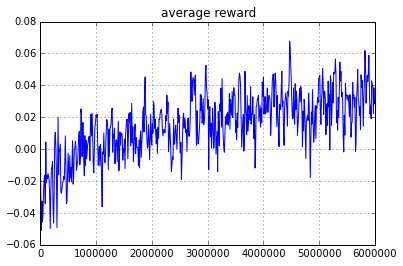

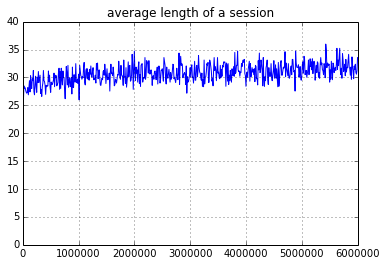

6010000 iters ( 6009999 / 1000000000 ) |sessions passed: 341 |reward: 0.0325848515197 |epsilon: 0.226454095967
6020000 iters ( 6019999 / 1000000000 ) |sessions passed: 283 |reward: 0.0162107349969 |epsilon: 0.226392935122
6030000 iters ( 6029999 / 1000000000 ) |sessions passed: 318 |reward: 0.00472396972227 |epsilon: 0.226331825053
6040000 iters ( 6039999 / 1000000000 ) |sessions passed: 324 |reward: 0.04073212337 |epsilon: 0.226270765635
6050000 iters ( 6049999 / 1000000000 ) |sessions passed: 322 |reward: 0.0487442624213 |epsilon: 0.226209756743
6060000 iters ( 6059999 / 1000000000 ) |sessions passed: 308 |reward: 0.0295155978338 |epsilon: 0.226148798249
6070000 iters ( 6069999 / 1000000000 ) |sessions passed: 319 |reward: 0.0336120120816 |epsilon: 0.226087890031
6080000 iters ( 6079999 / 1000000000 ) |sessions passed: 334 |reward: 0.0480463861795 |epsilon: 0.226027031964
6090000 iters ( 6089999 / 1000000000 ) |sessions passed: 337 |reward: 0.0527188900001 |epsilon: 0.225966223924
61

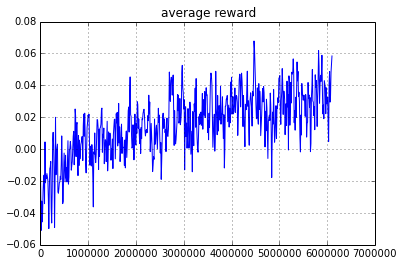

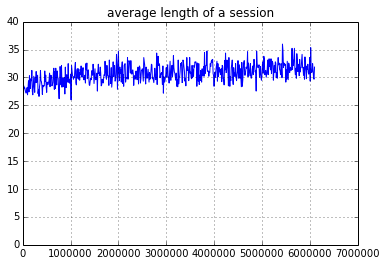

6110000 iters ( 6109999 / 1000000000 ) |sessions passed: 323 |reward: 0.0325006418439 |epsilon: 0.225844757434
6120000 iters ( 6119999 / 1000000000 ) |sessions passed: 299 |reward: 0.0241097213419 |epsilon: 0.225784098739
6130000 iters ( 6129999 / 1000000000 ) |sessions passed: 321 |reward: 0.029259818626 |epsilon: 0.225723489581
6140000 iters ( 6139999 / 1000000000 ) |sessions passed: 317 |reward: 0.0169954801453 |epsilon: 0.22566292984
6150000 iters ( 6149999 / 1000000000 ) |sessions passed: 308 |reward: 0.0197323291084 |epsilon: 0.225602419394
6160000 iters ( 6159999 / 1000000000 ) |sessions passed: 296 |reward: 0.0192060338592 |epsilon: 0.225541958124
6170000 iters ( 6169999 / 1000000000 ) |sessions passed: 324 |reward: 0.0577780005357 |epsilon: 0.22548154591
6180000 iters ( 6179999 / 1000000000 ) |sessions passed: 319 |reward: 0.0397304110803 |epsilon: 0.225421182632
6190000 iters ( 6189999 / 1000000000 ) |sessions passed: 318 |reward: 0.0438002619624 |epsilon: 0.225360868172
6200

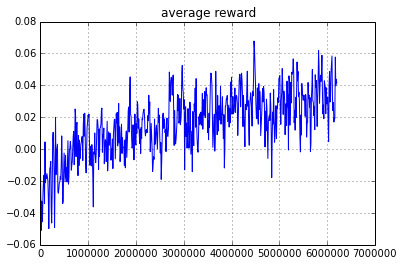

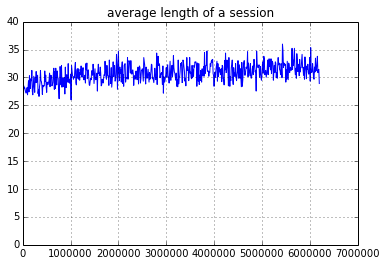

6210000 iters ( 6209999 / 1000000000 ) |sessions passed: 314 |reward: 0.0193421500722 |epsilon: 0.225240385234
6220000 iters ( 6219999 / 1000000000 ) |sessions passed: 339 |reward: 0.0301471731997 |epsilon: 0.22518021652
6230000 iters ( 6229999 / 1000000000 ) |sessions passed: 311 |reward: 0.0281314974226 |epsilon: 0.225120096154
6240000 iters ( 6239999 / 1000000000 ) |sessions passed: 316 |reward: 0.00427743071262 |epsilon: 0.225060024019
6250000 iters ( 6249999 / 1000000000 ) |sessions passed: 324 |reward: 0.0389177613934 |epsilon: 0.225
6260000 iters ( 6259999 / 1000000000 ) |sessions passed: 307 |reward: 0.0475612437997 |epsilon: 0.224940023981
6270000 iters ( 6269999 / 1000000000 ) |sessions passed: 291 |reward: 0.0304209970858 |epsilon: 0.224880095847
6280000 iters ( 6279999 / 1000000000 ) |sessions passed: 310 |reward: 0.0528963911912 |epsilon: 0.224820215483
6290000 iters ( 6289999 / 1000000000 ) |sessions passed: 317 |reward: 0.0404328385537 |epsilon: 0.224760382776
6300000 it

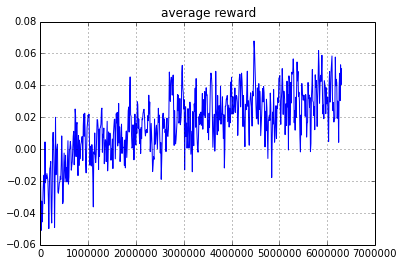

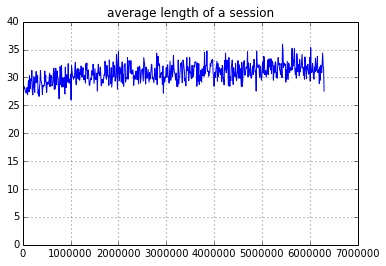

6310000 iters ( 6309999 / 1000000000 ) |sessions passed: 322 |reward: 0.0442310274604 |epsilon: 0.224640859878
6320000 iters ( 6319999 / 1000000000 ) |sessions passed: 319 |reward: 0.0361684400904 |epsilon: 0.22458116946
6330000 iters ( 6329999 / 1000000000 ) |sessions passed: 331 |reward: 0.0539125482668 |epsilon: 0.224521526248
6340000 iters ( 6339999 / 1000000000 ) |sessions passed: 321 |reward: 0.0603360637985 |epsilon: 0.224461930128
6350000 iters ( 6349999 / 1000000000 ) |sessions passed: 307 |reward: 0.0270127332922 |epsilon: 0.22440238099
6360000 iters ( 6359999 / 1000000000 ) |sessions passed: 348 |reward: 0.0411539059737 |epsilon: 0.224342878722
6370000 iters ( 6369999 / 1000000000 ) |sessions passed: 316 |reward: 0.0559351212995 |epsilon: 0.224283423215
6380000 iters ( 6379999 / 1000000000 ) |sessions passed: 291 |reward: 0.054514098129 |epsilon: 0.224224014358
6390000 iters ( 6389999 / 1000000000 ) |sessions passed: 308 |reward: 0.0505270120955 |epsilon: 0.224164652041
6400

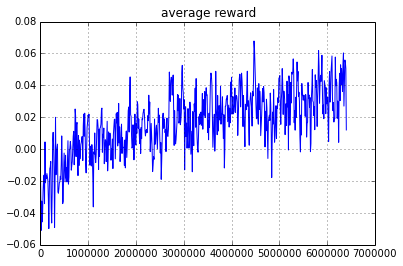

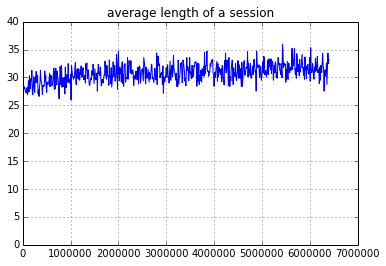

6410000 iters ( 6409999 / 1000000000 ) |sessions passed: 303 |reward: 0.0292893519892 |epsilon: 0.224046066593
6420000 iters ( 6419999 / 1000000000 ) |sessions passed: 308 |reward: 0.0412727403265 |epsilon: 0.223986843244
6430000 iters ( 6429999 / 1000000000 ) |sessions passed: 337 |reward: 0.0403206284262 |epsilon: 0.223927666001
6440000 iters ( 6439999 / 1000000000 ) |sessions passed: 317 |reward: 0.0287491378433 |epsilon: 0.223868534757
6450000 iters ( 6449999 / 1000000000 ) |sessions passed: 318 |reward: 0.0331509455896 |epsilon: 0.223809449405
6460000 iters ( 6459999 / 1000000000 ) |sessions passed: 326 |reward: 0.0346983924387 |epsilon: 0.223750409837
6470000 iters ( 6469999 / 1000000000 ) |sessions passed: 304 |reward: 0.0246259228508 |epsilon: 0.223691415948
6480000 iters ( 6479999 / 1000000000 ) |sessions passed: 320 |reward: 0.0205340682911 |epsilon: 0.223632467632
6490000 iters ( 6489999 / 1000000000 ) |sessions passed: 299 |reward: 0.0527242813485 |epsilon: 0.223573564783
6

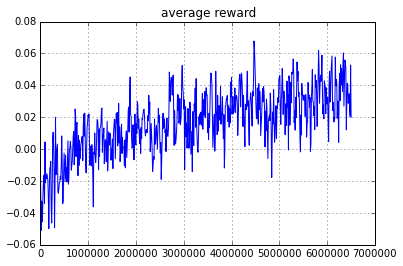

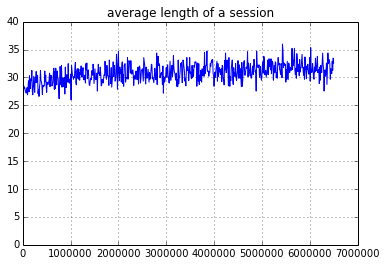

6510000 iters ( 6509999 / 1000000000 ) |sessions passed: 306 |reward: 0.0261343476719 |epsilon: 0.223455895067
6520000 iters ( 6519999 / 1000000000 ) |sessions passed: 310 |reward: 0.0370795620759 |epsilon: 0.223397127991
6530000 iters ( 6529999 / 1000000000 ) |sessions passed: 324 |reward: 0.0422474334285 |epsilon: 0.223338405965
6540000 iters ( 6539999 / 1000000000 ) |sessions passed: 283 |reward: 0.00413890217357 |epsilon: 0.223279728885
6550000 iters ( 6549999 / 1000000000 ) |sessions passed: 318 |reward: 0.0316785053356 |epsilon: 0.223221096648
6560000 iters ( 6559999 / 1000000000 ) |sessions passed: 292 |reward: 0.0362686805516 |epsilon: 0.223162509151
6570000 iters ( 6569999 / 1000000000 ) |sessions passed: 321 |reward: 0.0509857010929 |epsilon: 0.223103966292
6580000 iters ( 6579999 / 1000000000 ) |sessions passed: 308 |reward: 0.0427303853648 |epsilon: 0.22304546797
6590000 iters ( 6589999 / 1000000000 ) |sessions passed: 303 |reward: 0.0407386160718 |epsilon: 0.222987014082
6

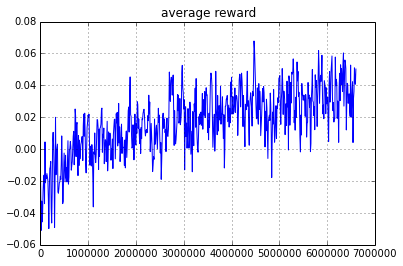

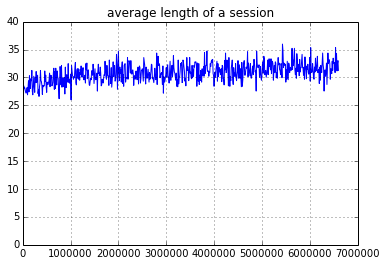

6610000 iters ( 6609999 / 1000000000 ) |sessions passed: 313 |reward: 0.0469656141292 |epsilon: 0.222870239207
6620000 iters ( 6619999 / 1000000000 ) |sessions passed: 299 |reward: 0.0433005049269 |epsilon: 0.222811918018
6630000 iters ( 6629999 / 1000000000 ) |sessions passed: 318 |reward: 0.0423259826561 |epsilon: 0.222753640862
6640000 iters ( 6639999 / 1000000000 ) |sessions passed: 307 |reward: 0.0168220900161 |epsilon: 0.22269540764
6650000 iters ( 6649999 / 1000000000 ) |sessions passed: 336 |reward: 0.0468561352452 |epsilon: 0.222637218251
6660000 iters ( 6659999 / 1000000000 ) |sessions passed: 317 |reward: 0.0453078201788 |epsilon: 0.222579072597
6670000 iters ( 6669999 / 1000000000 ) |sessions passed: 305 |reward: 0.0421933951617 |epsilon: 0.222520970579
6680000 iters ( 6679999 / 1000000000 ) |sessions passed: 328 |reward: 0.0506564760855 |epsilon: 0.2224629121
6690000 iters ( 6689999 / 1000000000 ) |sessions passed: 310 |reward: 0.0266714308457 |epsilon: 0.222404897062
6700

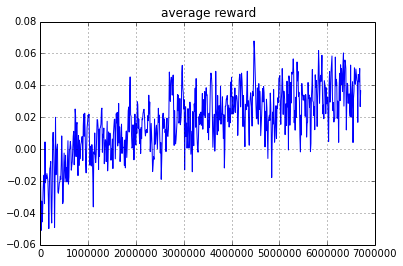

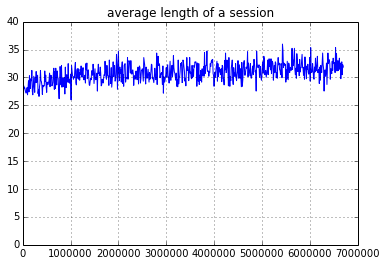

6710000 iters ( 6709999 / 1000000000 ) |sessions passed: 341 |reward: 0.0614877448558 |epsilon: 0.222288996918
6720000 iters ( 6719999 / 1000000000 ) |sessions passed: 324 |reward: 0.0404092339649 |epsilon: 0.222231111619
6730000 iters ( 6729999 / 1000000000 ) |sessions passed: 300 |reward: 0.0463700202273 |epsilon: 0.222173269374
6740000 iters ( 6739999 / 1000000000 ) |sessions passed: 290 |reward: 0.0287450475434 |epsilon: 0.222115470086
6750000 iters ( 6749999 / 1000000000 ) |sessions passed: 324 |reward: 0.0322534573374 |epsilon: 0.222057713659
6760000 iters ( 6759999 / 1000000000 ) |sessions passed: 313 |reward: 0.0548513123412 |epsilon: 0.222
6770000 iters ( 6769999 / 1000000000 ) |sessions passed: 300 |reward: 0.035951936163 |epsilon: 0.221942329012
6780000 iters ( 6779999 / 1000000000 ) |sessions passed: 293 |reward: 0.0382722389017 |epsilon: 0.221884700602
6790000 iters ( 6789999 / 1000000000 ) |sessions passed: 323 |reward: 0.0279764127253 |epsilon: 0.221827114675
6800000 ite

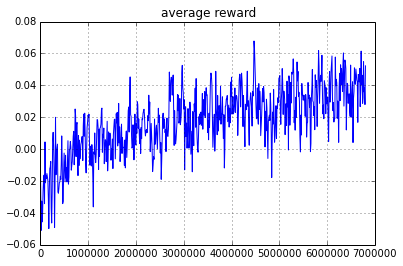

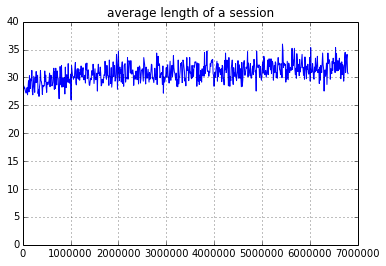

6810000 iters ( 6809999 / 1000000000 ) |sessions passed: 316 |reward: 0.0590941739763 |epsilon: 0.221712069896
6820000 iters ( 6819999 / 1000000000 ) |sessions passed: 342 |reward: 0.0663121198029 |epsilon: 0.221654610857
6830000 iters ( 6829999 / 1000000000 ) |sessions passed: 317 |reward: 0.0664424866987 |epsilon: 0.221597193928
6840000 iters ( 6839999 / 1000000000 ) |sessions passed: 323 |reward: 0.0575349568061 |epsilon: 0.221539819016
6850000 iters ( 6849999 / 1000000000 ) |sessions passed: 269 |reward: 0.0258574083406 |epsilon: 0.22148248603
6860000 iters ( 6859999 / 1000000000 ) |sessions passed: 311 |reward: 0.0288081191853 |epsilon: 0.221425194878
6870000 iters ( 6869999 / 1000000000 ) |sessions passed: 305 |reward: 0.0262816311885 |epsilon: 0.221367945468
6880000 iters ( 6879999 / 1000000000 ) |sessions passed: 316 |reward: 0.0468164547745 |epsilon: 0.221310737708
6890000 iters ( 6889999 / 1000000000 ) |sessions passed: 325 |reward: 0.0347978066781 |epsilon: 0.22125357151
690

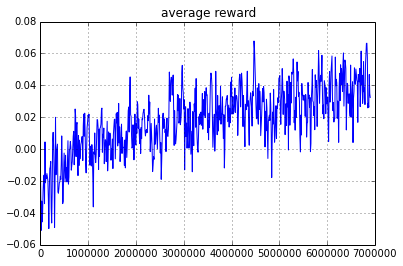

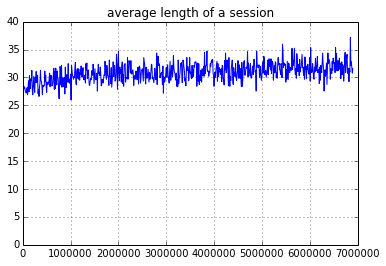

6910000 iters ( 6909999 / 1000000000 ) |sessions passed: 295 |reward: 0.0395183042906 |epsilon: 0.221139363431
6920000 iters ( 6919999 / 1000000000 ) |sessions passed: 337 |reward: 0.0356907320635 |epsilon: 0.221082321372
6930000 iters ( 6929999 / 1000000000 ) |sessions passed: 314 |reward: 0.0498064304943 |epsilon: 0.221025320513
6940000 iters ( 6939999 / 1000000000 ) |sessions passed: 323 |reward: 0.0373619584391 |epsilon: 0.220968360766
6950000 iters ( 6949999 / 1000000000 ) |sessions passed: 336 |reward: 0.0663568370229 |epsilon: 0.220911442041
6960000 iters ( 6959999 / 1000000000 ) |sessions passed: 294 |reward: 0.0408852968964 |epsilon: 0.22085456425
6970000 iters ( 6969999 / 1000000000 ) |sessions passed: 298 |reward: 0.0371566465535 |epsilon: 0.220797727305
6980000 iters ( 6979999 / 1000000000 ) |sessions passed: 313 |reward: 0.0502336137914 |epsilon: 0.220740931118
6990000 iters ( 6989999 / 1000000000 ) |sessions passed: 307 |reward: 0.0317535156691 |epsilon: 0.220684175602
70

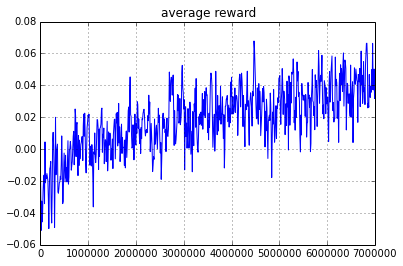

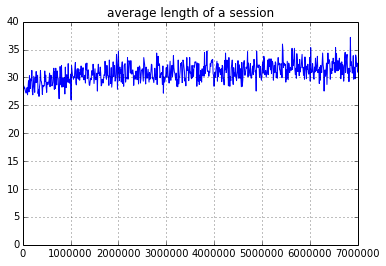

7010000 iters ( 7009999 / 1000000000 ) |sessions passed: 300 |reward: 0.031420800903 |epsilon: 0.220570786231
7020000 iters ( 7019999 / 1000000000 ) |sessions passed: 311 |reward: 0.0421392215591 |epsilon: 0.220514152203
7030000 iters ( 7029999 / 1000000000 ) |sessions passed: 305 |reward: 0.0453884787817 |epsilon: 0.220457558499
7040000 iters ( 7039999 / 1000000000 ) |sessions passed: 318 |reward: 0.03683919793 |epsilon: 0.220401005031
7050000 iters ( 7049999 / 1000000000 ) |sessions passed: 326 |reward: 0.0457126765572 |epsilon: 0.220344491716
7060000 iters ( 7059999 / 1000000000 ) |sessions passed: 326 |reward: 0.0588299073897 |epsilon: 0.220288018466
7070000 iters ( 7069999 / 1000000000 ) |sessions passed: 301 |reward: 0.0567854636761 |epsilon: 0.220231585198
7080000 iters ( 7079999 / 1000000000 ) |sessions passed: 322 |reward: 0.0450470083738 |epsilon: 0.220175191826
7090000 iters ( 7089999 / 1000000000 ) |sessions passed: 312 |reward: 0.0429811629707 |epsilon: 0.220118838266
7100

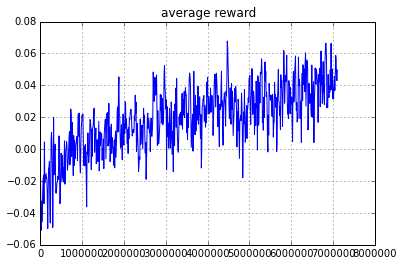

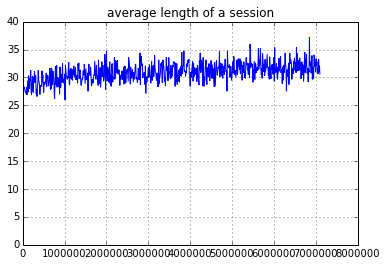

7110000 iters ( 7109999 / 1000000000 ) |sessions passed: 323 |reward: 0.0650447183454 |epsilon: 0.220006250244
7120000 iters ( 7119999 / 1000000000 ) |sessions passed: 316 |reward: 0.0529151683139 |epsilon: 0.219950015615
7130000 iters ( 7129999 / 1000000000 ) |sessions passed: 301 |reward: 0.0434664107754 |epsilon: 0.219893820463
7140000 iters ( 7139999 / 1000000000 ) |sessions passed: 306 |reward: 0.0298418418352 |epsilon: 0.219837664705
7150000 iters ( 7149999 / 1000000000 ) |sessions passed: 323 |reward: 0.0532080178913 |epsilon: 0.219781548257
7160000 iters ( 7159999 / 1000000000 ) |sessions passed: 323 |reward: 0.0562183808343 |epsilon: 0.219725471038
7170000 iters ( 7169999 / 1000000000 ) |sessions passed: 323 |reward: 0.0613730529759 |epsilon: 0.219669432966
7180000 iters ( 7179999 / 1000000000 ) |sessions passed: 298 |reward: 0.0308750586259 |epsilon: 0.219613433958
7190000 iters ( 7189999 / 1000000000 ) |sessions passed: 298 |reward: 0.0407916713683 |epsilon: 0.219557473933
7

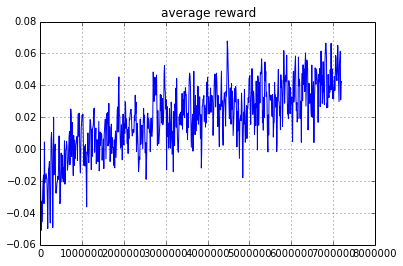

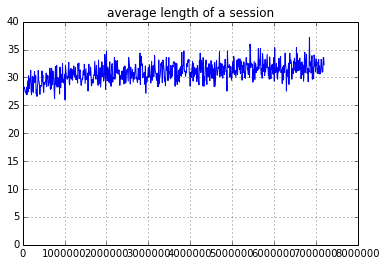

7210000 iters ( 7209999 / 1000000000 ) |sessions passed: 296 |reward: 0.0369862454622 |epsilon: 0.219445670507
7220000 iters ( 7219999 / 1000000000 ) |sessions passed: 312 |reward: 0.041456351009 |epsilon: 0.219389826945
7230000 iters ( 7229999 / 1000000000 ) |sessions passed: 288 |reward: 0.0277898974298 |epsilon: 0.219334022042
7240000 iters ( 7239999 / 1000000000 ) |sessions passed: 328 |reward: 0.0322937536118 |epsilon: 0.219278255718
7250000 iters ( 7249999 / 1000000000 ) |sessions passed: 288 |reward: 0.0251248286201 |epsilon: 0.219222527893
7260000 iters ( 7259999 / 1000000000 ) |sessions passed: 313 |reward: 0.0217863775167 |epsilon: 0.219166838488
7270000 iters ( 7269999 / 1000000000 ) |sessions passed: 329 |reward: 0.0446079150901 |epsilon: 0.219111187424
7280000 iters ( 7279999 / 1000000000 ) |sessions passed: 314 |reward: 0.035178291632 |epsilon: 0.219055574621
7290000 iters ( 7289999 / 1000000000 ) |sessions passed: 315 |reward: 0.0414742846481 |epsilon: 0.219
7300000 iter

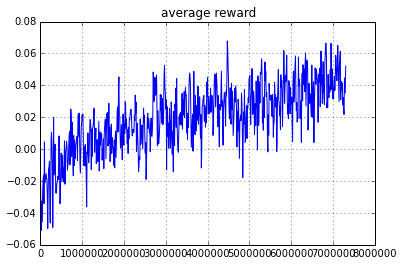

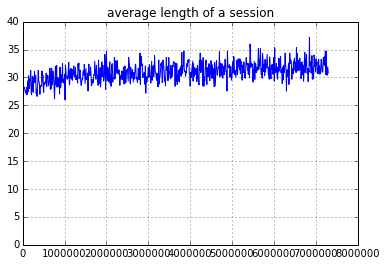

7310000 iters ( 7309999 / 1000000000 ) |sessions passed: 298 |reward: 0.0261513071079 |epsilon: 0.218888964992
7320000 iters ( 7319999 / 1000000000 ) |sessions passed: 267 |reward: 0.0252146738625 |epsilon: 0.218833504449
7330000 iters ( 7329999 / 1000000000 ) |sessions passed: 318 |reward: 0.0455719415663 |epsilon: 0.218778081776
7340000 iters ( 7339999 / 1000000000 ) |sessions passed: 317 |reward: 0.0337459230827 |epsilon: 0.218722696895
7350000 iters ( 7349999 / 1000000000 ) |sessions passed: 298 |reward: 0.0297179299514 |epsilon: 0.21866734973
7360000 iters ( 7359999 / 1000000000 ) |sessions passed: 302 |reward: 0.0333774273314 |epsilon: 0.218612040202
7370000 iters ( 7369999 / 1000000000 ) |sessions passed: 321 |reward: 0.0479286299266 |epsilon: 0.218556768237
7380000 iters ( 7379999 / 1000000000 ) |sessions passed: 318 |reward: 0.0430926862029 |epsilon: 0.218501533757
7390000 iters ( 7389999 / 1000000000 ) |sessions passed: 306 |reward: 0.0555725330426 |epsilon: 0.218446336686
74

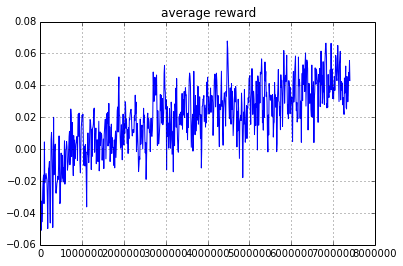

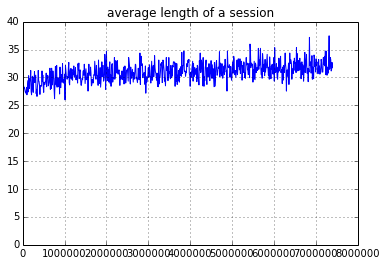

7410000 iters ( 7409999 / 1000000000 ) |sessions passed: 322 |reward: 0.0321224911661 |epsilon: 0.218336054467
7420000 iters ( 7419999 / 1000000000 ) |sessions passed: 304 |reward: 0.0234279964 |epsilon: 0.218280969169
7430000 iters ( 7429999 / 1000000000 ) |sessions passed: 314 |reward: 0.0468347807667 |epsilon: 0.218225920977
7440000 iters ( 7439999 / 1000000000 ) |sessions passed: 297 |reward: 0.0544084216707 |epsilon: 0.218170909818
7450000 iters ( 7449999 / 1000000000 ) |sessions passed: 318 |reward: 0.0386466615232 |epsilon: 0.218115935616
7460000 iters ( 7459999 / 1000000000 ) |sessions passed: 303 |reward: 0.0524028370278 |epsilon: 0.218060998298
7470000 iters ( 7469999 / 1000000000 ) |sessions passed: 304 |reward: 0.0340711134666 |epsilon: 0.218006097788
7480000 iters ( 7479999 / 1000000000 ) |sessions passed: 304 |reward: 0.0275785380234 |epsilon: 0.217951234013
7490000 iters ( 7489999 / 1000000000 ) |sessions passed: 317 |reward: 0.0321278368728 |epsilon: 0.2178964069
750000

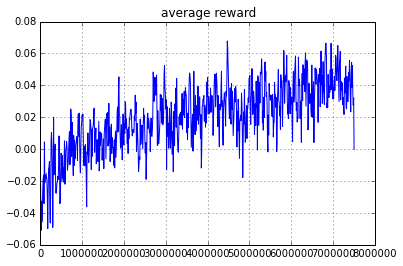

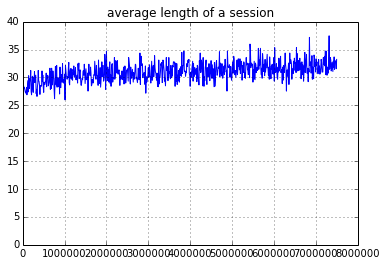

7510000 iters ( 7509999 / 1000000000 ) |sessions passed: 312 |reward: 0.0210555680149 |epsilon: 0.217786862364
7520000 iters ( 7519999 / 1000000000 ) |sessions passed: 284 |reward: 0.0477338610923 |epsilon: 0.217732144795
7530000 iters ( 7529999 / 1000000000 ) |sessions passed: 317 |reward: 0.055581515258 |epsilon: 0.217677463596
7540000 iters ( 7539999 / 1000000000 ) |sessions passed: 290 |reward: 0.0387937984591 |epsilon: 0.217622818694
7550000 iters ( 7549999 / 1000000000 ) |sessions passed: 320 |reward: 0.052438517625 |epsilon: 0.217568210016
7560000 iters ( 7559999 / 1000000000 ) |sessions passed: 316 |reward: 0.0448591661779 |epsilon: 0.217513637491
7570000 iters ( 7569999 / 1000000000 ) |sessions passed: 319 |reward: 0.0435856679911 |epsilon: 0.217459101047
7580000 iters ( 7579999 / 1000000000 ) |sessions passed: 299 |reward: 0.0469500053476 |epsilon: 0.217404600612
7590000 iters ( 7589999 / 1000000000 ) |sessions passed: 307 |reward: 0.0398631536218 |epsilon: 0.217350136116
760

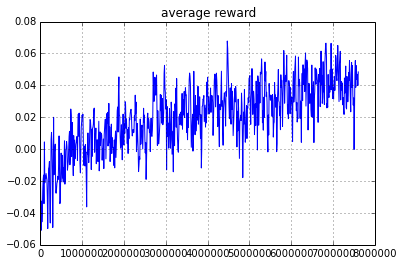

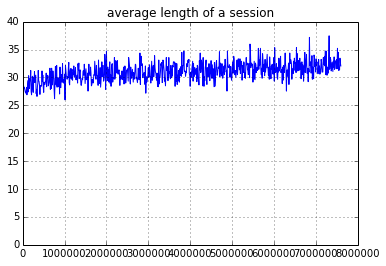

7610000 iters ( 7609999 / 1000000000 ) |sessions passed: 322 |reward: 0.0393335333116 |epsilon: 0.217241314655
7620000 iters ( 7619999 / 1000000000 ) |sessions passed: 312 |reward: 0.0429743544455 |epsilon: 0.217186957549
7630000 iters ( 7629999 / 1000000000 ) |sessions passed: 304 |reward: 0.0402158619179 |epsilon: 0.217132636098
7640000 iters ( 7639999 / 1000000000 ) |sessions passed: 318 |reward: 0.0482530568219 |epsilon: 0.217078350233
7650000 iters ( 7649999 / 1000000000 ) |sessions passed: 304 |reward: 0.0583052090377 |epsilon: 0.217024099884
7660000 iters ( 7659999 / 1000000000 ) |sessions passed: 293 |reward: 0.036519359512 |epsilon: 0.216969884981
7670000 iters ( 7669999 / 1000000000 ) |sessions passed: 318 |reward: 0.0309330852195 |epsilon: 0.216915705455
7680000 iters ( 7679999 / 1000000000 ) |sessions passed: 309 |reward: 0.0336445899677 |epsilon: 0.216861561237
7690000 iters ( 7689999 / 1000000000 ) |sessions passed: 321 |reward: 0.0396747137959 |epsilon: 0.216807452257
77

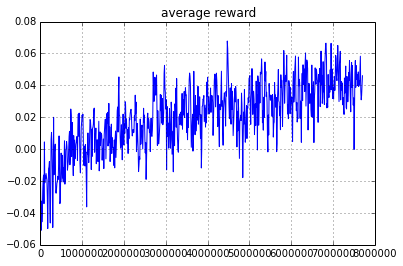

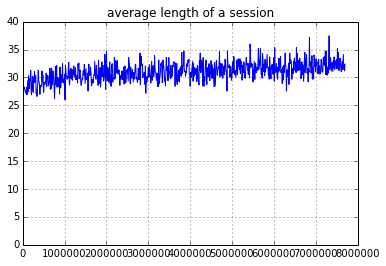

7710000 iters ( 7709999 / 1000000000 ) |sessions passed: 314 |reward: 0.0423394001329 |epsilon: 0.216699339739
7720000 iters ( 7719999 / 1000000000 ) |sessions passed: 313 |reward: 0.0418741707246 |epsilon: 0.216645336063
7730000 iters ( 7729999 / 1000000000 ) |sessions passed: 311 |reward: 0.0333470312671 |epsilon: 0.216591367353
7740000 iters ( 7739999 / 1000000000 ) |sessions passed: 303 |reward: 0.0430873805116 |epsilon: 0.216537433541
7750000 iters ( 7749999 / 1000000000 ) |sessions passed: 307 |reward: 0.0454077457047 |epsilon: 0.216483534558
7760000 iters ( 7759999 / 1000000000 ) |sessions passed: 312 |reward: 0.0500236724839 |epsilon: 0.216429670337
7770000 iters ( 7769999 / 1000000000 ) |sessions passed: 297 |reward: 0.0447400743789 |epsilon: 0.216375840811
7780000 iters ( 7779999 / 1000000000 ) |sessions passed: 326 |reward: 0.0500081134697 |epsilon: 0.216322045914
7790000 iters ( 7789999 / 1000000000 ) |sessions passed: 299 |reward: 0.0368562733712 |epsilon: 0.216268285578
7

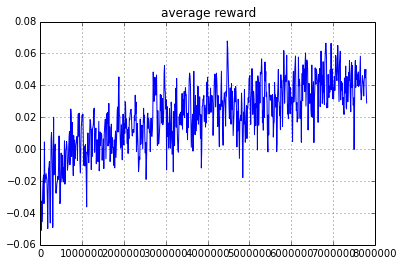

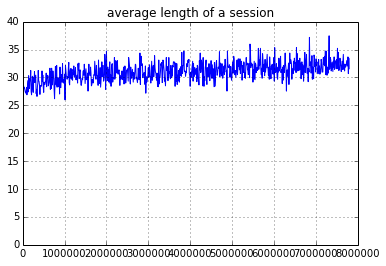

7810000 iters ( 7809999 / 1000000000 ) |sessions passed: 288 |reward: 0.0241323028925 |epsilon: 0.216160868325
7820000 iters ( 7819999 / 1000000000 ) |sessions passed: 308 |reward: 0.0328325331277 |epsilon: 0.216107211275
7830000 iters ( 7829999 / 1000000000 ) |sessions passed: 283 |reward: 0.0172810833209 |epsilon: 0.216053588522
7840000 iters ( 7839999 / 1000000000 ) |sessions passed: 317 |reward: 0.0471898924579 |epsilon: 0.216
7850000 iters ( 7849999 / 1000000000 ) |sessions passed: 293 |reward: 0.0285310267457 |epsilon: 0.215946445643
7860000 iters ( 7859999 / 1000000000 ) |sessions passed: 296 |reward: 0.0269446135874 |epsilon: 0.215892925387
7870000 iters ( 7869999 / 1000000000 ) |sessions passed: 317 |reward: 0.0326351218299 |epsilon: 0.215839439165
7880000 iters ( 7879999 / 1000000000 ) |sessions passed: 312 |reward: 0.0365154390591 |epsilon: 0.215785986914
7890000 iters ( 7889999 / 1000000000 ) |sessions passed: 294 |reward: 0.0320150649973 |epsilon: 0.215732568569
7900000 it

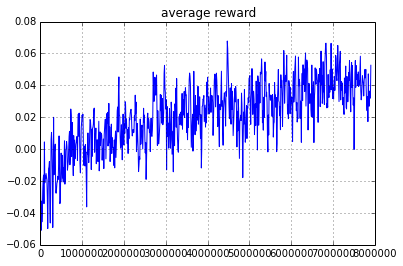

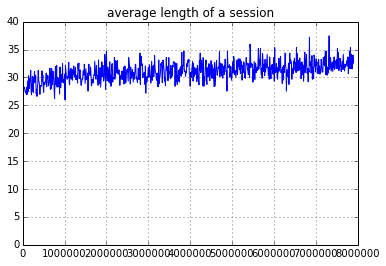

7910000 iters ( 7909999 / 1000000000 ) |sessions passed: 280 |reward: 0.0206693832455 |epsilon: 0.215625833337
7920000 iters ( 7919999 / 1000000000 ) |sessions passed: 304 |reward: 0.00847104928803 |epsilon: 0.215572516323
7930000 iters ( 7929999 / 1000000000 ) |sessions passed: 301 |reward: 0.0260716552081 |epsilon: 0.215519232958
7940000 iters ( 7939999 / 1000000000 ) |sessions passed: 287 |reward: 0.044741484188 |epsilon: 0.215465983178
7950000 iters ( 7949999 / 1000000000 ) |sessions passed: 333 |reward: 0.052235673985 |epsilon: 0.215412766921
7960000 iters ( 7959999 / 1000000000 ) |sessions passed: 311 |reward: 0.046448215187 |epsilon: 0.215359584122
7970000 iters ( 7969999 / 1000000000 ) |sessions passed: 299 |reward: 0.0225059697651 |epsilon: 0.215306434719
7980000 iters ( 7979999 / 1000000000 ) |sessions passed: 292 |reward: 0.0146854516895 |epsilon: 0.215253318649
7990000 iters ( 7989999 / 1000000000 ) |sessions passed: 341 |reward: 0.0293673929582 |epsilon: 0.215200235849
800

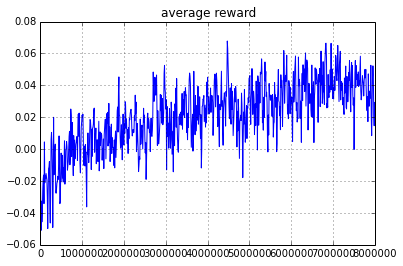

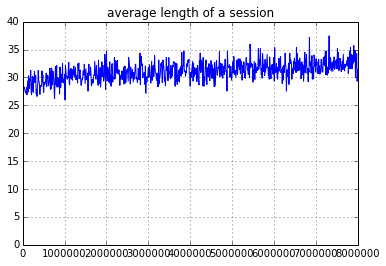

8010000 iters ( 8009999 / 1000000000 ) |sessions passed: 288 |reward: 0.0357590072003 |epsilon: 0.215094169811
8020000 iters ( 8019999 / 1000000000 ) |sessions passed: 323 |reward: 0.0439091155024 |epsilon: 0.215041186449
8030000 iters ( 8029999 / 1000000000 ) |sessions passed: 324 |reward: 0.0188878966597 |epsilon: 0.214988236108
8040000 iters ( 8039999 / 1000000000 ) |sessions passed: 319 |reward: 0.0405634679552 |epsilon: 0.214935318727
8050000 iters ( 8049999 / 1000000000 ) |sessions passed: 310 |reward: 0.0527913024129 |epsilon: 0.214882434245
8060000 iters ( 8059999 / 1000000000 ) |sessions passed: 316 |reward: 0.050150749362 |epsilon: 0.214829582601
8070000 iters ( 8069999 / 1000000000 ) |sessions passed: 319 |reward: 0.0417044425258 |epsilon: 0.214776763732
8080000 iters ( 8079999 / 1000000000 ) |sessions passed: 301 |reward: 0.0369941922041 |epsilon: 0.214723977579
8090000 iters ( 8089999 / 1000000000 ) |sessions passed: 289 |reward: 0.0473333300825 |epsilon: 0.21467122408
810

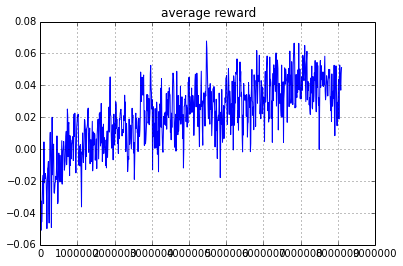

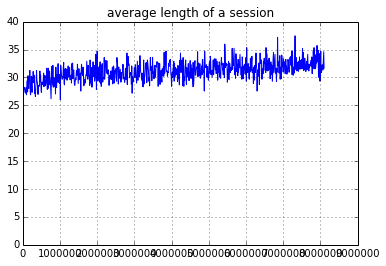

8110000 iters ( 8109999 / 1000000000 ) |sessions passed: 310 |reward: 0.045442224323 |epsilon: 0.214565814805
8120000 iters ( 8119999 / 1000000000 ) |sessions passed: 276 |reward: 0.00929642656204 |epsilon: 0.214513158907
8130000 iters ( 8129999 / 1000000000 ) |sessions passed: 283 |reward: 0.024359370956 |epsilon: 0.214460535424
8140000 iters ( 8139999 / 1000000000 ) |sessions passed: 293 |reward: 0.0384504958605 |epsilon: 0.214407944294
8150000 iters ( 8149999 / 1000000000 ) |sessions passed: 295 |reward: 0.0474564365111 |epsilon: 0.214355385458
8160000 iters ( 8159999 / 1000000000 ) |sessions passed: 330 |reward: 0.0502251142741 |epsilon: 0.214302858857
8170000 iters ( 8169999 / 1000000000 ) |sessions passed: 302 |reward: 0.0464346554201 |epsilon: 0.214250364432
8180000 iters ( 8179999 / 1000000000 ) |sessions passed: 308 |reward: 0.0497240258421 |epsilon: 0.214197902124
8190000 iters ( 8189999 / 1000000000 ) |sessions passed: 297 |reward: 0.0589534055669 |epsilon: 0.214145471872
82

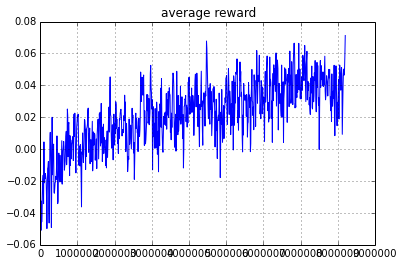

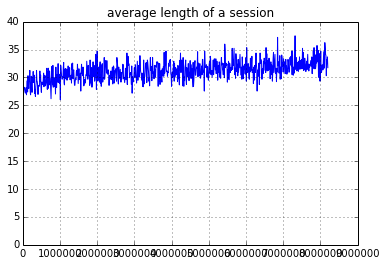

8210000 iters ( 8209999 / 1000000000 ) |sessions passed: 313 |reward: 0.0451889039067 |epsilon: 0.214040707309
8220000 iters ( 8219999 / 1000000000 ) |sessions passed: 315 |reward: 0.028019009076 |epsilon: 0.213988372879
8230000 iters ( 8229999 / 1000000000 ) |sessions passed: 305 |reward: 0.0387443401129 |epsilon: 0.213936070273
8240000 iters ( 8239999 / 1000000000 ) |sessions passed: 297 |reward: 0.0373586989145 |epsilon: 0.213883799434
8250000 iters ( 8249999 / 1000000000 ) |sessions passed: 309 |reward: 0.0303290688726 |epsilon: 0.213831560302
8260000 iters ( 8259999 / 1000000000 ) |sessions passed: 320 |reward: 0.0654865200964 |epsilon: 0.213779352821
8270000 iters ( 8269999 / 1000000000 ) |sessions passed: 302 |reward: 0.0441587729464 |epsilon: 0.213727176933
8280000 iters ( 8279999 / 1000000000 ) |sessions passed: 313 |reward: 0.0298248205874 |epsilon: 0.21367503258
8290000 iters ( 8289999 / 1000000000 ) |sessions passed: 289 |reward: 0.0550808848046 |epsilon: 0.213622919707
830

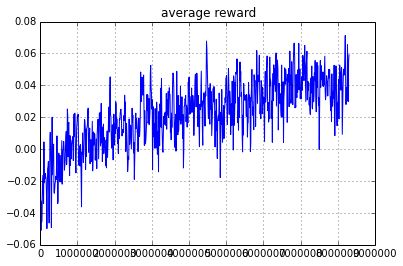

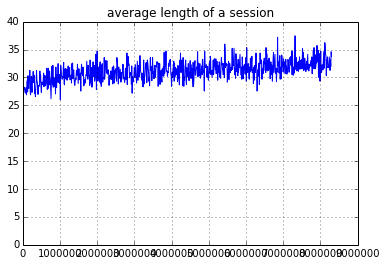

8310000 iters ( 8309999 / 1000000000 ) |sessions passed: 303 |reward: 0.0475424184103 |epsilon: 0.213518788168
8320000 iters ( 8319999 / 1000000000 ) |sessions passed: 295 |reward: 0.0300616249434 |epsilon: 0.213466769389
8330000 iters ( 8329999 / 1000000000 ) |sessions passed: 329 |reward: 0.0548153334218 |epsilon: 0.213414781862
8340000 iters ( 8339999 / 1000000000 ) |sessions passed: 308 |reward: 0.0502607064531 |epsilon: 0.213362825531
8350000 iters ( 8349999 / 1000000000 ) |sessions passed: 310 |reward: 0.0526252933713 |epsilon: 0.213310900339
8360000 iters ( 8359999 / 1000000000 ) |sessions passed: 300 |reward: 0.0222802369394 |epsilon: 0.213259006231
8370000 iters ( 8369999 / 1000000000 ) |sessions passed: 287 |reward: 0.0279784066346 |epsilon: 0.213207143151
8380000 iters ( 8379999 / 1000000000 ) |sessions passed: 310 |reward: 0.0418904044635 |epsilon: 0.213155311043
8390000 iters ( 8389999 / 1000000000 ) |sessions passed: 319 |reward: 0.0560531538617 |epsilon: 0.213103509852
8

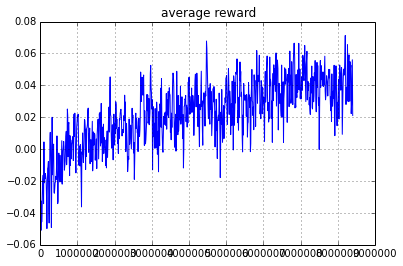

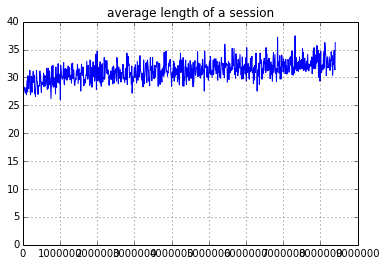

8410000 iters ( 8409999 / 1000000000 ) |sessions passed: 295 |reward: 0.0370114727277 |epsilon: 0.213
8420000 iters ( 8419999 / 1000000000 ) |sessions passed: 305 |reward: 0.0495520928071 |epsilon: 0.212948291229
8430000 iters ( 8429999 / 1000000000 ) |sessions passed: 303 |reward: 0.0485628944808 |epsilon: 0.212896613154
8440000 iters ( 8439999 / 1000000000 ) |sessions passed: 300 |reward: 0.0660578009612 |epsilon: 0.212844965722
8450000 iters ( 8449999 / 1000000000 ) |sessions passed: 310 |reward: 0.0828488614394 |epsilon: 0.212793348878
8460000 iters ( 8459999 / 1000000000 ) |sessions passed: 317 |reward: 0.0612940537871 |epsilon: 0.212741762567
8470000 iters ( 8469999 / 1000000000 ) |sessions passed: 319 |reward: 0.0605457309 |epsilon: 0.212690206735
8480000 iters ( 8479999 / 1000000000 ) |sessions passed: 300 |reward: 0.0394959742998 |epsilon: 0.212638681329
8490000 iters ( 8489999 / 1000000000 ) |sessions passed: 308 |reward: 0.0506087561846 |epsilon: 0.212587186294
8500000 iters

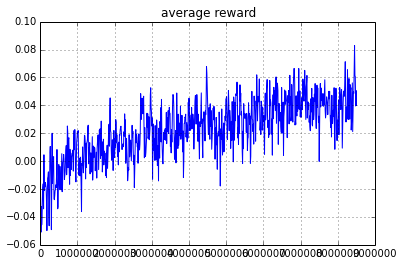

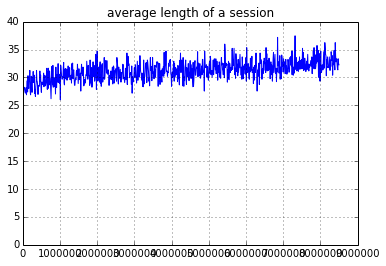

8510000 iters ( 8509999 / 1000000000 ) |sessions passed: 320 |reward: 0.0440979855559 |epsilon: 0.212484287125
8520000 iters ( 8519999 / 1000000000 ) |sessions passed: 318 |reward: 0.0331916820248 |epsilon: 0.212432882884
8530000 iters ( 8529999 / 1000000000 ) |sessions passed: 307 |reward: 0.0273683116654 |epsilon: 0.212381508801
8540000 iters ( 8539999 / 1000000000 ) |sessions passed: 271 |reward: 0.012934174921 |epsilon: 0.212330164823
8550000 iters ( 8549999 / 1000000000 ) |sessions passed: 300 |reward: 0.0434373844668 |epsilon: 0.212278850897
8560000 iters ( 8559999 / 1000000000 ) |sessions passed: 304 |reward: 0.0556648228939 |epsilon: 0.21222756697
8570000 iters ( 8569999 / 1000000000 ) |sessions passed: 321 |reward: 0.0644328627055 |epsilon: 0.21217631299
8580000 iters ( 8579999 / 1000000000 ) |sessions passed: 325 |reward: 0.0370407159357 |epsilon: 0.212125088905
8590000 iters ( 8589999 / 1000000000 ) |sessions passed: 303 |reward: 0.047390639341 |epsilon: 0.212073894661
86000

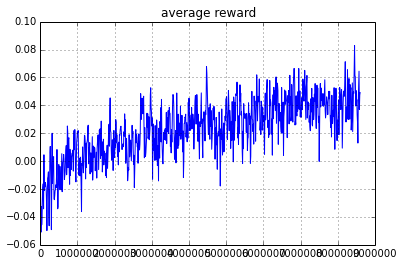

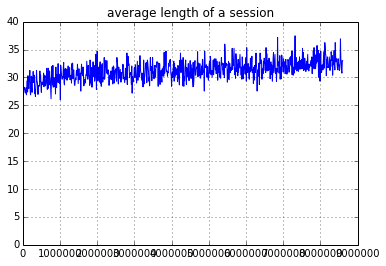

8610000 iters ( 8609999 / 1000000000 ) |sessions passed: 313 |reward: 0.05424081409 |epsilon: 0.211971595493
8620000 iters ( 8619999 / 1000000000 ) |sessions passed: 319 |reward: 0.0514638809513 |epsilon: 0.211920490465
8630000 iters ( 8629999 / 1000000000 ) |sessions passed: 299 |reward: 0.0478243228076 |epsilon: 0.211869415071
8640000 iters ( 8639999 / 1000000000 ) |sessions passed: 306 |reward: 0.0460117906137 |epsilon: 0.21181836926
8650000 iters ( 8649999 / 1000000000 ) |sessions passed: 328 |reward: 0.0572820626229 |epsilon: 0.211767352981
8660000 iters ( 8659999 / 1000000000 ) |sessions passed: 301 |reward: 0.04715634524 |epsilon: 0.211716366183
8670000 iters ( 8669999 / 1000000000 ) |sessions passed: 327 |reward: 0.0714539547034 |epsilon: 0.211665408814
8680000 iters ( 8679999 / 1000000000 ) |sessions passed: 318 |reward: 0.0672531902935 |epsilon: 0.211614480824
8690000 iters ( 8689999 / 1000000000 ) |sessions passed: 315 |reward: 0.058182407224 |epsilon: 0.211563582162
8700000

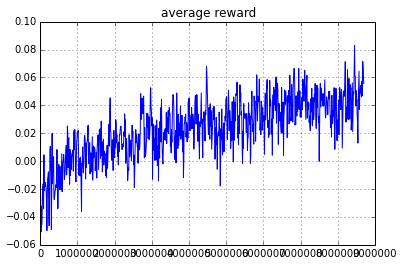

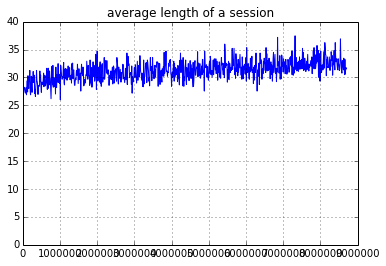

8710000 iters ( 8709999 / 1000000000 ) |sessions passed: 309 |reward: 0.0338975182886 |epsilon: 0.21146187262
8720000 iters ( 8719999 / 1000000000 ) |sessions passed: 309 |reward: 0.0739547440097 |epsilon: 0.211411061639
8730000 iters ( 8729999 / 1000000000 ) |sessions passed: 301 |reward: 0.0661504320826 |epsilon: 0.211360279784
8740000 iters ( 8739999 / 1000000000 ) |sessions passed: 312 |reward: 0.0694001232694 |epsilon: 0.211309527005
8750000 iters ( 8749999 / 1000000000 ) |sessions passed: 302 |reward: 0.0564432419249 |epsilon: 0.211258803254
8760000 iters ( 8759999 / 1000000000 ) |sessions passed: 289 |reward: 0.0421680530038 |epsilon: 0.211208108478
8770000 iters ( 8769999 / 1000000000 ) |sessions passed: 309 |reward: 0.0372595247662 |epsilon: 0.21115744263
8780000 iters ( 8779999 / 1000000000 ) |sessions passed: 304 |reward: 0.0621178224 |epsilon: 0.21110680566
8790000 iters ( 8789999 / 1000000000 ) |sessions passed: 302 |reward: 0.0499046752408 |epsilon: 0.211056197518
8800000

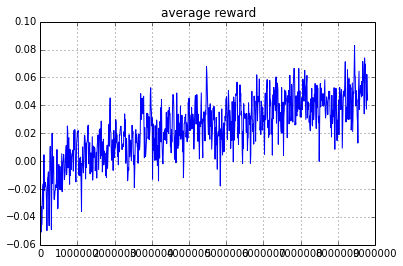

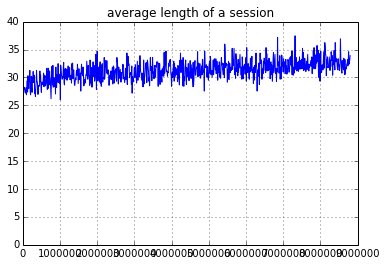

8810000 iters ( 8809999 / 1000000000 ) |sessions passed: 331 |reward: 0.07528127588 |epsilon: 0.210955067522
8820000 iters ( 8819999 / 1000000000 ) |sessions passed: 327 |reward: 0.0554399474702 |epsilon: 0.21090454557
8830000 iters ( 8829999 / 1000000000 ) |sessions passed: 305 |reward: 0.0483372477192 |epsilon: 0.210854052251
8840000 iters ( 8839999 / 1000000000 ) |sessions passed: 327 |reward: 0.0447316370999 |epsilon: 0.210803587516
8850000 iters ( 8849999 / 1000000000 ) |sessions passed: 311 |reward: 0.0584108280589 |epsilon: 0.210753151316
8860000 iters ( 8859999 / 1000000000 ) |sessions passed: 312 |reward: 0.0485130301258 |epsilon: 0.210702743603
8870000 iters ( 8869999 / 1000000000 ) |sessions passed: 308 |reward: 0.0465721795392 |epsilon: 0.210652364329
8880000 iters ( 8879999 / 1000000000 ) |sessions passed: 288 |reward: 0.0463940782911 |epsilon: 0.210602013445
8890000 iters ( 8889999 / 1000000000 ) |sessions passed: 304 |reward: 0.0486991604665 |epsilon: 0.210551690905
8900

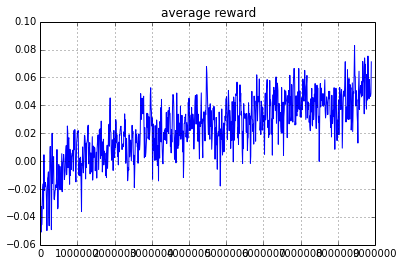

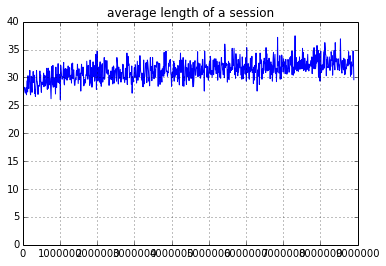

8910000 iters ( 8909999 / 1000000000 ) |sessions passed: 321 |reward: 0.0733464497191 |epsilon: 0.21045113066
8920000 iters ( 8919999 / 1000000000 ) |sessions passed: 293 |reward: 0.0433583638623 |epsilon: 0.210400892862
8930000 iters ( 8929999 / 1000000000 ) |sessions passed: 323 |reward: 0.0523027900532 |epsilon: 0.210350683215
8940000 iters ( 8939999 / 1000000000 ) |sessions passed: 290 |reward: 0.0460941737317 |epsilon: 0.210300501674
8950000 iters ( 8949999 / 1000000000 ) |sessions passed: 311 |reward: 0.0465810723118 |epsilon: 0.21025034819
8960000 iters ( 8959999 / 1000000000 ) |sessions passed: 305 |reward: 0.0540681904814 |epsilon: 0.210200222717
8970000 iters ( 8969999 / 1000000000 ) |sessions passed: 301 |reward: 0.0363679655339 |epsilon: 0.210150125209
8980000 iters ( 8979999 / 1000000000 ) |sessions passed: 318 |reward: 0.0425897324497 |epsilon: 0.210100055617
8990000 iters ( 8989999 / 1000000000 ) |sessions passed: 315 |reward: 0.0322099534939 |epsilon: 0.210050013897
900

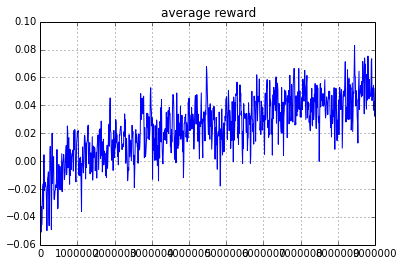

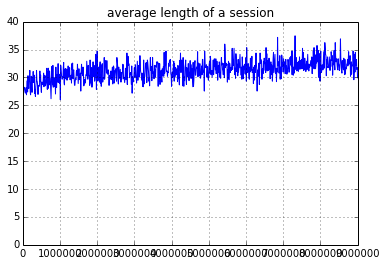

9010000 iters ( 9009999 / 1000000000 ) |sessions passed: 296 |reward: 0.0456862622856 |epsilon: 0.209950013881
9020000 iters ( 9019999 / 1000000000 ) |sessions passed: 325 |reward: 0.0538338810275 |epsilon: 0.209900055494
9030000 iters ( 9029999 / 1000000000 ) |sessions passed: 284 |reward: 0.053340594695 |epsilon: 0.209850124792
9040000 iters ( 9039999 / 1000000000 ) |sessions passed: 317 |reward: 0.0574015910485 |epsilon: 0.20980022173
9050000 iters ( 9049999 / 1000000000 ) |sessions passed: 314 |reward: 0.0705407909559 |epsilon: 0.209750346261
9060000 iters ( 9059999 / 1000000000 ) |sessions passed: 326 |reward: 0.0631333877203 |epsilon: 0.20970049834
9070000 iters ( 9069999 / 1000000000 ) |sessions passed: 309 |reward: 0.0459151057588 |epsilon: 0.209650677922
9080000 iters ( 9079999 / 1000000000 ) |sessions passed: 329 |reward: 0.0432495494588 |epsilon: 0.20960088496
9090000 iters ( 9089999 / 1000000000 ) |sessions passed: 293 |reward: 0.0334247088811 |epsilon: 0.20955111941
910000

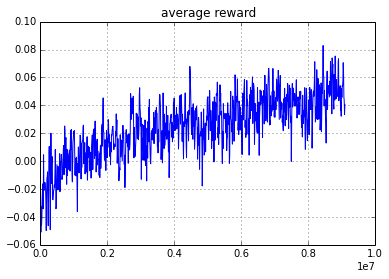

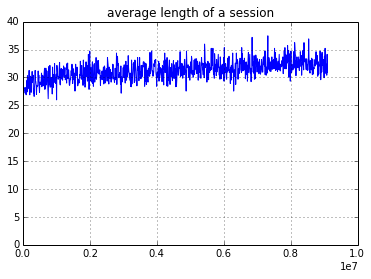

9110000 iters ( 9109999 / 1000000000 ) |sessions passed: 312 |reward: 0.0474255723293 |epsilon: 0.209451670363
9120000 iters ( 9119999 / 1000000000 ) |sessions passed: 340 |reward: 0.0691608455369 |epsilon: 0.209401986777
9130000 iters ( 9129999 / 1000000000 ) |sessions passed: 302 |reward: 0.0507231969804 |epsilon: 0.209352330422
9140000 iters ( 9139999 / 1000000000 ) |sessions passed: 310 |reward: 0.0534231478846 |epsilon: 0.209302701253
9150000 iters ( 9149999 / 1000000000 ) |sessions passed: 310 |reward: 0.0549158567906 |epsilon: 0.209253099226
9160000 iters ( 9159999 / 1000000000 ) |sessions passed: 332 |reward: 0.0545489582445 |epsilon: 0.209203524297
9170000 iters ( 9169999 / 1000000000 ) |sessions passed: 316 |reward: 0.0301110028251 |epsilon: 0.209153976422
9180000 iters ( 9179999 / 1000000000 ) |sessions passed: 314 |reward: 0.048923737803 |epsilon: 0.209104455555
9190000 iters ( 9189999 / 1000000000 ) |sessions passed: 333 |reward: 0.0643842680873 |epsilon: 0.209054961653
92

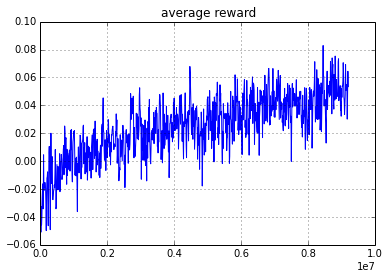

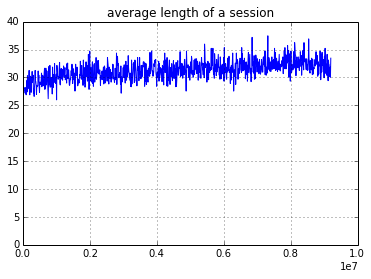

9210000 iters ( 9209999 / 1000000000 ) |sessions passed: 321 |reward: 0.0577459672895 |epsilon: 0.208956054567
9220000 iters ( 9219999 / 1000000000 ) |sessions passed: 279 |reward: 0.0208605592503 |epsilon: 0.208906641296
9230000 iters ( 9229999 / 1000000000 ) |sessions passed: 314 |reward: 0.0409986875938 |epsilon: 0.208857254814
9240000 iters ( 9239999 / 1000000000 ) |sessions passed: 305 |reward: 0.0282549759955 |epsilon: 0.208807895079
9250000 iters ( 9249999 / 1000000000 ) |sessions passed: 296 |reward: 0.0492610899169 |epsilon: 0.208758562046
9260000 iters ( 9259999 / 1000000000 ) |sessions passed: 325 |reward: 0.0603606787514 |epsilon: 0.208709255672
9270000 iters ( 9269999 / 1000000000 ) |sessions passed: 301 |reward: 0.0314807306114 |epsilon: 0.208659975914
9280000 iters ( 9279999 / 1000000000 ) |sessions passed: 330 |reward: 0.0286706749729 |epsilon: 0.20861072273
9290000 iters ( 9289999 / 1000000000 ) |sessions passed: 311 |reward: 0.0402779877421 |epsilon: 0.208561496075
93

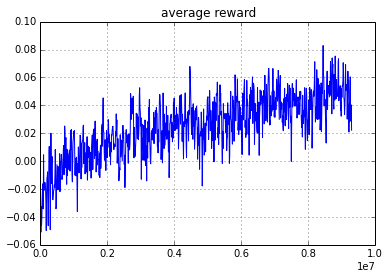

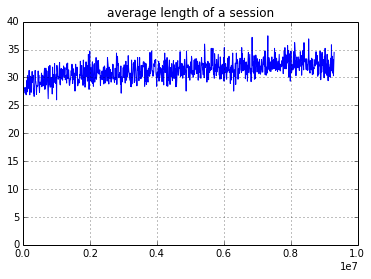

9310000 iters ( 9309999 / 1000000000 ) |sessions passed: 284 |reward: 0.018735951011 |epsilon: 0.208463122186
9320000 iters ( 9319999 / 1000000000 ) |sessions passed: 326 |reward: 0.0438643802199 |epsilon: 0.208413974865
9330000 iters ( 9329999 / 1000000000 ) |sessions passed: 302 |reward: 0.0541065895057 |epsilon: 0.208364853904
9340000 iters ( 9339999 / 1000000000 ) |sessions passed: 294 |reward: 0.0538860736134 |epsilon: 0.20831575926
9350000 iters ( 9349999 / 1000000000 ) |sessions passed: 341 |reward: 0.0352564836996 |epsilon: 0.208266690891
9360000 iters ( 9359999 / 1000000000 ) |sessions passed: 286 |reward: 0.026950725853 |epsilon: 0.208217648755
9370000 iters ( 9369999 / 1000000000 ) |sessions passed: 324 |reward: 0.0246778405225 |epsilon: 0.20816863281
9380000 iters ( 9379999 / 1000000000 ) |sessions passed: 305 |reward: 0.0435811829795 |epsilon: 0.208119643013
9390000 iters ( 9389999 / 1000000000 ) |sessions passed: 314 |reward: 0.0591312904971 |epsilon: 0.208070679324
94000

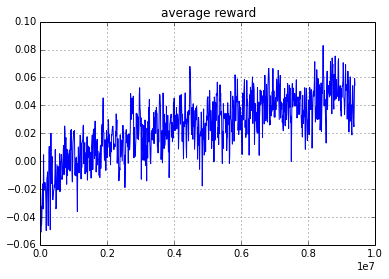

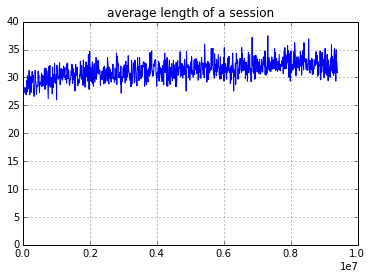

9410000 iters ( 9409999 / 1000000000 ) |sessions passed: 297 |reward: 0.0477262880593 |epsilon: 0.207972830099
9420000 iters ( 9419999 / 1000000000 ) |sessions passed: 300 |reward: 0.0438981798697 |epsilon: 0.207923944481
9430000 iters ( 9429999 / 1000000000 ) |sessions passed: 327 |reward: 0.0438498444091 |epsilon: 0.207875084803
9440000 iters ( 9439999 / 1000000000 ) |sessions passed: 299 |reward: 0.0573010106388 |epsilon: 0.207826251026
9450000 iters ( 9449999 / 1000000000 ) |sessions passed: 278 |reward: 0.0575753535083 |epsilon: 0.207777443106
9460000 iters ( 9459999 / 1000000000 ) |sessions passed: 312 |reward: 0.0516320374694 |epsilon: 0.207728661005
9470000 iters ( 9469999 / 1000000000 ) |sessions passed: 301 |reward: 0.0568419765101 |epsilon: 0.207679904679
9480000 iters ( 9479999 / 1000000000 ) |sessions passed: 311 |reward: 0.0525714354683 |epsilon: 0.20763117409
9490000 iters ( 9489999 / 1000000000 ) |sessions passed: 303 |reward: 0.0523366173766 |epsilon: 0.207582469196
95

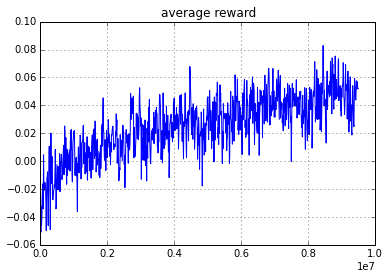

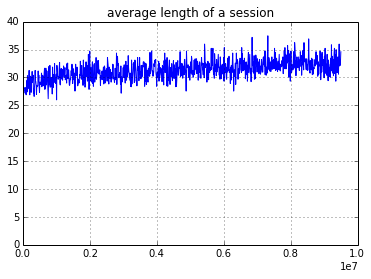

9510000 iters ( 9509999 / 1000000000 ) |sessions passed: 287 |reward: 0.0619246615329 |epsilon: 0.207485136329
9520000 iters ( 9519999 / 1000000000 ) |sessions passed: 307 |reward: 0.0724783977175 |epsilon: 0.207436508277
9530000 iters ( 9529999 / 1000000000 ) |sessions passed: 316 |reward: 0.0655052004415 |epsilon: 0.207387905757
9540000 iters ( 9539999 / 1000000000 ) |sessions passed: 276 |reward: 0.0273878898018 |epsilon: 0.207339328731
9550000 iters ( 9549999 / 1000000000 ) |sessions passed: 291 |reward: 0.0219697529179 |epsilon: 0.207290777158
9560000 iters ( 9559999 / 1000000000 ) |sessions passed: 302 |reward: 0.0319120998392 |epsilon: 0.207242250998
9570000 iters ( 9569999 / 1000000000 ) |sessions passed: 316 |reward: 0.0405012674456 |epsilon: 0.20719375021
9580000 iters ( 9579999 / 1000000000 ) |sessions passed: 322 |reward: 0.0432668514625 |epsilon: 0.207145274757
9590000 iters ( 9589999 / 1000000000 ) |sessions passed: 317 |reward: 0.0484431697959 |epsilon: 0.207096824597
96

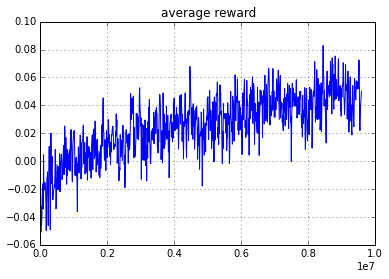

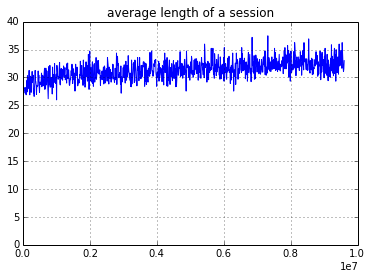

9610000 iters ( 9609999 / 1000000000 ) |sessions passed: 298 |reward: 0.0382827717004 |epsilon: 0.207
9620000 iters ( 9619999 / 1000000000 ) |sessions passed: 301 |reward: 0.0615690241444 |epsilon: 0.206951625484
9630000 iters ( 9629999 / 1000000000 ) |sessions passed: 323 |reward: 0.0465769600783 |epsilon: 0.206903276105
9640000 iters ( 9639999 / 1000000000 ) |sessions passed: 316 |reward: 0.0754526175132 |epsilon: 0.206854951822
9650000 iters ( 9649999 / 1000000000 ) |sessions passed: 291 |reward: 0.061537088628 |epsilon: 0.206806652598
9660000 iters ( 9659999 / 1000000000 ) |sessions passed: 297 |reward: 0.0444903274849 |epsilon: 0.206758378392
9670000 iters ( 9669999 / 1000000000 ) |sessions passed: 298 |reward: 0.0530415287115 |epsilon: 0.206710129167
9680000 iters ( 9679999 / 1000000000 ) |sessions passed: 305 |reward: 0.0170321956747 |epsilon: 0.206661904883
9690000 iters ( 9689999 / 1000000000 ) |sessions passed: 306 |reward: 0.0314568642376 |epsilon: 0.206613705502
9700000 ite

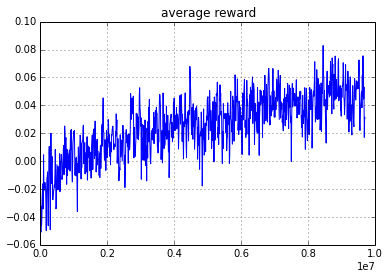

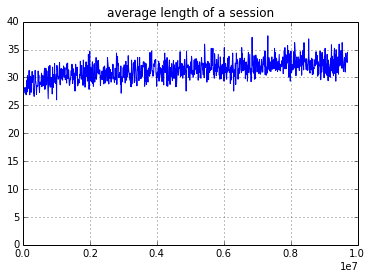

9710000 iters ( 9709999 / 1000000000 ) |sessions passed: 302 |reward: 0.0409847906966 |epsilon: 0.206517381295
9720000 iters ( 9719999 / 1000000000 ) |sessions passed: 302 |reward: 0.0623763422611 |epsilon: 0.206469256391
9730000 iters ( 9729999 / 1000000000 ) |sessions passed: 296 |reward: 0.0525082162635 |epsilon: 0.206421156237
9740000 iters ( 9739999 / 1000000000 ) |sessions passed: 314 |reward: 0.0505535784712 |epsilon: 0.206373080794
9750000 iters ( 9749999 / 1000000000 ) |sessions passed: 294 |reward: 0.0554929247949 |epsilon: 0.206325030024
9760000 iters ( 9759999 / 1000000000 ) |sessions passed: 322 |reward: 0.0687392762595 |epsilon: 0.206277003889
9770000 iters ( 9769999 / 1000000000 ) |sessions passed: 306 |reward: 0.0567400378028 |epsilon: 0.206229002351
9780000 iters ( 9779999 / 1000000000 ) |sessions passed: 305 |reward: 0.0360093253622 |epsilon: 0.206181025373
9790000 iters ( 9789999 / 1000000000 ) |sessions passed: 309 |reward: 0.0534132254222 |epsilon: 0.206133072917
9

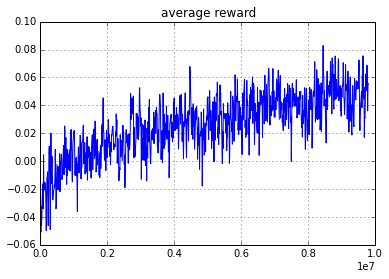

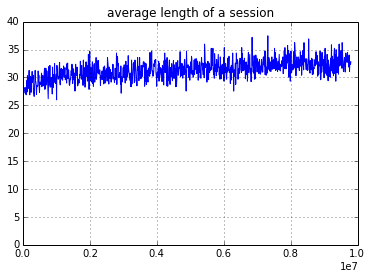

9810000 iters ( 9809999 / 1000000000 ) |sessions passed: 296 |reward: 0.0488380854511 |epsilon: 0.20603724142
9820000 iters ( 9819999 / 1000000000 ) |sessions passed: 276 |reward: 0.0424827319124 |epsilon: 0.205989362304
9830000 iters ( 9829999 / 1000000000 ) |sessions passed: 282 |reward: 0.0585204909199 |epsilon: 0.20594150756
9840000 iters ( 9839999 / 1000000000 ) |sessions passed: 310 |reward: 0.0578031147389 |epsilon: 0.205893677152
9850000 iters ( 9849999 / 1000000000 ) |sessions passed: 299 |reward: 0.0294376104228 |epsilon: 0.205845871041
9860000 iters ( 9859999 / 1000000000 ) |sessions passed: 295 |reward: 0.03385759848 |epsilon: 0.205798089191
9870000 iters ( 9869999 / 1000000000 ) |sessions passed: 305 |reward: 0.0482549771743 |epsilon: 0.205750331566
9880000 iters ( 9879999 / 1000000000 ) |sessions passed: 302 |reward: 0.0459799723355 |epsilon: 0.205702598127
9890000 iters ( 9889999 / 1000000000 ) |sessions passed: 288 |reward: 0.0419475810615 |epsilon: 0.205654888839
99000

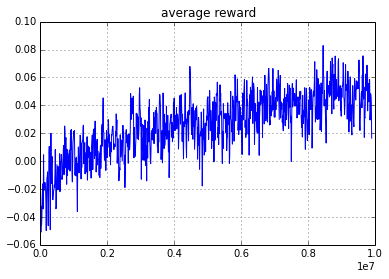

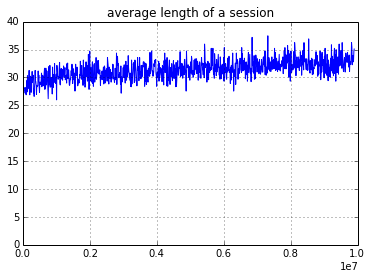

9910000 iters ( 9909999 / 1000000000 ) |sessions passed: 286 |reward: 0.0281620250641 |epsilon: 0.205559542568
9920000 iters ( 9919999 / 1000000000 ) |sessions passed: 327 |reward: 0.0267454117027 |epsilon: 0.205511905512
9930000 iters ( 9929999 / 1000000000 ) |sessions passed: 306 |reward: 0.0432141156208 |epsilon: 0.20546429246
9940000 iters ( 9939999 / 1000000000 ) |sessions passed: 321 |reward: 0.0481955490194 |epsilon: 0.205416703377
9950000 iters ( 9949999 / 1000000000 ) |sessions passed: 316 |reward: 0.0491987627179 |epsilon: 0.205369138226
9960000 iters ( 9959999 / 1000000000 ) |sessions passed: 306 |reward: 0.049683024675 |epsilon: 0.205321596972
9970000 iters ( 9969999 / 1000000000 ) |sessions passed: 310 |reward: 0.0490418967943 |epsilon: 0.205274079577
9980000 iters ( 9979999 / 1000000000 ) |sessions passed: 318 |reward: 0.0466354362492 |epsilon: 0.205226586006
9990000 iters ( 9989999 / 1000000000 ) |sessions passed: 300 |reward: 0.0342921683723 |epsilon: 0.205179116224
100

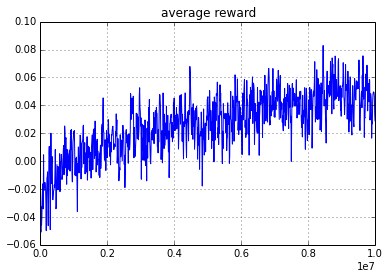

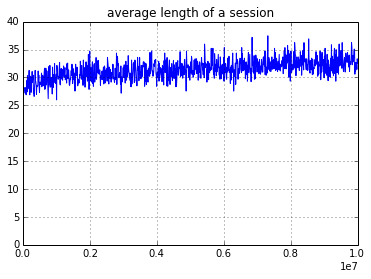

10010000 iters ( 10009999 / 1000000000 ) |sessions passed: 301 |reward: 0.0208795845111 |epsilon: 0.205084247883
10020000 iters ( 10019999 / 1000000000 ) |sessions passed: 313 |reward: 0.0360313112624 |epsilon: 0.205036849252
10030000 iters ( 10029999 / 1000000000 ) |sessions passed: 311 |reward: 0.0260295327179 |epsilon: 0.204989474267
10040000 iters ( 10039999 / 1000000000 ) |sessions passed: 313 |reward: 0.0442797449164 |epsilon: 0.204942122893
10050000 iters ( 10049999 / 1000000000 ) |sessions passed: 301 |reward: 0.0573254909603 |epsilon: 0.204894795095
10060000 iters ( 10059999 / 1000000000 ) |sessions passed: 305 |reward: 0.0506044172099 |epsilon: 0.204847490837
10070000 iters ( 10069999 / 1000000000 ) |sessions passed: 301 |reward: 0.0403658773144 |epsilon: 0.204800210084
10080000 iters ( 10079999 / 1000000000 ) |sessions passed: 305 |reward: 0.0258333905248 |epsilon: 0.204752952802
10090000 iters ( 10089999 / 1000000000 ) |sessions passed: 330 |reward: 0.0688666852172 |epsilon

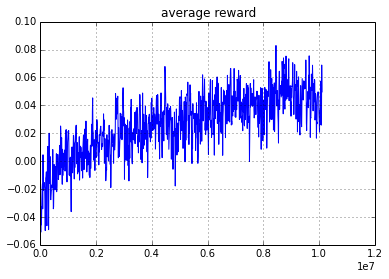

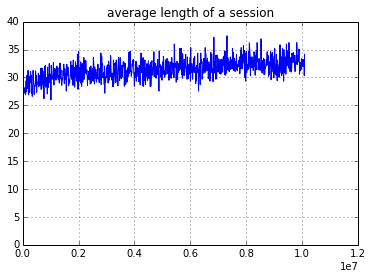

10110000 iters ( 10109999 / 1000000000 ) |sessions passed: 304 |reward: 0.0387206416398 |epsilon: 0.204611321426
10120000 iters ( 10119999 / 1000000000 ) |sessions passed: 314 |reward: 0.0606655740893 |epsilon: 0.204564157676
10130000 iters ( 10129999 / 1000000000 ) |sessions passed: 317 |reward: 0.0788028256726 |epsilon: 0.204517017223
10140000 iters ( 10139999 / 1000000000 ) |sessions passed: 323 |reward: 0.0631332477013 |epsilon: 0.204469900031
10150000 iters ( 10149999 / 1000000000 ) |sessions passed: 306 |reward: 0.0537454557215 |epsilon: 0.204422806068
10160000 iters ( 10159999 / 1000000000 ) |sessions passed: 330 |reward: 0.0627629748215 |epsilon: 0.204375735297
10170000 iters ( 10169999 / 1000000000 ) |sessions passed: 332 |reward: 0.0668108515631 |epsilon: 0.204328687685
10180000 iters ( 10179999 / 1000000000 ) |sessions passed: 310 |reward: 0.044703938807 |epsilon: 0.204281663199
10190000 iters ( 10189999 / 1000000000 ) |sessions passed: 289 |reward: 0.0515856128549 |epsilon:

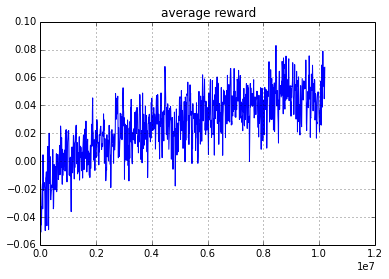

KeyboardInterrupt: 

In [15]:
#
ss = Session(generate_event())
session_iter = 1

a.reset_state()
n_iters = 1000000000

report_rate = 10000
draw_rate = 100000


for i in xrange(n_iters):
    itr +=1
    
    randomness = max(0.01,(1. - itr**.5/10000.) *0.3 )
    reward = a.step(ss,
                    greediness=10.,
                    randomness_rate=randomness)
    reward_ma = moving_average_rate*reward + (1-moving_average_rate)*reward_ma 
    if ss.has_ended:
        ss = Session(generate_event())
        session_iter +=1
        
    if  itr>0 and itr%report_rate ==0 :
        print itr,"iters",'(',i,'/',n_iters,")",'|sessions passed:',session_iter, '|reward:',reward_ma,"|epsilon:",randomness
        
        avg_session_length = float(report_rate) / ( max(session_iter,1) ) 
        session_iter =0 
        session_length_history.append(avg_session_length)
        rewards_history.append(reward_ma)
        report_iter.append(itr)
        
    if i%draw_rate ==0:
        plt.plot(report_iter,rewards_history)
        plt.grid()
        plt.title("average reward")
        plt.show()
        plt.plot(report_iter,session_length_history)
        plt.grid()
        plt.title("average length of a session")
        plt.show()
        

new event


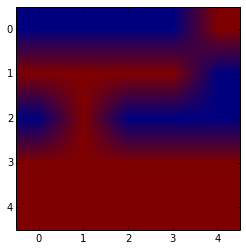

chosen action #11 : (0, 2, 1) (p = 0.0365512785764)
got response True, reward 1
chosen action #18 : (0, 3, 3) (p = 0.166714200443)
got response True, reward 1
chosen action #17 : (0, 3, 2) (p = 0.147072730819)
got response True, reward 1
chosen action #21 : (0, 4, 1) (p = 0.798437410677)
got response True, reward 1
chosen action #20 : (0, 4, 0) (p = 0.996694973964)
got response True, reward 1
chosen action #13 : (0, 2, 3) (p = 0.46056708114)
got response False, reward -1
chosen action #24 : (0, 4, 4) (p = 0.0292677648292)
got response True, reward 1
chosen action #23 : (0, 4, 3) (p = 0.0384615384615)
got response True, reward 1
chosen action #0 : (0, 0, 0) (p = 0.0384615384615)
got response False, reward -1
chosen action #5 : (0, 1, 0) (p = 0.0384615384615)
got response True, reward 1
chosen action #12 : (0, 2, 2) (p = 0.0384615384615)
got response False, reward -1
chosen action #21 : (0, 4, 1) (p = 0.0384615384615)
got response True, reward -0.0001
chosen action #23 : (0, 4, 3) (p = 0

In [16]:
#
a.reset_state()

ss = Session(generate_event())
print "new event"
plt.imshow(ss.event.arr[0])
plt.show()

n_iters = 100
for i in xrange(n_iters):
    a.step(ss,verbose=1)
    if ss.has_ended:
        ss = Session(generate_event())
        print "new event"
        plt.imshow(ss.event.arr[0])
        plt.show()



# simple NN

In [259]:
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
_shared = lambda name,val,dtype: theano.shared(val.astype(dtype),name,
                                               strict = True,allow_downcast=True)
floatX = theano.config.floatX

In [289]:
arr_shape =(1, 5, 5)
_arr = _shared("arr_map",np.zeros(arr_shape),'int8')
_attempted = _shared("arr_attempted",np.zeros(arr_shape),'int8')


arr_map

In [260]:
#batch_i,session_i(single session for now),row,col
response_shape = [1,None,1,1]
action_shape = [1,None,1,len(action_ids)]

_last_response = T.tensor4("last_response")
_last_action = T.tensor4("last_action")
#_decisions = 

_reference_Qvalues = T.tensor4("reference_action_Qvalues")

In [273]:


fake_input_shape = [1,None,1,1]


from retina.MDPlayer import GRULayer


_fake_input = T.tensor4("fake_inp")
_nn_inp = lasagne.layers.InputLayer(fake_input_shape,name="fake_inp",
                                          input_var = _fake_input)
_nn_inp.output_shape

[1, None, 1, 1]

TypeError: __init__() takes at least 5 arguments (2 given)

In [ ]:
GRULayer(_nn_inp)

In [223]:
from retina.layers import _tanh_leaky

In [246]:
import theano
import theano.tensor as T

k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior0,prior1, A: (prior0 * A, prior1+A),
                              outputs_info=(T.ones_like(A),T.zeros_like(A)),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
fres1,fres2 = result
fres1 = fres1[-1]
fres2 = fres2[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=[fres1,fres2], updates=updates)

print power(range(10),2)
print power(range(10),4)

[array([  0.,   1.,   4.,   9.,  16.,  25.,  36.,  49.,  64.,  81.], dtype=float32), array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.], dtype=float32)]
[array([  0.00000000e+00,   1.00000000e+00,   1.60000000e+01,
         8.10000000e+01,   2.56000000e+02,   6.25000000e+02,
         1.29600000e+03,   2.40100000e+03,   4.09600000e+03,
         6.56100000e+03], dtype=float32), array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.], dtype=float32)]


In [247]:
#print power(range(10),3)[0]

print power(range(10),3)[1]

[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.]


TypeError: __init__() takes at least 5 arguments (2 given)

In [216]:
_nn_resp_input = lasagne.layers.InputLayer(response_shape,name="response_inp",
                                          input_var = _last_response)
_nn_last_action_input = lasagne.layers.InputLayer(action_shape,name="last_action_inp",
                                                 input_var = _last_action)

_nn_input = lasagne.layers.ConcatLayer([_nn_resp_input,_nn_last_action_input],
                                 name="concatenated_inp",
                                 axis=3)

#_nn_inp = lasagne.layers.DropoutLayer(_nn,name="drop_from_inp",p=0.1)


#RNN
_rnn = lasagne.layers.GRULayer(_nn_input,num_units=100,name="rnn_gru0",)

_rnn_flat = lasagne.layers.ReshapeLayer(_rnn, [-1] + list(_rnn.output_shape[2:]))

#output
_nn = lasagne.layers.DenseLayer(_rnn_flat,name="dense0",
#                                num_units = 100,
#                                nonlinearity = _tanh_leaky
#                               )
#_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense0",p=0.25)

#_nn = lasagne.layers.DenseLayer(_nn,name="dense_output",
                                num_units = np.prod(action_shape[2:]),
                                nonlinearity = lasagne.nonlinearities.softmax
                               )

#_nn = lasagne.layers.ReshapeLayer(_nn,name="reshaper",shape = [1]+action_shape[1:])

In [220]:
last_response = np.ones([1,3]+response_shape[2:],dtype='float32')
last_action = np.zeros([1,3]+action_shape[2:],dtype='float32')

predict(last_action,last_response)

array([[ 0.03570932,  0.0419211 ,  0.0376352 ,  0.03367737,  0.03815759,
         0.03102576,  0.04177476,  0.03961721,  0.03668237,  0.03745261,
         0.04224369,  0.0412501 ,  0.03756968,  0.04399344,  0.03941263,
         0.0418994 ,  0.03999332,  0.03626559,  0.0335102 ,  0.03759531,
         0.03925442,  0.03901468,  0.04131543,  0.03711001,  0.03567308,
         0.04024573],
       [ 0.03424345,  0.04430222,  0.03827569,  0.0313165 ,  0.03806841,
         0.02808163,  0.04248435,  0.04005142,  0.03597057,  0.03732562,
         0.04486693,  0.04250393,  0.03711521,  0.04619891,  0.03938582,
         0.04287161,  0.03985241,  0.03461058,  0.03158268,  0.03742971,
         0.04025745,  0.03929194,  0.0420816 ,  0.03708214,  0.0330452 ,
         0.04170404],
       [ 0.03352824,  0.04585539,  0.0391858 ,  0.030056  ,  0.03807341,
         0.02697673,  0.04198209,  0.04013989,  0.03567284,  0.03716758,
         0.04628522,  0.04335527,  0.03694259,  0.04638558,  0.0390767 ,
       

In [ ]:
_rnn.

In [217]:
_prediction = lasagne.layers.get_output(_nn)
intrain_predict = theano.function([_last_response,_last_action],_prediction)

_det_prediction = lasagne.layers.get_output(_nn,deterministic=True)
predict = theano.function([_last_response,_last_action],_det_prediction)

In [181]:
_weights = lasagne.layers.get_all_params(_nn)
_weights

[rnn_gru0.W_in_to_updategate,
 rnn_gru0.W_hid_to_updategate,
 rnn_gru0.b_updategate,
 rnn_gru0.W_in_to_resetgate,
 rnn_gru0.W_hid_to_resetgate,
 rnn_gru0.b_resetgate,
 rnn_gru0.W_in_to_hidden_update,
 rnn_gru0.W_hid_to_hidden_update,
 rnn_gru0.b_hidden_update,
 rnn_gru0.hid_init,
 dense0.W,
 dense0.b]

In [182]:
_choices = 

_loss_vector = lasagne.objectives.squared_error(_prediction,_reference_Qvalues)

_updates = lasagne.updates.nesterov_momentum(_loss[_choices],_weights,learning_rate=0.1)


TypeError: cost must be a scalar.

In [179]:
import theano.tensor.raw_random as Trand
import theano.tensor.shared_randomstreams as Trstreams

In [176]:
_prediction = (T.arange(260)%7).reshape([-1,1]+action_shape[2:])


_loss_selector = T.vertical_stack(arrays)


_loss_selector.eval()

array([[[6]],

       [[1]],

       [[3]],

       [[5]],

       [[0]],

       [[2]],

       [[4]],

       [[6]],

       [[1]],

       [[3]]])

In [144]:
_a[_loss_selector].eval()

array([[[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]],





       [[[[[[20, 21, 22, 23, 24]]]]]]])

In [127]:
from collections import defaultdict

actions = get_action_codes(generate_event())
action_ids = np.arange(len(actions))
action_to_id = {i:a for i,a in enumerate(actions)}.get


alpha= 0.1 #learning rate
gamma= 0.99 #delayed reward penalty

class Agent():
    def __init__(self):
        #Q[state_id][action_id]
        self.Q
        
        self.reset_state()
    def reset_state(self):
        self.state = (-1,)*arr_len

    def step(self,session,greediness = 1.,randomness_rate = 0.,verbose=False):
        
        
        #decision making via softmax probas        
        action_Qvalues = self.Q[self.state]
        
        if np.random.random() < randomness_rate:
            action_probas = np.repeat(1./len(action_Qvalues) ,repeats = len(action_Qvalues))
        else:
            action_probas = np.exp(action_Qvalues*greediness)
            action_probas /= np.sum(action_probas)
                
        choice_id = np.random.choice(action_ids,p=action_probas)
        
        if verbose>=1:
            print "chosen action #%s : %s (p = %s)"%(choice_id, actions[choice_id], action_probas[choice_id])
        
        
        #state transition
        response,reward = session.act(actions[choice_id])
        
        #session ended
        if response is None:
            
            if verbose:
                print "session ended"
            self.reset_state()
            return reward
        
        if verbose>=1:
            print "got response %s, reward %s"%(response,reward)
        
    
        new_state = session.new_state(self.state,choice_id,response)
        
        #learning
        predicted_Qvalue = self.Q[self.state][choice_id]
        
        actual_Qvalue = reward + gamma* np.max(self.Q[new_state])
        
        dQ = (actual_Qvalue - predicted_Qvalue) *alpha
        
        if verbose >=2:
            print "actual Q = %s , predicted %s" %(actual_Qvalue,predicted_Qvalue)

        self.Q[self.state][choice_id] += dQ
        
        if verbose >=2:
            print "updated by %s, now %s"%(dQ, self.Q[self.state][choice_id])
        
        
        #updating state
        self.state = new_state
        
        return reward
    



Subtensor{::, int64}.0

In [ ]:
#SparseDot(#J_mask,exp(x_i))

In [2]:
response,shareds = get_response_with_shared_hits()
_xhits,_yhits,_zhits = shareds

In [3]:
import pandas as pd
hits = pd.DataFrame.from_csv("/mnt/KSfinder/mc_bg_up_hits/00111113_0000000001.hits.csv")[["X","Y","Z"]].values
hits_x,hits_y,hits_z = hits.T.astype("float32")


In [4]:
_xhits.set_value(hits_x)
_yhits.set_value(hits_y)
_zhits.set_value(hits_z)

In [5]:
import numpy as np
resp = response(0,0,2000,0,np.pi/8,0,np.pi/8,20,32,32)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

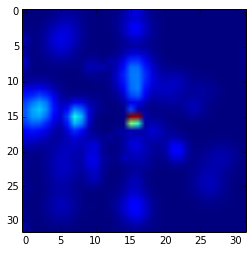

In [7]:
plt.imshow(resp.reshape(32,32).T)

In [55]:
_xhits.get_value()

array([ 0.,  1.,  2.,  3.,  4.], dtype=float32)

In [37]:
_beta.eval({_beta0:1,_dbeta:0.1,_xdim:4,_ydim:4})

array([ 0.9       ,  0.96666667,  1.03333333,  1.1       ,  0.9       ,
        0.96666667,  1.03333333,  1.1       ,  0.9       ,  0.96666667,
        1.03333333,  1.1       ,  0.9       ,  0.96666667,  1.03333333,
        1.1       ])

In [2]:

#initialize response parameters


floatX = theano.config.floatX
givens = {
    _x0:x0.astype(floatX),
    _y0:y0.astype(floatX),
    _z0:z0.astype(floatX),
    _alpha:alpha.astype(floatX),
    _beta:beta.astype(floatX),
}



#sigma
_sigma_var = T.scalar("retina.sigma","float32") #hard-code here

if sigma is None:
    inputs.append(_sigma_var)
else:
    givens[_sigma_var] = np.float32(sigma)

#retina response

res= theano.function(inputs = inputs,
                          outputs=_response,
                          givens = givens,
                          allow_input_downcast=allow_downcast,
                         )


NameError: name 'x0' is not defined